### Import


In [49]:
import numpy as np
import pandas as pd
import torchvision.datasets as ds
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from copy import deepcopy
import os
import shutil

### Dataset


In [50]:
class Dataset:
    def __init__(self):
        self.transform = transforms.ToTensor()
        self.trainset = self.load_train_data()
        self.testset = self.load_test_data()

    def load_train_data(self):
        trainset = ds.FashionMNIST(
            root='./data', train=True, download=True, transform=self.transform)
        return trainset

    def load_test_data(self):
        testset = ds.FashionMNIST(
            root='./data', train=False, download=True, transform=self.transform)
        return testset

    def get_train_data(self):
        return self.trainset

    def get_test_data(self):
        return self.testset

    def split_data(self, data, test_size=0.2):

        train_data, val_data = train_test_split(
            data, test_size=test_size, random_state=42)

        return train_data, val_data

    def preprocess_FashionMNIST(self, data):
        processed_data = []

        for i in range(len(data)):
            image, label = data[i]
            image = image.numpy().flatten()
            image = image / 255.0
            if np.isnan(label) == False:
                processed_data.append([image, label])

        processed_data = np.array(processed_data, dtype=object)
        return processed_data

    def get_data(self):
        train_data = self.preprocess_FashionMNIST(self.trainset)
        test_data = self.preprocess_FashionMNIST(self.testset)

        train_data, val_data = self.split_data(train_data)

        X_train = np.array([i[0] for i in train_data])
        y_train = np.array([i[1] for i in train_data])
        X_val = np.array([i[0] for i in val_data])
        y_val = np.array([i[1] for i in val_data])
        X_test = np.array([i[0] for i in test_data])
        y_test = np.array([i[1] for i in test_data])

        y_train = self.one_hot(y_train)
        y_val = self.one_hot(y_val)
        y_test = self.one_hot(y_test)

        return X_train, y_train, X_val, y_val, X_test, y_test

    # one hot encoding for the labels
    def one_hot(self, y):
        n_values = 10
        y = y.astype(int)
        y = np.eye(n_values)[y.reshape(-1)]
        return y

### Layer


In [51]:
class Layer:
    def forward(self, X):
        raise NotImplementedError

    def backward(self, output_grad, learning_rate):
        raise NotImplementedError

### Optimizer


In [52]:

class AdamOptimizer:
    def __init__(self,  beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = None
        self.v = None
        self.t = 0

    def minimize(self, weights, bias, weights_grad, bias_grad, learning_rate):
        self.t += 1
        # combine weights and bias gradients
        combined = np.concatenate(
            [weights_grad.flatten(), bias_grad.flatten()])
        if self.m is None:
            self.m = np.zeros_like(combined)
            self.v = np.zeros_like(combined)

        self.m = self.beta1 * self.m + (1 - self.beta1) * combined
        self.v = self.beta2 * self.v + (1 - self.beta2) * combined**2

        m_hat = self.m / (1 - self.beta1**self.t)
        v_hat = self.v / (1 - self.beta2**self.t)

        combined_update = learning_rate * \
            m_hat / (np.sqrt(v_hat) + self.epsilon)
        weights_update = combined_update[:weights.size].reshape(weights.shape)
        bias_update = combined_update[weights.size:]

        weights = weights - weights_update
        bias = bias - bias_update

        return weights, bias

### Dense Layer


In [53]:

def xavier_init(input_size, output_size, mode='uniform'):
    if mode == 'normal':
        stddev = np.sqrt(2 / (input_size + output_size))
        return np.random.normal(0, stddev, (input_size, output_size))
    
    elif mode == 'uniform':
        limit = np.sqrt(6 / (input_size + output_size))
        return np.random.uniform(-limit, limit, (input_size, output_size))
    



class DenseLayer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = xavier_init(input_size, output_size)
        self.bias = np.zeros((1, output_size))
        self.input = None
        self.output = None
        self.input_size = input_size
        self.output_size = output_size
        self.optimizer = AdamOptimizer()

    def forward(self, X):
        self.input = X
        self.output = np.dot(X, self.weights) + self.bias
        return self.output

    def backward(self, output_grad, learning_rate):
        input_grad = np.dot(output_grad, self.weights.T)
        weights_grad = np.dot(self.input.T, output_grad)
        bias_grad = np.sum(output_grad, axis=0, keepdims=True)

        self.weights, self.bias = self.optimizer.minimize(
            self.weights, self.bias, weights_grad, bias_grad, learning_rate)
        return input_grad
    
    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

### ReLU Layer


In [54]:
class ReLULayer(Layer):
    def forward(self, X):
        self.input = X
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, output_grad, learning_rate):
        return output_grad * np.where(self.input > 0, 1, 0)

### Tanh Layer


In [55]:
class TanhLayer(Layer):
    def forward(self, X):
        self.input = X
        self.output = np.tanh(X)
        return self.output

    def backward(self, output_grad, learning_rate):
        return output_grad * (1 - np.tanh(self.input)**2)

### Sigmoid Layer


In [56]:
class SigmoidLayer(Layer):
    def forward(self, X):
        self.input = X
        self.output = self.sigmoid(X)
        return self.output

    def backward(self, output_grad, learning_rate):
        return output_grad * self.output * (1 - self.output)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

### Softmax Layer


In [57]:
class SoftmaxLayer(Layer):

    def forward(self, X):
        self.input = X
        exps = np.exp(X - np.max(X, axis=1, keepdims=True))
        self.output = exps / np.sum(exps, axis=1, keepdims=True)
        return self.output

    def backward(self, output_grad, learning_rate, loss_func='cross_entropy'):
        if loss_func == 'cross_entropy':
            input_grad = output_grad
        else:
            # https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
            input_grad = np.zeros_like(output_grad)
            for i in range(output_grad.shape[0]):
                jacobian = - \
                    np.outer(self.output[i], self.output[i]
                             ) + np.diag(self.output[i])
                input_grad[i] = np.dot(output_grad[i], jacobian)

        return input_grad

### Dropout Layer


In [ ]:
class DropoutLayer(Layer):
    def __init__(self, p):
        self.p = p
        self.mask = None

    def forward(self, X, training=True):
        self.input = X

        if training == False or self.p == 0:
            self.output = X
            return self.output

        if self.p == 1:
            self.output = np.zeros(X.shape)
            return self.output

        # self.mask = np.random.binomial(1, self.p, size=X.shape) / self.p
        # self.output = X * self.mask
        self.mask = (np.random.rand(X.shape[0], X.shape[1]) >= self.p).astype(float) / (1 - self.p)
        self.output = X * self.mask
        return self.output

    def backward(self, output_grad, learning_rate, training=True):
        if training == False or self.p == 0:
            return output_grad
        return output_grad * self.mask

### Batch Normalization Layer


In [59]:


class BatchNormLayer(Layer):
    def __init__(self, input_size, epsilon=1e-8, momentum=0.9):
        self.input_size = input_size
        self.epsilon = epsilon  # Small value to avoid division by zero
        self.momentum = momentum  # Momentum for running mean and variance

        # Trainable parameters: scale (gamma) and shift (beta)
        self.gamma = np.ones((1, input_size))
        self.beta = np.zeros((1, input_size))

        # Running mean and variance (used for inference)
        self.running_mean = np.zeros((1, input_size))
        self.running_var = np.ones((1, input_size))

        # Caches for backward pass
        self.input = None
        self.normalized_input = None
        self.batch_mean = None
        self.batch_var = None

        # Optimizer for gamma and beta
        self.optimizer = AdamOptimizer()

    def forward(self, X, training=True):

        self.input = X

        if training:
            # Compute mean and variance for the batch
            self.batch_mean = np.mean(X, axis=0, keepdims=True)
            self.batch_var = np.var(X, axis=0, keepdims=True)

            # Normalize the input
            self.normalized_input = (
                X - self.batch_mean) / np.sqrt(self.batch_var + self.epsilon)

            # Update running statistics
            self.running_mean = self.momentum * self.running_mean + \
                (1 - self.momentum) * self.batch_mean
            self.running_var = self.momentum * self.running_var + \
                (1 - self.momentum) * self.batch_var
        else:
            # Use running statistics during inference
            self.normalized_input = (
                X - self.running_mean) / np.sqrt(self.running_var + self.epsilon)

        # Scale and shift the normalized input
        output = self.gamma * self.normalized_input + self.beta
        return output

    def backward(self, output_grad, learning_rate):

        m = self.input.shape[0]  # Batch size

        # Gradients with respect to gamma and beta
        gamma_grad = np.sum(
            output_grad * self.normalized_input, axis=0, keepdims=True)
        beta_grad = np.sum(output_grad, axis=0, keepdims=True)

        # Gradient with respect to the normalized input
        normalized_grad = output_grad * self.gamma

        # Gradients with respect to input, mean, and variance
        var_grad = np.sum(normalized_grad * (self.input - self.batch_mean) * -
                          0.5 * (self.batch_var + self.epsilon) ** (-1.5), axis=0, keepdims=True)
        mean_grad = np.sum(normalized_grad * -1 / np.sqrt(self.batch_var + self.epsilon), axis=0,
                           keepdims=True) + var_grad * np.mean(-2 * (self.input - self.batch_mean), axis=0, keepdims=True)

        # Gradient with respect to input
        input_grad = normalized_grad / np.sqrt(self.batch_var + self.epsilon) + var_grad * 2 * (
            self.input - self.batch_mean) / m + mean_grad / m

        # Update gamma and beta using Adam optimizer
        self.gamma, self.beta = self.optimizer.minimize(
            self.gamma, self.beta, gamma_grad, beta_grad, learning_rate)

        return input_grad

### Cross Entropy Loss


In [60]:

class CrossEntropyLoss:
    def __init__(self):
        self.epsilon = 1e-15

    def loss(self, y_true, output):
        output = np.clip(output, self.epsilon, 1 - self.epsilon)
        loss = np.mean(-np.sum(y_true * np.log(output), axis=1))
        return loss

    def loss_prime(self, y_true, output):
        return (output - y_true) / y_true.shape[0]

### Neural Network


In [61]:
class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.loss_fn = CrossEntropyLoss()

    def forward_propagation(self, X, training=True):

        output = X
        for layer in self.layers:
            if isinstance(layer, DropoutLayer) or isinstance(layer, BatchNormLayer):
                output = layer.forward(output, training=training)
            else:
                output = layer.forward(output)
        return output

    def backward_propagation(self, output_grad, learning_rate):

        grad = output_grad
        for layer in reversed(self.layers):
            grad = layer.backward(grad, learning_rate)

    def fit(self, X_train, y_train, X_val, y_val, epochs=1000, learning_rate=0.001, batch_size=32, shuffle=False):

        num_samples = X_train.shape[0]

        training_losses = []
        validation_losses = []
        training_accuracies = []
        validation_accuracies = []
        training_f1_scores = []
        validation_f1_scores = []

        for epoch in range(epochs):
            error = 0

            with tqdm(total=(num_samples // batch_size), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
                for i in range(0, num_samples, batch_size):
                    X_batch = X_train[i:i + batch_size]
                    y_batch = y_train[i:i + batch_size]

                    if shuffle:
                        idx = np.random.permutation(len(X_batch))
                        X_batch = X_batch[idx]
                        y_batch = y_batch[idx]

                    output = self.forward_propagation(X_batch)
                    loss = self.loss_fn.loss(y_batch, output)
                    error += loss

                    grad = self.loss_fn.loss_prime(y_batch, output)
                    self.backward_propagation(grad, learning_rate)

                    pbar.update(1)

            training_loss = error / (num_samples // batch_size)
            training_losses.append(training_loss)

            y_pred = self.predict(X_train)
            y_true = np.argmax(y_train, axis=1)
            training_accuracy = accuracy_score(y_true, y_pred)
            training_accuracies.append(training_accuracy)
            training_f1 = f1_score(y_true, y_pred, average='macro')
            training_f1_scores.append(training_f1)

            val_output = self.forward_propagation(X_val, training=False)
            validation_loss = self.loss_fn.loss(y_val, val_output)
            validation_losses.append(validation_loss)

            y_pred = self.predict(X_val)
            y_true = np.argmax(y_val, axis=1)
            validation_accuracy = accuracy_score(y_true, y_pred)
            validation_accuracies.append(validation_accuracy)
            validation_f1 = f1_score(y_true, y_pred, average='macro')
            validation_f1_scores.append(validation_f1)

            print(f'Epoch {epoch + 1}/{epochs} - Training Loss: {training_loss:.4f} - Validation Loss: {validation_loss:.4f} - Training Accuracy: {
                  training_accuracy:.4f} - Validation Accuracy: {validation_accuracy:.4f} - Training F1: {training_f1:.4f} - Validation F1: {validation_f1:.4f}')

        return training_losses, validation_losses, training_accuracies, validation_accuracies, training_f1_scores, validation_f1_scores

    def predict(self, X):
        output = self.forward_propagation(X, training=False)
        return np.argmax(output, axis=1)
    
    def performance_metrics(self, X, y):
        y_pred = self.predict(X)
        y_true = np.argmax(y, axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        cm = confusion_matrix(y_true, y_pred)
        return accuracy, f1, cm
    
    def compile(self, optimizer=AdamOptimizer(), loss_fn=CrossEntropyLoss()):
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                layer.set_optimizer(deepcopy(optimizer))

        self.loss_fn = loss_fn

    def save_weights(self, filename):
        weights = []
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                weights.append((layer.weights, layer.bias))
            elif isinstance(layer, BatchNormLayer):
                weights.append((layer.gamma, layer.beta, layer.running_mean, layer.running_var))
        with open(filename, 'wb') as f:
            pickle.dump(weights, f)


    def load_weights(self, filename):
        with open(filename, 'rb') as f:
            weights = pickle.load(f)

        weight_index = 0
        for layer in self.layers:
            if isinstance(layer, DenseLayer):
                layer.weights, layer.bias = weights[weight_index]
                weight_index += 1
            elif isinstance(layer, BatchNormLayer):
                layer.gamma, layer.beta, layer.running_mean, layer.running_var = weights[weight_index]
                weight_index += 1


    

### Plot Performance Metrics


In [62]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1, model_name):

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 3, 1)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(train_f1, label='Training F1')
    plt.plot(val_f1, label='Validation F1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.suptitle(model_name)
    plt.savefig(f'plots/{model_name}.png')
    # plt.show()

   


def plot_confusion_matrix(cm):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def clean_file_dir():
    open('report.txt', 'w').close()
    shutil.rmtree('model_weights')
    os.makedirs('model_weights')
    shutil.rmtree('plots')
    os.makedirs('plots')

### Main

In [63]:
def report_models(layers, learning_rates, X_train, y_train, X_val, y_val):
    for i in range(len(layers)):
        for j in range(len(learning_rates)):
            model = NeuralNetwork(layers[i])
          
            training_losses, validation_losses, training_accuracies, validation_accuracies, training_f1_scores, validation_f1_scores = model.fit(
                X_train, y_train, X_val, y_val, epochs=25, learning_rate=learning_rates[j], batch_size=32)
            
            plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies, training_f1_scores, validation_f1_scores, f'Model {i} - Learning Rate {learning_rates[j]}')
            
            # report final training and validation metrics in report.txt
            with open('report.txt', 'a') as f:
                f.write(f'Model {i} - Learning Rate {learning_rates[j]}\n')
                f.write(f'Training Loss: {training_losses[-1]}\n')
                f.write(f'Validation Loss: {validation_losses[-1]}\n')
                f.write(f'Training Accuracy: {training_accuracies[-1]}\n')
                f.write(f'Validation Accuracy: {validation_accuracies[-1]}\n')
                f.write(f'Training F1: {training_f1_scores[-1]}\n')
                f.write(f'Validation F1: {validation_f1_scores[-1]}\n\n')
           

            # with open(f'model/model_{i}_{j}.pkl', 'wb') as f:
            #     pickle.dump(model, f)

            model.save_weights(f'model_weights/model_{i}_{j}_weights.pkl')

(48000, 784) (48000, 10)
(12000, 784) (12000, 10)
(10000, 784) (10000, 10)


Epoch 1/50: 100%|██████████| 1500/1500 [00:12<00:00, 116.75batch/s]


Epoch 1/50 - Training Loss: 0.7972 - Validation Loss: 0.4792 - Training Accuracy: 0.8319 - Validation Accuracy: 0.8276 - Training F1: 0.8257 - Validation F1: 0.8222


Epoch 2/50: 100%|██████████| 1500/1500 [00:12<00:00, 117.71batch/s]


Epoch 2/50 - Training Loss: 0.6480 - Validation Loss: 0.4616 - Training Accuracy: 0.8383 - Validation Accuracy: 0.8305 - Training F1: 0.8335 - Validation F1: 0.8264


Epoch 3/50: 100%|██████████| 1500/1500 [00:13<00:00, 113.70batch/s]


Epoch 3/50 - Training Loss: 0.6150 - Validation Loss: 0.4467 - Training Accuracy: 0.8479 - Validation Accuracy: 0.8367 - Training F1: 0.8470 - Validation F1: 0.8367


Epoch 4/50: 100%|██████████| 1500/1500 [00:12<00:00, 116.90batch/s]


Epoch 4/50 - Training Loss: 0.5950 - Validation Loss: 0.4500 - Training Accuracy: 0.8496 - Validation Accuracy: 0.8409 - Training F1: 0.8475 - Validation F1: 0.8392


Epoch 5/50: 100%|██████████| 1500/1500 [00:12<00:00, 117.93batch/s]


Epoch 5/50 - Training Loss: 0.5863 - Validation Loss: 0.4290 - Training Accuracy: 0.8542 - Validation Accuracy: 0.8474 - Training F1: 0.8516 - Validation F1: 0.8452


Epoch 6/50: 100%|██████████| 1500/1500 [00:12<00:00, 118.05batch/s]


Epoch 6/50 - Training Loss: 0.5750 - Validation Loss: 0.4217 - Training Accuracy: 0.8583 - Validation Accuracy: 0.8470 - Training F1: 0.8555 - Validation F1: 0.8446


Epoch 7/50: 100%|██████████| 1500/1500 [00:12<00:00, 118.81batch/s]


Epoch 7/50 - Training Loss: 0.5676 - Validation Loss: 0.4254 - Training Accuracy: 0.8580 - Validation Accuracy: 0.8476 - Training F1: 0.8570 - Validation F1: 0.8472


Epoch 8/50: 100%|██████████| 1500/1500 [00:12<00:00, 117.60batch/s]


Epoch 8/50 - Training Loss: 0.5635 - Validation Loss: 0.4294 - Training Accuracy: 0.8559 - Validation Accuracy: 0.8472 - Training F1: 0.8536 - Validation F1: 0.8454


Epoch 9/50: 100%|██████████| 1500/1500 [00:12<00:00, 116.69batch/s]


Epoch 9/50 - Training Loss: 0.5559 - Validation Loss: 0.4203 - Training Accuracy: 0.8610 - Validation Accuracy: 0.8475 - Training F1: 0.8604 - Validation F1: 0.8476


Epoch 10/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.50batch/s]


Epoch 10/50 - Training Loss: 0.5499 - Validation Loss: 0.4116 - Training Accuracy: 0.8628 - Validation Accuracy: 0.8507 - Training F1: 0.8620 - Validation F1: 0.8506


Epoch 11/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.01batch/s]


Epoch 11/50 - Training Loss: 0.5429 - Validation Loss: 0.4219 - Training Accuracy: 0.8625 - Validation Accuracy: 0.8528 - Training F1: 0.8607 - Validation F1: 0.8517


Epoch 12/50: 100%|██████████| 1500/1500 [00:12<00:00, 118.83batch/s]


Epoch 12/50 - Training Loss: 0.5472 - Validation Loss: 0.4165 - Training Accuracy: 0.8626 - Validation Accuracy: 0.8505 - Training F1: 0.8610 - Validation F1: 0.8494


Epoch 13/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.37batch/s]


Epoch 13/50 - Training Loss: 0.5427 - Validation Loss: 0.4098 - Training Accuracy: 0.8648 - Validation Accuracy: 0.8526 - Training F1: 0.8627 - Validation F1: 0.8510


Epoch 14/50: 100%|██████████| 1500/1500 [00:13<00:00, 114.21batch/s]


Epoch 14/50 - Training Loss: 0.5372 - Validation Loss: 0.4158 - Training Accuracy: 0.8642 - Validation Accuracy: 0.8512 - Training F1: 0.8632 - Validation F1: 0.8507


Epoch 15/50: 100%|██████████| 1500/1500 [00:12<00:00, 115.53batch/s]


Epoch 15/50 - Training Loss: 0.5401 - Validation Loss: 0.4082 - Training Accuracy: 0.8657 - Validation Accuracy: 0.8526 - Training F1: 0.8640 - Validation F1: 0.8513


Epoch 16/50: 100%|██████████| 1500/1500 [00:13<00:00, 112.60batch/s]


Epoch 16/50 - Training Loss: 0.5351 - Validation Loss: 0.4033 - Training Accuracy: 0.8674 - Validation Accuracy: 0.8547 - Training F1: 0.8660 - Validation F1: 0.8537


Epoch 17/50: 100%|██████████| 1500/1500 [00:15<00:00, 95.63batch/s] 


Epoch 17/50 - Training Loss: 0.5327 - Validation Loss: 0.4023 - Training Accuracy: 0.8677 - Validation Accuracy: 0.8543 - Training F1: 0.8658 - Validation F1: 0.8527


Epoch 18/50: 100%|██████████| 1500/1500 [00:14<00:00, 106.61batch/s]


Epoch 18/50 - Training Loss: 0.5278 - Validation Loss: 0.4074 - Training Accuracy: 0.8664 - Validation Accuracy: 0.8548 - Training F1: 0.8659 - Validation F1: 0.8549


Epoch 19/50: 100%|██████████| 1500/1500 [00:12<00:00, 115.97batch/s]


Epoch 19/50 - Training Loss: 0.5247 - Validation Loss: 0.3992 - Training Accuracy: 0.8697 - Validation Accuracy: 0.8583 - Training F1: 0.8684 - Validation F1: 0.8575


Epoch 20/50: 100%|██████████| 1500/1500 [00:13<00:00, 113.62batch/s]


Epoch 20/50 - Training Loss: 0.5247 - Validation Loss: 0.3987 - Training Accuracy: 0.8701 - Validation Accuracy: 0.8561 - Training F1: 0.8690 - Validation F1: 0.8556


Epoch 21/50: 100%|██████████| 1500/1500 [00:12<00:00, 115.51batch/s]


Epoch 21/50 - Training Loss: 0.5197 - Validation Loss: 0.4027 - Training Accuracy: 0.8684 - Validation Accuracy: 0.8553 - Training F1: 0.8674 - Validation F1: 0.8547


Epoch 22/50: 100%|██████████| 1500/1500 [00:12<00:00, 118.77batch/s]


Epoch 22/50 - Training Loss: 0.5202 - Validation Loss: 0.4033 - Training Accuracy: 0.8696 - Validation Accuracy: 0.8537 - Training F1: 0.8682 - Validation F1: 0.8527


Epoch 23/50: 100%|██████████| 1500/1500 [00:13<00:00, 114.95batch/s]


Epoch 23/50 - Training Loss: 0.5205 - Validation Loss: 0.4023 - Training Accuracy: 0.8696 - Validation Accuracy: 0.8555 - Training F1: 0.8676 - Validation F1: 0.8537


Epoch 24/50: 100%|██████████| 1500/1500 [00:12<00:00, 117.29batch/s]


Epoch 24/50 - Training Loss: 0.5199 - Validation Loss: 0.4054 - Training Accuracy: 0.8669 - Validation Accuracy: 0.8546 - Training F1: 0.8650 - Validation F1: 0.8530


Epoch 25/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.55batch/s]


Epoch 25/50 - Training Loss: 0.5150 - Validation Loss: 0.4006 - Training Accuracy: 0.8705 - Validation Accuracy: 0.8559 - Training F1: 0.8683 - Validation F1: 0.8540


Epoch 26/50: 100%|██████████| 1500/1500 [00:12<00:00, 119.94batch/s]


Epoch 26/50 - Training Loss: 0.5166 - Validation Loss: 0.3980 - Training Accuracy: 0.8710 - Validation Accuracy: 0.8560 - Training F1: 0.8702 - Validation F1: 0.8556


Epoch 27/50: 100%|██████████| 1500/1500 [00:12<00:00, 118.50batch/s]


Epoch 27/50 - Training Loss: 0.5134 - Validation Loss: 0.3951 - Training Accuracy: 0.8724 - Validation Accuracy: 0.8588 - Training F1: 0.8713 - Validation F1: 0.8583


Epoch 28/50: 100%|██████████| 1500/1500 [00:12<00:00, 116.22batch/s]


Epoch 28/50 - Training Loss: 0.5132 - Validation Loss: 0.4078 - Training Accuracy: 0.8689 - Validation Accuracy: 0.8538 - Training F1: 0.8675 - Validation F1: 0.8526


Epoch 29/50: 100%|██████████| 1500/1500 [00:12<00:00, 118.78batch/s]


Epoch 29/50 - Training Loss: 0.5161 - Validation Loss: 0.3955 - Training Accuracy: 0.8728 - Validation Accuracy: 0.8583 - Training F1: 0.8717 - Validation F1: 0.8575


Epoch 30/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.09batch/s]


Epoch 30/50 - Training Loss: 0.5154 - Validation Loss: 0.4016 - Training Accuracy: 0.8719 - Validation Accuracy: 0.8565 - Training F1: 0.8712 - Validation F1: 0.8563


Epoch 31/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.20batch/s]


Epoch 31/50 - Training Loss: 0.5203 - Validation Loss: 0.3951 - Training Accuracy: 0.8743 - Validation Accuracy: 0.8575 - Training F1: 0.8733 - Validation F1: 0.8568


Epoch 32/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.35batch/s]


Epoch 32/50 - Training Loss: 0.5134 - Validation Loss: 0.3967 - Training Accuracy: 0.8733 - Validation Accuracy: 0.8592 - Training F1: 0.8729 - Validation F1: 0.8593


Epoch 33/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.15batch/s]


Epoch 33/50 - Training Loss: 0.5112 - Validation Loss: 0.3953 - Training Accuracy: 0.8743 - Validation Accuracy: 0.8585 - Training F1: 0.8729 - Validation F1: 0.8574


Epoch 34/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.16batch/s]


Epoch 34/50 - Training Loss: 0.5145 - Validation Loss: 0.3972 - Training Accuracy: 0.8721 - Validation Accuracy: 0.8579 - Training F1: 0.8712 - Validation F1: 0.8573


Epoch 35/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.57batch/s]


Epoch 35/50 - Training Loss: 0.5112 - Validation Loss: 0.3959 - Training Accuracy: 0.8734 - Validation Accuracy: 0.8594 - Training F1: 0.8726 - Validation F1: 0.8590


Epoch 36/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.60batch/s]


Epoch 36/50 - Training Loss: 0.5052 - Validation Loss: 0.3987 - Training Accuracy: 0.8728 - Validation Accuracy: 0.8572 - Training F1: 0.8717 - Validation F1: 0.8564


Epoch 37/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.91batch/s]


Epoch 37/50 - Training Loss: 0.5055 - Validation Loss: 0.4020 - Training Accuracy: 0.8726 - Validation Accuracy: 0.8568 - Training F1: 0.8709 - Validation F1: 0.8554


Epoch 38/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.66batch/s]


Epoch 38/50 - Training Loss: 0.5119 - Validation Loss: 0.3963 - Training Accuracy: 0.8734 - Validation Accuracy: 0.8566 - Training F1: 0.8724 - Validation F1: 0.8557


Epoch 39/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.85batch/s]


Epoch 39/50 - Training Loss: 0.5070 - Validation Loss: 0.3966 - Training Accuracy: 0.8736 - Validation Accuracy: 0.8584 - Training F1: 0.8729 - Validation F1: 0.8580


Epoch 40/50: 100%|██████████| 1500/1500 [00:12<00:00, 119.96batch/s]


Epoch 40/50 - Training Loss: 0.5102 - Validation Loss: 0.4013 - Training Accuracy: 0.8723 - Validation Accuracy: 0.8558 - Training F1: 0.8717 - Validation F1: 0.8558


Epoch 41/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.22batch/s]


Epoch 41/50 - Training Loss: 0.5068 - Validation Loss: 0.3945 - Training Accuracy: 0.8736 - Validation Accuracy: 0.8581 - Training F1: 0.8720 - Validation F1: 0.8566


Epoch 42/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.07batch/s]


Epoch 42/50 - Training Loss: 0.5118 - Validation Loss: 0.3947 - Training Accuracy: 0.8748 - Validation Accuracy: 0.8604 - Training F1: 0.8740 - Validation F1: 0.8597


Epoch 43/50: 100%|██████████| 1500/1500 [00:12<00:00, 119.49batch/s]


Epoch 43/50 - Training Loss: 0.5052 - Validation Loss: 0.3999 - Training Accuracy: 0.8735 - Validation Accuracy: 0.8579 - Training F1: 0.8723 - Validation F1: 0.8570


Epoch 44/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.60batch/s]


Epoch 44/50 - Training Loss: 0.5103 - Validation Loss: 0.3964 - Training Accuracy: 0.8736 - Validation Accuracy: 0.8581 - Training F1: 0.8728 - Validation F1: 0.8577


Epoch 45/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.38batch/s]


Epoch 45/50 - Training Loss: 0.5063 - Validation Loss: 0.3999 - Training Accuracy: 0.8728 - Validation Accuracy: 0.8573 - Training F1: 0.8710 - Validation F1: 0.8558


Epoch 46/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.40batch/s]


Epoch 46/50 - Training Loss: 0.5043 - Validation Loss: 0.3941 - Training Accuracy: 0.8737 - Validation Accuracy: 0.8579 - Training F1: 0.8731 - Validation F1: 0.8577


Epoch 47/50: 100%|██████████| 1500/1500 [00:12<00:00, 117.29batch/s]


Epoch 47/50 - Training Loss: 0.5047 - Validation Loss: 0.3888 - Training Accuracy: 0.8758 - Validation Accuracy: 0.8591 - Training F1: 0.8739 - Validation F1: 0.8574


Epoch 48/50: 100%|██████████| 1500/1500 [00:12<00:00, 119.41batch/s]


Epoch 48/50 - Training Loss: 0.5049 - Validation Loss: 0.3941 - Training Accuracy: 0.8748 - Validation Accuracy: 0.8591 - Training F1: 0.8740 - Validation F1: 0.8586


Epoch 49/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.39batch/s]


Epoch 49/50 - Training Loss: 0.5063 - Validation Loss: 0.3967 - Training Accuracy: 0.8729 - Validation Accuracy: 0.8558 - Training F1: 0.8711 - Validation F1: 0.8543


Epoch 50/50: 100%|██████████| 1500/1500 [00:12<00:00, 119.28batch/s]


Epoch 50/50 - Training Loss: 0.5050 - Validation Loss: 0.3949 - Training Accuracy: 0.8748 - Validation Accuracy: 0.8592 - Training F1: 0.8742 - Validation F1: 0.8587


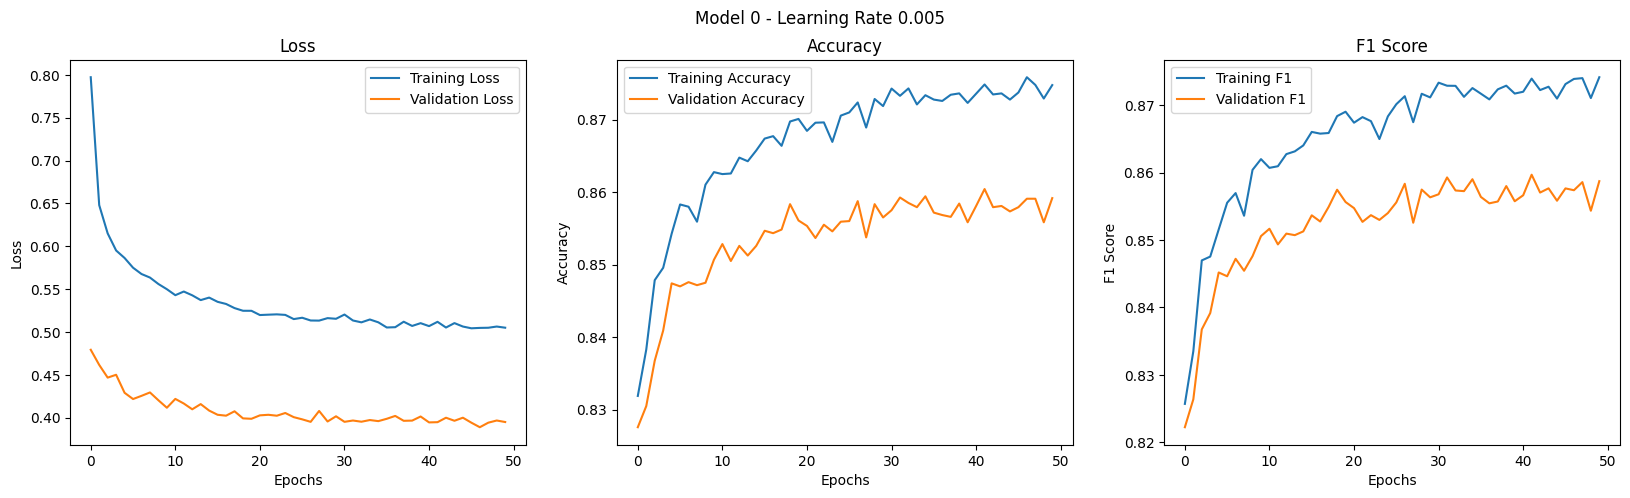

Epoch 1/50: 100%|██████████| 1500/1500 [00:12<00:00, 117.65batch/s]


Epoch 1/50 - Training Loss: 0.4875 - Validation Loss: 0.3890 - Training Accuracy: 0.8775 - Validation Accuracy: 0.8605 - Training F1: 0.8763 - Validation F1: 0.8593


Epoch 2/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.49batch/s]


Epoch 2/50 - Training Loss: 0.4788 - Validation Loss: 0.3869 - Training Accuracy: 0.8780 - Validation Accuracy: 0.8611 - Training F1: 0.8771 - Validation F1: 0.8602


Epoch 3/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.47batch/s]


Epoch 3/50 - Training Loss: 0.4755 - Validation Loss: 0.3890 - Training Accuracy: 0.8779 - Validation Accuracy: 0.8616 - Training F1: 0.8767 - Validation F1: 0.8605


Epoch 4/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.08batch/s]


Epoch 4/50 - Training Loss: 0.4746 - Validation Loss: 0.3878 - Training Accuracy: 0.8781 - Validation Accuracy: 0.8613 - Training F1: 0.8771 - Validation F1: 0.8604


Epoch 5/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.81batch/s]


Epoch 5/50 - Training Loss: 0.4721 - Validation Loss: 0.3855 - Training Accuracy: 0.8787 - Validation Accuracy: 0.8617 - Training F1: 0.8773 - Validation F1: 0.8603


Epoch 6/50: 100%|██████████| 1500/1500 [00:12<00:00, 123.01batch/s]


Epoch 6/50 - Training Loss: 0.4734 - Validation Loss: 0.3862 - Training Accuracy: 0.8786 - Validation Accuracy: 0.8624 - Training F1: 0.8776 - Validation F1: 0.8616


Epoch 7/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.25batch/s]


Epoch 7/50 - Training Loss: 0.4742 - Validation Loss: 0.3857 - Training Accuracy: 0.8791 - Validation Accuracy: 0.8623 - Training F1: 0.8784 - Validation F1: 0.8617


Epoch 8/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.61batch/s]


Epoch 8/50 - Training Loss: 0.4717 - Validation Loss: 0.3854 - Training Accuracy: 0.8794 - Validation Accuracy: 0.8612 - Training F1: 0.8785 - Validation F1: 0.8603


Epoch 9/50: 100%|██████████| 1500/1500 [00:12<00:00, 123.03batch/s]


Epoch 9/50 - Training Loss: 0.4694 - Validation Loss: 0.3866 - Training Accuracy: 0.8788 - Validation Accuracy: 0.8622 - Training F1: 0.8777 - Validation F1: 0.8613


Epoch 10/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.95batch/s]


Epoch 10/50 - Training Loss: 0.4705 - Validation Loss: 0.3855 - Training Accuracy: 0.8783 - Validation Accuracy: 0.8612 - Training F1: 0.8773 - Validation F1: 0.8603


Epoch 11/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.13batch/s]


Epoch 11/50 - Training Loss: 0.4693 - Validation Loss: 0.3860 - Training Accuracy: 0.8794 - Validation Accuracy: 0.8619 - Training F1: 0.8785 - Validation F1: 0.8611


Epoch 12/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.28batch/s]


Epoch 12/50 - Training Loss: 0.4677 - Validation Loss: 0.3835 - Training Accuracy: 0.8802 - Validation Accuracy: 0.8623 - Training F1: 0.8794 - Validation F1: 0.8615


Epoch 13/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.59batch/s]


Epoch 13/50 - Training Loss: 0.4659 - Validation Loss: 0.3869 - Training Accuracy: 0.8789 - Validation Accuracy: 0.8624 - Training F1: 0.8777 - Validation F1: 0.8613


Epoch 14/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.98batch/s]


Epoch 14/50 - Training Loss: 0.4690 - Validation Loss: 0.3873 - Training Accuracy: 0.8794 - Validation Accuracy: 0.8612 - Training F1: 0.8784 - Validation F1: 0.8602


Epoch 15/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.10batch/s]


Epoch 15/50 - Training Loss: 0.4661 - Validation Loss: 0.3848 - Training Accuracy: 0.8799 - Validation Accuracy: 0.8620 - Training F1: 0.8790 - Validation F1: 0.8611


Epoch 16/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.64batch/s]


Epoch 16/50 - Training Loss: 0.4709 - Validation Loss: 0.3829 - Training Accuracy: 0.8799 - Validation Accuracy: 0.8619 - Training F1: 0.8787 - Validation F1: 0.8607


Epoch 17/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.11batch/s]


Epoch 17/50 - Training Loss: 0.4695 - Validation Loss: 0.3810 - Training Accuracy: 0.8805 - Validation Accuracy: 0.8631 - Training F1: 0.8799 - Validation F1: 0.8625


Epoch 18/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.14batch/s]


Epoch 18/50 - Training Loss: 0.4659 - Validation Loss: 0.3868 - Training Accuracy: 0.8804 - Validation Accuracy: 0.8622 - Training F1: 0.8793 - Validation F1: 0.8613


Epoch 19/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.05batch/s]


Epoch 19/50 - Training Loss: 0.4674 - Validation Loss: 0.3847 - Training Accuracy: 0.8807 - Validation Accuracy: 0.8627 - Training F1: 0.8796 - Validation F1: 0.8617


Epoch 20/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.33batch/s]


Epoch 20/50 - Training Loss: 0.4647 - Validation Loss: 0.3859 - Training Accuracy: 0.8798 - Validation Accuracy: 0.8624 - Training F1: 0.8788 - Validation F1: 0.8616


Epoch 21/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.55batch/s]


Epoch 21/50 - Training Loss: 0.4685 - Validation Loss: 0.3854 - Training Accuracy: 0.8802 - Validation Accuracy: 0.8618 - Training F1: 0.8795 - Validation F1: 0.8612


Epoch 22/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.97batch/s]


Epoch 22/50 - Training Loss: 0.4665 - Validation Loss: 0.3874 - Training Accuracy: 0.8803 - Validation Accuracy: 0.8627 - Training F1: 0.8793 - Validation F1: 0.8617


Epoch 23/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.33batch/s]


Epoch 23/50 - Training Loss: 0.4647 - Validation Loss: 0.3840 - Training Accuracy: 0.8805 - Validation Accuracy: 0.8619 - Training F1: 0.8794 - Validation F1: 0.8609


Epoch 24/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.05batch/s]


Epoch 24/50 - Training Loss: 0.4605 - Validation Loss: 0.3837 - Training Accuracy: 0.8809 - Validation Accuracy: 0.8642 - Training F1: 0.8799 - Validation F1: 0.8634


Epoch 25/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.26batch/s]


Epoch 25/50 - Training Loss: 0.4688 - Validation Loss: 0.3851 - Training Accuracy: 0.8806 - Validation Accuracy: 0.8632 - Training F1: 0.8798 - Validation F1: 0.8625


Epoch 26/50: 100%|██████████| 1500/1500 [00:12<00:00, 123.00batch/s]


Epoch 26/50 - Training Loss: 0.4632 - Validation Loss: 0.3841 - Training Accuracy: 0.8813 - Validation Accuracy: 0.8637 - Training F1: 0.8803 - Validation F1: 0.8627


Epoch 27/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.47batch/s]


Epoch 27/50 - Training Loss: 0.4613 - Validation Loss: 0.3860 - Training Accuracy: 0.8806 - Validation Accuracy: 0.8618 - Training F1: 0.8799 - Validation F1: 0.8612


Epoch 28/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.12batch/s]


Epoch 28/50 - Training Loss: 0.4630 - Validation Loss: 0.3801 - Training Accuracy: 0.8814 - Validation Accuracy: 0.8642 - Training F1: 0.8802 - Validation F1: 0.8631


Epoch 29/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.63batch/s]


Epoch 29/50 - Training Loss: 0.4651 - Validation Loss: 0.3834 - Training Accuracy: 0.8806 - Validation Accuracy: 0.8637 - Training F1: 0.8795 - Validation F1: 0.8627


Epoch 30/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.24batch/s]


Epoch 30/50 - Training Loss: 0.4634 - Validation Loss: 0.3805 - Training Accuracy: 0.8814 - Validation Accuracy: 0.8632 - Training F1: 0.8802 - Validation F1: 0.8620


Epoch 31/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.27batch/s]


Epoch 31/50 - Training Loss: 0.4601 - Validation Loss: 0.3844 - Training Accuracy: 0.8813 - Validation Accuracy: 0.8626 - Training F1: 0.8803 - Validation F1: 0.8616


Epoch 32/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.94batch/s]


Epoch 32/50 - Training Loss: 0.4580 - Validation Loss: 0.3842 - Training Accuracy: 0.8807 - Validation Accuracy: 0.8628 - Training F1: 0.8799 - Validation F1: 0.8622


Epoch 33/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.89batch/s]


Epoch 33/50 - Training Loss: 0.4604 - Validation Loss: 0.3841 - Training Accuracy: 0.8817 - Validation Accuracy: 0.8630 - Training F1: 0.8809 - Validation F1: 0.8625


Epoch 34/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.99batch/s]


Epoch 34/50 - Training Loss: 0.4618 - Validation Loss: 0.3844 - Training Accuracy: 0.8805 - Validation Accuracy: 0.8628 - Training F1: 0.8792 - Validation F1: 0.8615


Epoch 35/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.14batch/s]


Epoch 35/50 - Training Loss: 0.4639 - Validation Loss: 0.3836 - Training Accuracy: 0.8814 - Validation Accuracy: 0.8635 - Training F1: 0.8802 - Validation F1: 0.8622


Epoch 36/50: 100%|██████████| 1500/1500 [00:12<00:00, 123.13batch/s]


Epoch 36/50 - Training Loss: 0.4631 - Validation Loss: 0.3846 - Training Accuracy: 0.8822 - Validation Accuracy: 0.8633 - Training F1: 0.8811 - Validation F1: 0.8623


Epoch 37/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.08batch/s]


Epoch 37/50 - Training Loss: 0.4593 - Validation Loss: 0.3813 - Training Accuracy: 0.8812 - Validation Accuracy: 0.8637 - Training F1: 0.8798 - Validation F1: 0.8624


Epoch 38/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.07batch/s]


Epoch 38/50 - Training Loss: 0.4587 - Validation Loss: 0.3829 - Training Accuracy: 0.8816 - Validation Accuracy: 0.8619 - Training F1: 0.8807 - Validation F1: 0.8610


Epoch 39/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.13batch/s]


Epoch 39/50 - Training Loss: 0.4608 - Validation Loss: 0.3866 - Training Accuracy: 0.8812 - Validation Accuracy: 0.8634 - Training F1: 0.8800 - Validation F1: 0.8623


Epoch 40/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.25batch/s]


Epoch 40/50 - Training Loss: 0.4629 - Validation Loss: 0.3830 - Training Accuracy: 0.8816 - Validation Accuracy: 0.8628 - Training F1: 0.8805 - Validation F1: 0.8617


Epoch 41/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.15batch/s]


Epoch 41/50 - Training Loss: 0.4573 - Validation Loss: 0.3847 - Training Accuracy: 0.8816 - Validation Accuracy: 0.8636 - Training F1: 0.8807 - Validation F1: 0.8628


Epoch 42/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.10batch/s]


Epoch 42/50 - Training Loss: 0.4619 - Validation Loss: 0.3828 - Training Accuracy: 0.8822 - Validation Accuracy: 0.8635 - Training F1: 0.8812 - Validation F1: 0.8626


Epoch 43/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.79batch/s]


Epoch 43/50 - Training Loss: 0.4561 - Validation Loss: 0.3823 - Training Accuracy: 0.8822 - Validation Accuracy: 0.8641 - Training F1: 0.8819 - Validation F1: 0.8639


Epoch 44/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.18batch/s]


Epoch 44/50 - Training Loss: 0.4596 - Validation Loss: 0.3828 - Training Accuracy: 0.8819 - Validation Accuracy: 0.8632 - Training F1: 0.8809 - Validation F1: 0.8623


Epoch 45/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.32batch/s]


Epoch 45/50 - Training Loss: 0.4589 - Validation Loss: 0.3870 - Training Accuracy: 0.8811 - Validation Accuracy: 0.8623 - Training F1: 0.8800 - Validation F1: 0.8614


Epoch 46/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.76batch/s]


Epoch 46/50 - Training Loss: 0.4624 - Validation Loss: 0.3825 - Training Accuracy: 0.8825 - Validation Accuracy: 0.8642 - Training F1: 0.8815 - Validation F1: 0.8634


Epoch 47/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.54batch/s]


Epoch 47/50 - Training Loss: 0.4603 - Validation Loss: 0.3834 - Training Accuracy: 0.8816 - Validation Accuracy: 0.8630 - Training F1: 0.8806 - Validation F1: 0.8621


Epoch 48/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.98batch/s]


Epoch 48/50 - Training Loss: 0.4607 - Validation Loss: 0.3808 - Training Accuracy: 0.8818 - Validation Accuracy: 0.8630 - Training F1: 0.8807 - Validation F1: 0.8619


Epoch 49/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.33batch/s]


Epoch 49/50 - Training Loss: 0.4556 - Validation Loss: 0.3835 - Training Accuracy: 0.8824 - Validation Accuracy: 0.8628 - Training F1: 0.8812 - Validation F1: 0.8617


Epoch 50/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.40batch/s]


Epoch 50/50 - Training Loss: 0.4593 - Validation Loss: 0.3818 - Training Accuracy: 0.8824 - Validation Accuracy: 0.8632 - Training F1: 0.8817 - Validation F1: 0.8626


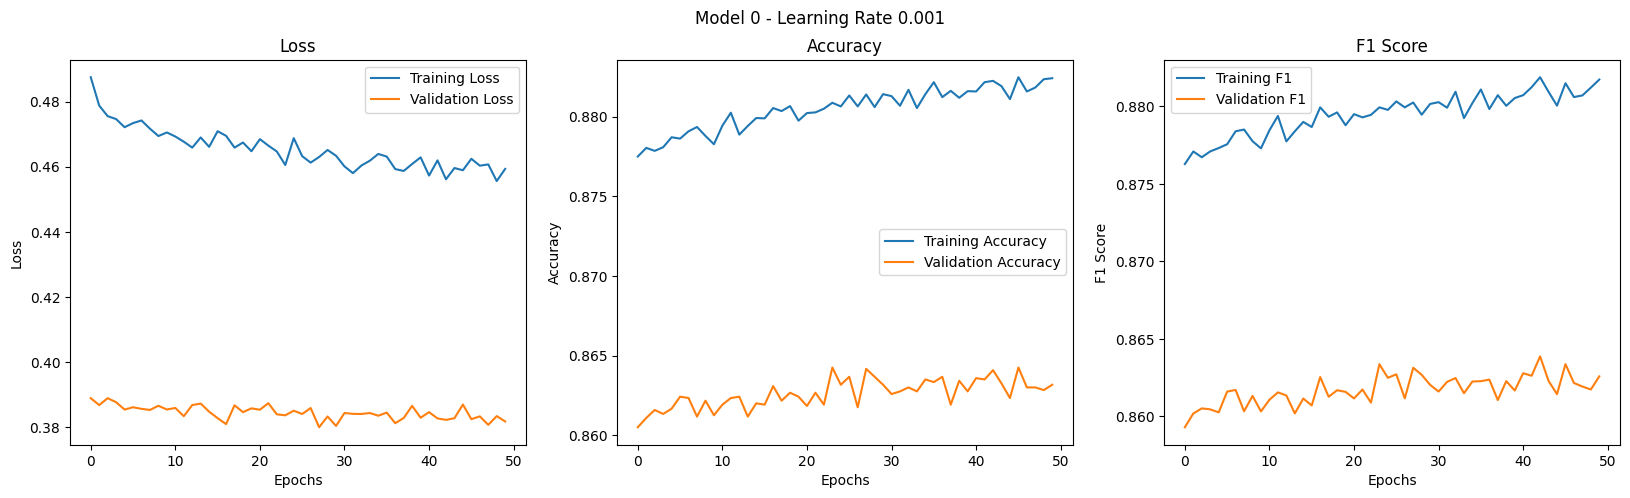

Epoch 1/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.62batch/s]


Epoch 1/50 - Training Loss: 0.4566 - Validation Loss: 0.3818 - Training Accuracy: 0.8822 - Validation Accuracy: 0.8638 - Training F1: 0.8810 - Validation F1: 0.8627


Epoch 2/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.76batch/s]


Epoch 2/50 - Training Loss: 0.4518 - Validation Loss: 0.3827 - Training Accuracy: 0.8820 - Validation Accuracy: 0.8641 - Training F1: 0.8809 - Validation F1: 0.8631


Epoch 3/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.63batch/s]


Epoch 3/50 - Training Loss: 0.4541 - Validation Loss: 0.3816 - Training Accuracy: 0.8829 - Validation Accuracy: 0.8638 - Training F1: 0.8819 - Validation F1: 0.8628


Epoch 4/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.19batch/s]


Epoch 4/50 - Training Loss: 0.4513 - Validation Loss: 0.3801 - Training Accuracy: 0.8829 - Validation Accuracy: 0.8652 - Training F1: 0.8820 - Validation F1: 0.8644


Epoch 5/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.14batch/s]


Epoch 5/50 - Training Loss: 0.4521 - Validation Loss: 0.3798 - Training Accuracy: 0.8830 - Validation Accuracy: 0.8648 - Training F1: 0.8820 - Validation F1: 0.8640


Epoch 6/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.43batch/s]


Epoch 6/50 - Training Loss: 0.4560 - Validation Loss: 0.3808 - Training Accuracy: 0.8831 - Validation Accuracy: 0.8638 - Training F1: 0.8823 - Validation F1: 0.8630


Epoch 7/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.65batch/s]


Epoch 7/50 - Training Loss: 0.4543 - Validation Loss: 0.3820 - Training Accuracy: 0.8828 - Validation Accuracy: 0.8636 - Training F1: 0.8819 - Validation F1: 0.8627


Epoch 8/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.43batch/s]


Epoch 8/50 - Training Loss: 0.4520 - Validation Loss: 0.3815 - Training Accuracy: 0.8834 - Validation Accuracy: 0.8642 - Training F1: 0.8823 - Validation F1: 0.8633


Epoch 9/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.99batch/s]


Epoch 9/50 - Training Loss: 0.4505 - Validation Loss: 0.3795 - Training Accuracy: 0.8834 - Validation Accuracy: 0.8639 - Training F1: 0.8825 - Validation F1: 0.8631


Epoch 10/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.63batch/s]


Epoch 10/50 - Training Loss: 0.4556 - Validation Loss: 0.3814 - Training Accuracy: 0.8829 - Validation Accuracy: 0.8644 - Training F1: 0.8820 - Validation F1: 0.8636


Epoch 11/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.91batch/s]


Epoch 11/50 - Training Loss: 0.4539 - Validation Loss: 0.3820 - Training Accuracy: 0.8834 - Validation Accuracy: 0.8640 - Training F1: 0.8826 - Validation F1: 0.8632


Epoch 12/50: 100%|██████████| 1500/1500 [00:12<00:00, 119.19batch/s]


Epoch 12/50 - Training Loss: 0.4488 - Validation Loss: 0.3796 - Training Accuracy: 0.8836 - Validation Accuracy: 0.8640 - Training F1: 0.8826 - Validation F1: 0.8630


Epoch 13/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.25batch/s]


Epoch 13/50 - Training Loss: 0.4549 - Validation Loss: 0.3808 - Training Accuracy: 0.8840 - Validation Accuracy: 0.8645 - Training F1: 0.8830 - Validation F1: 0.8636


Epoch 14/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.15batch/s]


Epoch 14/50 - Training Loss: 0.4486 - Validation Loss: 0.3818 - Training Accuracy: 0.8836 - Validation Accuracy: 0.8638 - Training F1: 0.8825 - Validation F1: 0.8628


Epoch 15/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.41batch/s]


Epoch 15/50 - Training Loss: 0.4529 - Validation Loss: 0.3829 - Training Accuracy: 0.8827 - Validation Accuracy: 0.8632 - Training F1: 0.8820 - Validation F1: 0.8626


Epoch 16/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.58batch/s]


Epoch 16/50 - Training Loss: 0.4498 - Validation Loss: 0.3820 - Training Accuracy: 0.8835 - Validation Accuracy: 0.8632 - Training F1: 0.8825 - Validation F1: 0.8622


Epoch 17/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.70batch/s]


Epoch 17/50 - Training Loss: 0.4515 - Validation Loss: 0.3833 - Training Accuracy: 0.8828 - Validation Accuracy: 0.8632 - Training F1: 0.8816 - Validation F1: 0.8620


Epoch 18/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.57batch/s]


Epoch 18/50 - Training Loss: 0.4516 - Validation Loss: 0.3811 - Training Accuracy: 0.8833 - Validation Accuracy: 0.8642 - Training F1: 0.8822 - Validation F1: 0.8633


Epoch 19/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.65batch/s]


Epoch 19/50 - Training Loss: 0.4511 - Validation Loss: 0.3812 - Training Accuracy: 0.8837 - Validation Accuracy: 0.8630 - Training F1: 0.8827 - Validation F1: 0.8620


Epoch 20/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.53batch/s]


Epoch 20/50 - Training Loss: 0.4486 - Validation Loss: 0.3822 - Training Accuracy: 0.8829 - Validation Accuracy: 0.8632 - Training F1: 0.8819 - Validation F1: 0.8624


Epoch 21/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.76batch/s]


Epoch 21/50 - Training Loss: 0.4519 - Validation Loss: 0.3809 - Training Accuracy: 0.8832 - Validation Accuracy: 0.8628 - Training F1: 0.8822 - Validation F1: 0.8620


Epoch 22/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.20batch/s]


Epoch 22/50 - Training Loss: 0.4464 - Validation Loss: 0.3817 - Training Accuracy: 0.8834 - Validation Accuracy: 0.8631 - Training F1: 0.8824 - Validation F1: 0.8622


Epoch 23/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.89batch/s]


Epoch 23/50 - Training Loss: 0.4458 - Validation Loss: 0.3826 - Training Accuracy: 0.8838 - Validation Accuracy: 0.8646 - Training F1: 0.8830 - Validation F1: 0.8639


Epoch 24/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.23batch/s]


Epoch 24/50 - Training Loss: 0.4491 - Validation Loss: 0.3811 - Training Accuracy: 0.8832 - Validation Accuracy: 0.8642 - Training F1: 0.8824 - Validation F1: 0.8634


Epoch 25/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.73batch/s]


Epoch 25/50 - Training Loss: 0.4507 - Validation Loss: 0.3833 - Training Accuracy: 0.8835 - Validation Accuracy: 0.8642 - Training F1: 0.8827 - Validation F1: 0.8636


Epoch 26/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.44batch/s]


Epoch 26/50 - Training Loss: 0.4516 - Validation Loss: 0.3811 - Training Accuracy: 0.8842 - Validation Accuracy: 0.8645 - Training F1: 0.8836 - Validation F1: 0.8639


Epoch 27/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.16batch/s]


Epoch 27/50 - Training Loss: 0.4501 - Validation Loss: 0.3827 - Training Accuracy: 0.8840 - Validation Accuracy: 0.8634 - Training F1: 0.8830 - Validation F1: 0.8623


Epoch 28/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.77batch/s]


Epoch 28/50 - Training Loss: 0.4496 - Validation Loss: 0.3823 - Training Accuracy: 0.8843 - Validation Accuracy: 0.8639 - Training F1: 0.8833 - Validation F1: 0.8629


Epoch 29/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.89batch/s]


Epoch 29/50 - Training Loss: 0.4487 - Validation Loss: 0.3822 - Training Accuracy: 0.8833 - Validation Accuracy: 0.8643 - Training F1: 0.8819 - Validation F1: 0.8629


Epoch 30/50: 100%|██████████| 1500/1500 [00:12<00:00, 123.07batch/s]


Epoch 30/50 - Training Loss: 0.4460 - Validation Loss: 0.3819 - Training Accuracy: 0.8837 - Validation Accuracy: 0.8644 - Training F1: 0.8827 - Validation F1: 0.8633


Epoch 31/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.82batch/s]


Epoch 31/50 - Training Loss: 0.4522 - Validation Loss: 0.3823 - Training Accuracy: 0.8835 - Validation Accuracy: 0.8649 - Training F1: 0.8824 - Validation F1: 0.8640


Epoch 32/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.26batch/s]


Epoch 32/50 - Training Loss: 0.4471 - Validation Loss: 0.3816 - Training Accuracy: 0.8844 - Validation Accuracy: 0.8642 - Training F1: 0.8833 - Validation F1: 0.8631


Epoch 33/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.71batch/s]


Epoch 33/50 - Training Loss: 0.4497 - Validation Loss: 0.3845 - Training Accuracy: 0.8838 - Validation Accuracy: 0.8632 - Training F1: 0.8829 - Validation F1: 0.8622


Epoch 34/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.21batch/s]


Epoch 34/50 - Training Loss: 0.4472 - Validation Loss: 0.3804 - Training Accuracy: 0.8844 - Validation Accuracy: 0.8648 - Training F1: 0.8835 - Validation F1: 0.8639


Epoch 35/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.26batch/s]


Epoch 35/50 - Training Loss: 0.4484 - Validation Loss: 0.3810 - Training Accuracy: 0.8841 - Validation Accuracy: 0.8644 - Training F1: 0.8831 - Validation F1: 0.8635


Epoch 36/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.03batch/s]


Epoch 36/50 - Training Loss: 0.4493 - Validation Loss: 0.3800 - Training Accuracy: 0.8841 - Validation Accuracy: 0.8642 - Training F1: 0.8831 - Validation F1: 0.8633


Epoch 37/50: 100%|██████████| 1500/1500 [00:12<00:00, 119.17batch/s]


Epoch 37/50 - Training Loss: 0.4492 - Validation Loss: 0.3796 - Training Accuracy: 0.8845 - Validation Accuracy: 0.8648 - Training F1: 0.8836 - Validation F1: 0.8640


Epoch 38/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.25batch/s]


Epoch 38/50 - Training Loss: 0.4470 - Validation Loss: 0.3815 - Training Accuracy: 0.8843 - Validation Accuracy: 0.8638 - Training F1: 0.8834 - Validation F1: 0.8631


Epoch 39/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.23batch/s]


Epoch 39/50 - Training Loss: 0.4494 - Validation Loss: 0.3800 - Training Accuracy: 0.8843 - Validation Accuracy: 0.8638 - Training F1: 0.8832 - Validation F1: 0.8629


Epoch 40/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.20batch/s]


Epoch 40/50 - Training Loss: 0.4511 - Validation Loss: 0.3802 - Training Accuracy: 0.8838 - Validation Accuracy: 0.8642 - Training F1: 0.8827 - Validation F1: 0.8631


Epoch 41/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.26batch/s]


Epoch 41/50 - Training Loss: 0.4473 - Validation Loss: 0.3817 - Training Accuracy: 0.8838 - Validation Accuracy: 0.8641 - Training F1: 0.8826 - Validation F1: 0.8629


Epoch 42/50: 100%|██████████| 1500/1500 [00:12<00:00, 119.81batch/s]


Epoch 42/50 - Training Loss: 0.4525 - Validation Loss: 0.3824 - Training Accuracy: 0.8835 - Validation Accuracy: 0.8640 - Training F1: 0.8822 - Validation F1: 0.8628


Epoch 43/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.38batch/s]


Epoch 43/50 - Training Loss: 0.4489 - Validation Loss: 0.3802 - Training Accuracy: 0.8843 - Validation Accuracy: 0.8638 - Training F1: 0.8831 - Validation F1: 0.8628


Epoch 44/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.92batch/s]


Epoch 44/50 - Training Loss: 0.4438 - Validation Loss: 0.3806 - Training Accuracy: 0.8848 - Validation Accuracy: 0.8648 - Training F1: 0.8841 - Validation F1: 0.8642


Epoch 45/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.94batch/s]


Epoch 45/50 - Training Loss: 0.4457 - Validation Loss: 0.3822 - Training Accuracy: 0.8835 - Validation Accuracy: 0.8635 - Training F1: 0.8821 - Validation F1: 0.8623


Epoch 46/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.81batch/s]


Epoch 46/50 - Training Loss: 0.4505 - Validation Loss: 0.3796 - Training Accuracy: 0.8848 - Validation Accuracy: 0.8654 - Training F1: 0.8838 - Validation F1: 0.8645


Epoch 47/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.72batch/s]


Epoch 47/50 - Training Loss: 0.4506 - Validation Loss: 0.3821 - Training Accuracy: 0.8843 - Validation Accuracy: 0.8635 - Training F1: 0.8830 - Validation F1: 0.8622


Epoch 48/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.01batch/s]


Epoch 48/50 - Training Loss: 0.4496 - Validation Loss: 0.3806 - Training Accuracy: 0.8849 - Validation Accuracy: 0.8640 - Training F1: 0.8840 - Validation F1: 0.8631


Epoch 49/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.18batch/s]


Epoch 49/50 - Training Loss: 0.4464 - Validation Loss: 0.3792 - Training Accuracy: 0.8844 - Validation Accuracy: 0.8638 - Training F1: 0.8830 - Validation F1: 0.8626


Epoch 50/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.47batch/s]


Epoch 50/50 - Training Loss: 0.4493 - Validation Loss: 0.3802 - Training Accuracy: 0.8849 - Validation Accuracy: 0.8649 - Training F1: 0.8837 - Validation F1: 0.8638


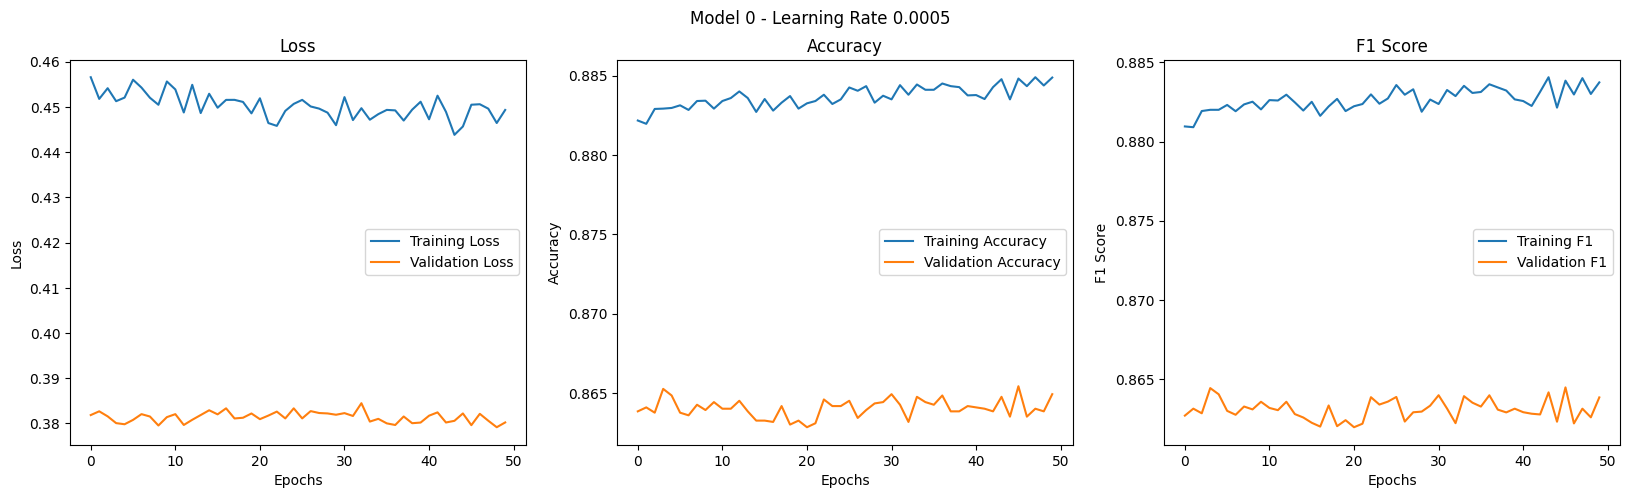

Epoch 1/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.19batch/s]


Epoch 1/50 - Training Loss: 0.4417 - Validation Loss: 0.3796 - Training Accuracy: 0.8845 - Validation Accuracy: 0.8640 - Training F1: 0.8833 - Validation F1: 0.8627


Epoch 2/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.88batch/s]


Epoch 2/50 - Training Loss: 0.4459 - Validation Loss: 0.3788 - Training Accuracy: 0.8854 - Validation Accuracy: 0.8638 - Training F1: 0.8844 - Validation F1: 0.8628


Epoch 3/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.64batch/s]


Epoch 3/50 - Training Loss: 0.4477 - Validation Loss: 0.3787 - Training Accuracy: 0.8850 - Validation Accuracy: 0.8646 - Training F1: 0.8840 - Validation F1: 0.8636


Epoch 4/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.94batch/s]


Epoch 4/50 - Training Loss: 0.4474 - Validation Loss: 0.3805 - Training Accuracy: 0.8848 - Validation Accuracy: 0.8651 - Training F1: 0.8835 - Validation F1: 0.8638


Epoch 5/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.72batch/s]


Epoch 5/50 - Training Loss: 0.4428 - Validation Loss: 0.3791 - Training Accuracy: 0.8848 - Validation Accuracy: 0.8648 - Training F1: 0.8836 - Validation F1: 0.8637


Epoch 6/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.25batch/s]


Epoch 6/50 - Training Loss: 0.4394 - Validation Loss: 0.3795 - Training Accuracy: 0.8849 - Validation Accuracy: 0.8639 - Training F1: 0.8840 - Validation F1: 0.8630


Epoch 7/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.85batch/s]


Epoch 7/50 - Training Loss: 0.4439 - Validation Loss: 0.3799 - Training Accuracy: 0.8849 - Validation Accuracy: 0.8648 - Training F1: 0.8836 - Validation F1: 0.8635


Epoch 8/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.29batch/s]


Epoch 8/50 - Training Loss: 0.4444 - Validation Loss: 0.3812 - Training Accuracy: 0.8849 - Validation Accuracy: 0.8642 - Training F1: 0.8836 - Validation F1: 0.8630


Epoch 9/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.69batch/s]


Epoch 9/50 - Training Loss: 0.4459 - Validation Loss: 0.3804 - Training Accuracy: 0.8848 - Validation Accuracy: 0.8643 - Training F1: 0.8835 - Validation F1: 0.8632


Epoch 10/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.53batch/s]


Epoch 10/50 - Training Loss: 0.4438 - Validation Loss: 0.3800 - Training Accuracy: 0.8849 - Validation Accuracy: 0.8637 - Training F1: 0.8835 - Validation F1: 0.8623


Epoch 11/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.61batch/s]


Epoch 11/50 - Training Loss: 0.4452 - Validation Loss: 0.3784 - Training Accuracy: 0.8847 - Validation Accuracy: 0.8647 - Training F1: 0.8833 - Validation F1: 0.8633


Epoch 12/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.58batch/s]


Epoch 12/50 - Training Loss: 0.4417 - Validation Loss: 0.3800 - Training Accuracy: 0.8853 - Validation Accuracy: 0.8651 - Training F1: 0.8841 - Validation F1: 0.8640


Epoch 13/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.39batch/s]


Epoch 13/50 - Training Loss: 0.4427 - Validation Loss: 0.3797 - Training Accuracy: 0.8850 - Validation Accuracy: 0.8644 - Training F1: 0.8838 - Validation F1: 0.8633


Epoch 14/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.91batch/s]


Epoch 14/50 - Training Loss: 0.4409 - Validation Loss: 0.3796 - Training Accuracy: 0.8851 - Validation Accuracy: 0.8646 - Training F1: 0.8837 - Validation F1: 0.8633


Epoch 15/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.63batch/s]


Epoch 15/50 - Training Loss: 0.4438 - Validation Loss: 0.3801 - Training Accuracy: 0.8850 - Validation Accuracy: 0.8638 - Training F1: 0.8839 - Validation F1: 0.8627


Epoch 16/50: 100%|██████████| 1500/1500 [00:12<00:00, 121.14batch/s]


Epoch 16/50 - Training Loss: 0.4444 - Validation Loss: 0.3796 - Training Accuracy: 0.8846 - Validation Accuracy: 0.8651 - Training F1: 0.8834 - Validation F1: 0.8639


Epoch 17/50: 100%|██████████| 1500/1500 [00:12<00:00, 122.11batch/s]


Epoch 17/50 - Training Loss: 0.4441 - Validation Loss: 0.3791 - Training Accuracy: 0.8853 - Validation Accuracy: 0.8647 - Training F1: 0.8842 - Validation F1: 0.8636


Epoch 18/50: 100%|██████████| 1500/1500 [00:12<00:00, 119.56batch/s]


Epoch 18/50 - Training Loss: 0.4435 - Validation Loss: 0.3792 - Training Accuracy: 0.8851 - Validation Accuracy: 0.8644 - Training F1: 0.8840 - Validation F1: 0.8633


Epoch 19/50: 100%|██████████| 1500/1500 [00:12<00:00, 120.69batch/s]


Epoch 19/50 - Training Loss: 0.4453 - Validation Loss: 0.3802 - Training Accuracy: 0.8852 - Validation Accuracy: 0.8646 - Training F1: 0.8842 - Validation F1: 0.8636


Epoch 20/50: 100%|██████████| 1500/1500 [00:12<00:00, 123.55batch/s]


Epoch 20/50 - Training Loss: 0.4429 - Validation Loss: 0.3794 - Training Accuracy: 0.8847 - Validation Accuracy: 0.8643 - Training F1: 0.8832 - Validation F1: 0.8629


Epoch 21/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.08batch/s]


Epoch 21/50 - Training Loss: 0.4421 - Validation Loss: 0.3791 - Training Accuracy: 0.8855 - Validation Accuracy: 0.8648 - Training F1: 0.8844 - Validation F1: 0.8637


Epoch 22/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.33batch/s]


Epoch 22/50 - Training Loss: 0.4443 - Validation Loss: 0.3804 - Training Accuracy: 0.8847 - Validation Accuracy: 0.8638 - Training F1: 0.8834 - Validation F1: 0.8626


Epoch 23/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.97batch/s]


Epoch 23/50 - Training Loss: 0.4451 - Validation Loss: 0.3783 - Training Accuracy: 0.8853 - Validation Accuracy: 0.8647 - Training F1: 0.8840 - Validation F1: 0.8635


Epoch 24/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.19batch/s]


Epoch 24/50 - Training Loss: 0.4415 - Validation Loss: 0.3786 - Training Accuracy: 0.8848 - Validation Accuracy: 0.8648 - Training F1: 0.8836 - Validation F1: 0.8636


Epoch 25/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.22batch/s]


Epoch 25/50 - Training Loss: 0.4442 - Validation Loss: 0.3788 - Training Accuracy: 0.8849 - Validation Accuracy: 0.8649 - Training F1: 0.8837 - Validation F1: 0.8638


Epoch 26/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.98batch/s]


Epoch 26/50 - Training Loss: 0.4419 - Validation Loss: 0.3805 - Training Accuracy: 0.8850 - Validation Accuracy: 0.8645 - Training F1: 0.8837 - Validation F1: 0.8632


Epoch 27/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.63batch/s]


Epoch 27/50 - Training Loss: 0.4402 - Validation Loss: 0.3796 - Training Accuracy: 0.8850 - Validation Accuracy: 0.8654 - Training F1: 0.8839 - Validation F1: 0.8643


Epoch 28/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.22batch/s]


Epoch 28/50 - Training Loss: 0.4416 - Validation Loss: 0.3798 - Training Accuracy: 0.8854 - Validation Accuracy: 0.8642 - Training F1: 0.8842 - Validation F1: 0.8631


Epoch 29/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.15batch/s]


Epoch 29/50 - Training Loss: 0.4472 - Validation Loss: 0.3803 - Training Accuracy: 0.8845 - Validation Accuracy: 0.8641 - Training F1: 0.8832 - Validation F1: 0.8628


Epoch 30/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.12batch/s]


Epoch 30/50 - Training Loss: 0.4450 - Validation Loss: 0.3799 - Training Accuracy: 0.8851 - Validation Accuracy: 0.8642 - Training F1: 0.8840 - Validation F1: 0.8631


Epoch 31/50: 100%|██████████| 1500/1500 [00:12<00:00, 123.72batch/s]


Epoch 31/50 - Training Loss: 0.4435 - Validation Loss: 0.3802 - Training Accuracy: 0.8849 - Validation Accuracy: 0.8645 - Training F1: 0.8838 - Validation F1: 0.8633


Epoch 32/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.84batch/s]


Epoch 32/50 - Training Loss: 0.4435 - Validation Loss: 0.3794 - Training Accuracy: 0.8845 - Validation Accuracy: 0.8636 - Training F1: 0.8830 - Validation F1: 0.8621


Epoch 33/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.47batch/s]


Epoch 33/50 - Training Loss: 0.4418 - Validation Loss: 0.3808 - Training Accuracy: 0.8847 - Validation Accuracy: 0.8635 - Training F1: 0.8834 - Validation F1: 0.8622


Epoch 34/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.91batch/s]


Epoch 34/50 - Training Loss: 0.4453 - Validation Loss: 0.3796 - Training Accuracy: 0.8852 - Validation Accuracy: 0.8642 - Training F1: 0.8839 - Validation F1: 0.8631


Epoch 35/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.73batch/s]


Epoch 35/50 - Training Loss: 0.4472 - Validation Loss: 0.3788 - Training Accuracy: 0.8846 - Validation Accuracy: 0.8642 - Training F1: 0.8833 - Validation F1: 0.8629


Epoch 36/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.34batch/s]


Epoch 36/50 - Training Loss: 0.4408 - Validation Loss: 0.3802 - Training Accuracy: 0.8844 - Validation Accuracy: 0.8644 - Training F1: 0.8832 - Validation F1: 0.8633


Epoch 37/50: 100%|██████████| 1500/1500 [00:12<00:00, 125.00batch/s]


Epoch 37/50 - Training Loss: 0.4423 - Validation Loss: 0.3800 - Training Accuracy: 0.8851 - Validation Accuracy: 0.8652 - Training F1: 0.8839 - Validation F1: 0.8641


Epoch 38/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.29batch/s]


Epoch 38/50 - Training Loss: 0.4441 - Validation Loss: 0.3793 - Training Accuracy: 0.8849 - Validation Accuracy: 0.8649 - Training F1: 0.8836 - Validation F1: 0.8637


Epoch 39/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.99batch/s]


Epoch 39/50 - Training Loss: 0.4446 - Validation Loss: 0.3791 - Training Accuracy: 0.8854 - Validation Accuracy: 0.8645 - Training F1: 0.8843 - Validation F1: 0.8633


Epoch 40/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.21batch/s]


Epoch 40/50 - Training Loss: 0.4436 - Validation Loss: 0.3780 - Training Accuracy: 0.8852 - Validation Accuracy: 0.8642 - Training F1: 0.8842 - Validation F1: 0.8634


Epoch 41/50: 100%|██████████| 1500/1500 [00:12<00:00, 123.75batch/s]


Epoch 41/50 - Training Loss: 0.4408 - Validation Loss: 0.3793 - Training Accuracy: 0.8851 - Validation Accuracy: 0.8651 - Training F1: 0.8839 - Validation F1: 0.8639


Epoch 42/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.83batch/s]


Epoch 42/50 - Training Loss: 0.4454 - Validation Loss: 0.3809 - Training Accuracy: 0.8854 - Validation Accuracy: 0.8651 - Training F1: 0.8842 - Validation F1: 0.8639


Epoch 43/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.60batch/s]


Epoch 43/50 - Training Loss: 0.4451 - Validation Loss: 0.3785 - Training Accuracy: 0.8851 - Validation Accuracy: 0.8652 - Training F1: 0.8838 - Validation F1: 0.8640


Epoch 44/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.42batch/s]


Epoch 44/50 - Training Loss: 0.4445 - Validation Loss: 0.3792 - Training Accuracy: 0.8851 - Validation Accuracy: 0.8643 - Training F1: 0.8837 - Validation F1: 0.8630


Epoch 45/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.01batch/s]


Epoch 45/50 - Training Loss: 0.4449 - Validation Loss: 0.3779 - Training Accuracy: 0.8852 - Validation Accuracy: 0.8652 - Training F1: 0.8841 - Validation F1: 0.8641


Epoch 46/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.67batch/s]


Epoch 46/50 - Training Loss: 0.4404 - Validation Loss: 0.3796 - Training Accuracy: 0.8849 - Validation Accuracy: 0.8652 - Training F1: 0.8835 - Validation F1: 0.8638


Epoch 47/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.42batch/s]


Epoch 47/50 - Training Loss: 0.4424 - Validation Loss: 0.3790 - Training Accuracy: 0.8853 - Validation Accuracy: 0.8647 - Training F1: 0.8841 - Validation F1: 0.8634


Epoch 48/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.53batch/s]


Epoch 48/50 - Training Loss: 0.4446 - Validation Loss: 0.3787 - Training Accuracy: 0.8854 - Validation Accuracy: 0.8647 - Training F1: 0.8843 - Validation F1: 0.8636


Epoch 49/50: 100%|██████████| 1500/1500 [00:11<00:00, 125.59batch/s]


Epoch 49/50 - Training Loss: 0.4420 - Validation Loss: 0.3793 - Training Accuracy: 0.8852 - Validation Accuracy: 0.8654 - Training F1: 0.8840 - Validation F1: 0.8643


Epoch 50/50: 100%|██████████| 1500/1500 [00:12<00:00, 124.45batch/s]


Epoch 50/50 - Training Loss: 0.4432 - Validation Loss: 0.3799 - Training Accuracy: 0.8855 - Validation Accuracy: 0.8642 - Training F1: 0.8845 - Validation F1: 0.8632


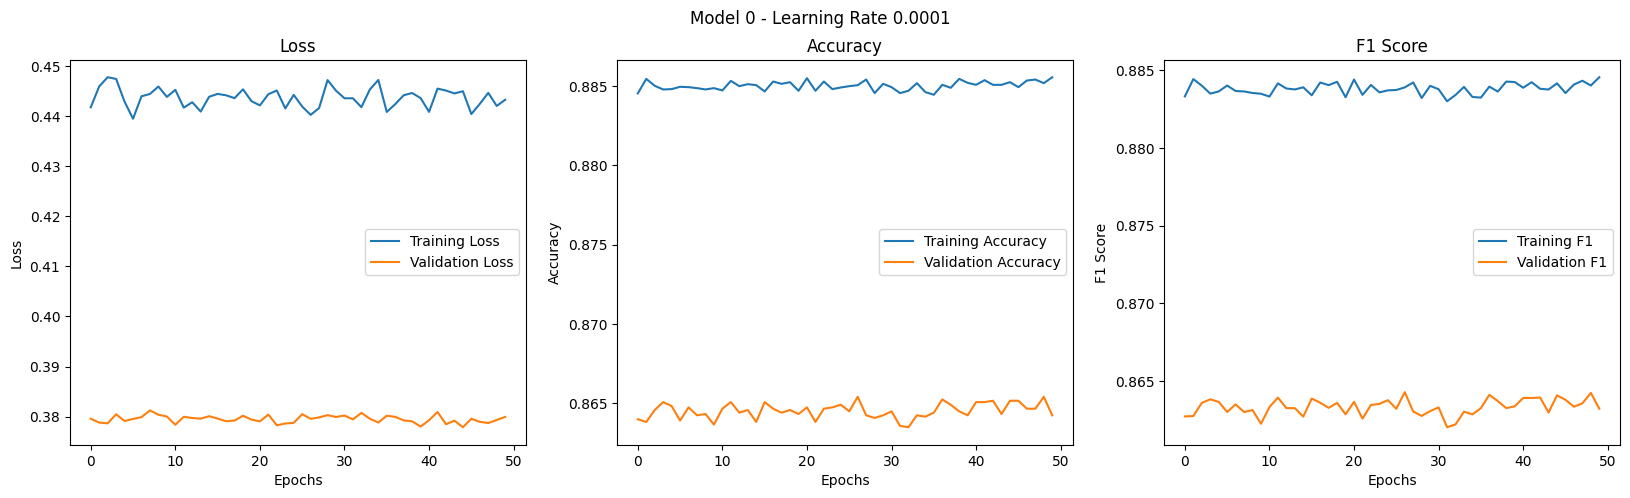

Epoch 1/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.38batch/s]


Epoch 1/50 - Training Loss: 0.6722 - Validation Loss: 0.4413 - Training Accuracy: 0.8446 - Validation Accuracy: 0.8397 - Training F1: 0.8396 - Validation F1: 0.8355


Epoch 2/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.71batch/s]


Epoch 2/50 - Training Loss: 0.5339 - Validation Loss: 0.4209 - Training Accuracy: 0.8554 - Validation Accuracy: 0.8473 - Training F1: 0.8517 - Validation F1: 0.8441


Epoch 3/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.62batch/s]


Epoch 3/50 - Training Loss: 0.5091 - Validation Loss: 0.4112 - Training Accuracy: 0.8571 - Validation Accuracy: 0.8525 - Training F1: 0.8556 - Validation F1: 0.8517


Epoch 4/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.99batch/s]


Epoch 4/50 - Training Loss: 0.4927 - Validation Loss: 0.3978 - Training Accuracy: 0.8655 - Validation Accuracy: 0.8583 - Training F1: 0.8633 - Validation F1: 0.8569


Epoch 5/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.05batch/s]


Epoch 5/50 - Training Loss: 0.4838 - Validation Loss: 0.3924 - Training Accuracy: 0.8667 - Validation Accuracy: 0.8590 - Training F1: 0.8640 - Validation F1: 0.8569


Epoch 6/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.77batch/s]


Epoch 6/50 - Training Loss: 0.4761 - Validation Loss: 0.4057 - Training Accuracy: 0.8616 - Validation Accuracy: 0.8532 - Training F1: 0.8590 - Validation F1: 0.8513


Epoch 7/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.21batch/s]


Epoch 7/50 - Training Loss: 0.4668 - Validation Loss: 0.3833 - Training Accuracy: 0.8717 - Validation Accuracy: 0.8611 - Training F1: 0.8696 - Validation F1: 0.8596


Epoch 8/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.55batch/s]


Epoch 8/50 - Training Loss: 0.4615 - Validation Loss: 0.3871 - Training Accuracy: 0.8724 - Validation Accuracy: 0.8620 - Training F1: 0.8710 - Validation F1: 0.8611


Epoch 9/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.02batch/s]


Epoch 9/50 - Training Loss: 0.4589 - Validation Loss: 0.3780 - Training Accuracy: 0.8738 - Validation Accuracy: 0.8623 - Training F1: 0.8739 - Validation F1: 0.8630


Epoch 10/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.50batch/s]


Epoch 10/50 - Training Loss: 0.4518 - Validation Loss: 0.3762 - Training Accuracy: 0.8746 - Validation Accuracy: 0.8639 - Training F1: 0.8735 - Validation F1: 0.8631


Epoch 11/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.28batch/s]


Epoch 11/50 - Training Loss: 0.4490 - Validation Loss: 0.3850 - Training Accuracy: 0.8726 - Validation Accuracy: 0.8613 - Training F1: 0.8709 - Validation F1: 0.8603


Epoch 12/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.65batch/s]


Epoch 12/50 - Training Loss: 0.4446 - Validation Loss: 0.3757 - Training Accuracy: 0.8779 - Validation Accuracy: 0.8648 - Training F1: 0.8777 - Validation F1: 0.8648


Epoch 13/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.29batch/s]


Epoch 13/50 - Training Loss: 0.4408 - Validation Loss: 0.3760 - Training Accuracy: 0.8770 - Validation Accuracy: 0.8658 - Training F1: 0.8765 - Validation F1: 0.8656


Epoch 14/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.68batch/s]


Epoch 14/50 - Training Loss: 0.4354 - Validation Loss: 0.3776 - Training Accuracy: 0.8758 - Validation Accuracy: 0.8647 - Training F1: 0.8757 - Validation F1: 0.8650


Epoch 15/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.41batch/s]


Epoch 15/50 - Training Loss: 0.4360 - Validation Loss: 0.3664 - Training Accuracy: 0.8800 - Validation Accuracy: 0.8664 - Training F1: 0.8801 - Validation F1: 0.8670


Epoch 16/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.50batch/s]


Epoch 16/50 - Training Loss: 0.4297 - Validation Loss: 0.3723 - Training Accuracy: 0.8810 - Validation Accuracy: 0.8673 - Training F1: 0.8802 - Validation F1: 0.8671


Epoch 17/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.28batch/s]


Epoch 17/50 - Training Loss: 0.4283 - Validation Loss: 0.3691 - Training Accuracy: 0.8804 - Validation Accuracy: 0.8662 - Training F1: 0.8804 - Validation F1: 0.8666


Epoch 18/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.64batch/s]


Epoch 18/50 - Training Loss: 0.4245 - Validation Loss: 0.3577 - Training Accuracy: 0.8852 - Validation Accuracy: 0.8738 - Training F1: 0.8841 - Validation F1: 0.8732


Epoch 19/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.34batch/s]


Epoch 19/50 - Training Loss: 0.4218 - Validation Loss: 0.3651 - Training Accuracy: 0.8827 - Validation Accuracy: 0.8689 - Training F1: 0.8826 - Validation F1: 0.8692


Epoch 20/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.64batch/s]


Epoch 20/50 - Training Loss: 0.4197 - Validation Loss: 0.3605 - Training Accuracy: 0.8853 - Validation Accuracy: 0.8722 - Training F1: 0.8847 - Validation F1: 0.8722


Epoch 21/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.23batch/s]


Epoch 21/50 - Training Loss: 0.4178 - Validation Loss: 0.3756 - Training Accuracy: 0.8815 - Validation Accuracy: 0.8696 - Training F1: 0.8804 - Validation F1: 0.8690


Epoch 22/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.62batch/s]


Epoch 22/50 - Training Loss: 0.4199 - Validation Loss: 0.3647 - Training Accuracy: 0.8831 - Validation Accuracy: 0.8673 - Training F1: 0.8828 - Validation F1: 0.8674


Epoch 23/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.29batch/s]


Epoch 23/50 - Training Loss: 0.4158 - Validation Loss: 0.3630 - Training Accuracy: 0.8860 - Validation Accuracy: 0.8702 - Training F1: 0.8861 - Validation F1: 0.8706


Epoch 24/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.70batch/s]


Epoch 24/50 - Training Loss: 0.4121 - Validation Loss: 0.3597 - Training Accuracy: 0.8864 - Validation Accuracy: 0.8709 - Training F1: 0.8864 - Validation F1: 0.8714


Epoch 25/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.26batch/s]


Epoch 25/50 - Training Loss: 0.4110 - Validation Loss: 0.3630 - Training Accuracy: 0.8856 - Validation Accuracy: 0.8696 - Training F1: 0.8853 - Validation F1: 0.8696


Epoch 26/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.54batch/s]


Epoch 26/50 - Training Loss: 0.4101 - Validation Loss: 0.3632 - Training Accuracy: 0.8885 - Validation Accuracy: 0.8725 - Training F1: 0.8878 - Validation F1: 0.8721


Epoch 27/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.27batch/s]


Epoch 27/50 - Training Loss: 0.4104 - Validation Loss: 0.3604 - Training Accuracy: 0.8867 - Validation Accuracy: 0.8699 - Training F1: 0.8858 - Validation F1: 0.8693


Epoch 28/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.60batch/s]


Epoch 28/50 - Training Loss: 0.4026 - Validation Loss: 0.3581 - Training Accuracy: 0.8894 - Validation Accuracy: 0.8745 - Training F1: 0.8889 - Validation F1: 0.8745


Epoch 29/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.29batch/s]


Epoch 29/50 - Training Loss: 0.4045 - Validation Loss: 0.3605 - Training Accuracy: 0.8876 - Validation Accuracy: 0.8703 - Training F1: 0.8875 - Validation F1: 0.8704


Epoch 30/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.73batch/s]


Epoch 30/50 - Training Loss: 0.4071 - Validation Loss: 0.3575 - Training Accuracy: 0.8890 - Validation Accuracy: 0.8725 - Training F1: 0.8886 - Validation F1: 0.8725


Epoch 31/50: 100%|██████████| 1500/1500 [00:26<00:00, 55.78batch/s]


Epoch 31/50 - Training Loss: 0.4076 - Validation Loss: 0.3632 - Training Accuracy: 0.8881 - Validation Accuracy: 0.8708 - Training F1: 0.8882 - Validation F1: 0.8712


Epoch 32/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.68batch/s]


Epoch 32/50 - Training Loss: 0.4043 - Validation Loss: 0.3601 - Training Accuracy: 0.8898 - Validation Accuracy: 0.8700 - Training F1: 0.8898 - Validation F1: 0.8702


Epoch 33/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.17batch/s]


Epoch 33/50 - Training Loss: 0.4010 - Validation Loss: 0.3635 - Training Accuracy: 0.8907 - Validation Accuracy: 0.8708 - Training F1: 0.8904 - Validation F1: 0.8708


Epoch 34/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.65batch/s]


Epoch 34/50 - Training Loss: 0.4015 - Validation Loss: 0.3617 - Training Accuracy: 0.8890 - Validation Accuracy: 0.8701 - Training F1: 0.8888 - Validation F1: 0.8702


Epoch 35/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.02batch/s]


Epoch 35/50 - Training Loss: 0.3999 - Validation Loss: 0.3535 - Training Accuracy: 0.8910 - Validation Accuracy: 0.8738 - Training F1: 0.8913 - Validation F1: 0.8745


Epoch 36/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.65batch/s]


Epoch 36/50 - Training Loss: 0.3989 - Validation Loss: 0.3585 - Training Accuracy: 0.8903 - Validation Accuracy: 0.8730 - Training F1: 0.8903 - Validation F1: 0.8733


Epoch 37/50: 100%|██████████| 1500/1500 [00:26<00:00, 55.90batch/s]


Epoch 37/50 - Training Loss: 0.3985 - Validation Loss: 0.3559 - Training Accuracy: 0.8919 - Validation Accuracy: 0.8742 - Training F1: 0.8920 - Validation F1: 0.8746


Epoch 38/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.67batch/s]


Epoch 38/50 - Training Loss: 0.3969 - Validation Loss: 0.3542 - Training Accuracy: 0.8912 - Validation Accuracy: 0.8720 - Training F1: 0.8911 - Validation F1: 0.8723


Epoch 39/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.25batch/s]


Epoch 39/50 - Training Loss: 0.3958 - Validation Loss: 0.3529 - Training Accuracy: 0.8926 - Validation Accuracy: 0.8748 - Training F1: 0.8925 - Validation F1: 0.8750


Epoch 40/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.79batch/s]


Epoch 40/50 - Training Loss: 0.3945 - Validation Loss: 0.3532 - Training Accuracy: 0.8926 - Validation Accuracy: 0.8726 - Training F1: 0.8929 - Validation F1: 0.8733


Epoch 41/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.31batch/s]


Epoch 41/50 - Training Loss: 0.3937 - Validation Loss: 0.3548 - Training Accuracy: 0.8923 - Validation Accuracy: 0.8736 - Training F1: 0.8919 - Validation F1: 0.8736


Epoch 42/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.64batch/s]


Epoch 42/50 - Training Loss: 0.3944 - Validation Loss: 0.3552 - Training Accuracy: 0.8908 - Validation Accuracy: 0.8727 - Training F1: 0.8906 - Validation F1: 0.8727


Epoch 43/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.20batch/s]


Epoch 43/50 - Training Loss: 0.3919 - Validation Loss: 0.3592 - Training Accuracy: 0.8921 - Validation Accuracy: 0.8730 - Training F1: 0.8918 - Validation F1: 0.8730


Epoch 44/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.72batch/s]


Epoch 44/50 - Training Loss: 0.3934 - Validation Loss: 0.3545 - Training Accuracy: 0.8944 - Validation Accuracy: 0.8737 - Training F1: 0.8943 - Validation F1: 0.8739


Epoch 45/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.14batch/s]


Epoch 45/50 - Training Loss: 0.3927 - Validation Loss: 0.3536 - Training Accuracy: 0.8943 - Validation Accuracy: 0.8744 - Training F1: 0.8943 - Validation F1: 0.8747


Epoch 46/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.56batch/s]


Epoch 46/50 - Training Loss: 0.3896 - Validation Loss: 0.3541 - Training Accuracy: 0.8947 - Validation Accuracy: 0.8728 - Training F1: 0.8951 - Validation F1: 0.8735


Epoch 47/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.25batch/s]


Epoch 47/50 - Training Loss: 0.3874 - Validation Loss: 0.3514 - Training Accuracy: 0.8948 - Validation Accuracy: 0.8723 - Training F1: 0.8948 - Validation F1: 0.8727


Epoch 48/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.57batch/s]


Epoch 48/50 - Training Loss: 0.3886 - Validation Loss: 0.3558 - Training Accuracy: 0.8945 - Validation Accuracy: 0.8741 - Training F1: 0.8942 - Validation F1: 0.8742


Epoch 49/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.14batch/s]


Epoch 49/50 - Training Loss: 0.3876 - Validation Loss: 0.3545 - Training Accuracy: 0.8950 - Validation Accuracy: 0.8756 - Training F1: 0.8951 - Validation F1: 0.8760


Epoch 50/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.44batch/s]


Epoch 50/50 - Training Loss: 0.3820 - Validation Loss: 0.3559 - Training Accuracy: 0.8950 - Validation Accuracy: 0.8753 - Training F1: 0.8947 - Validation F1: 0.8752


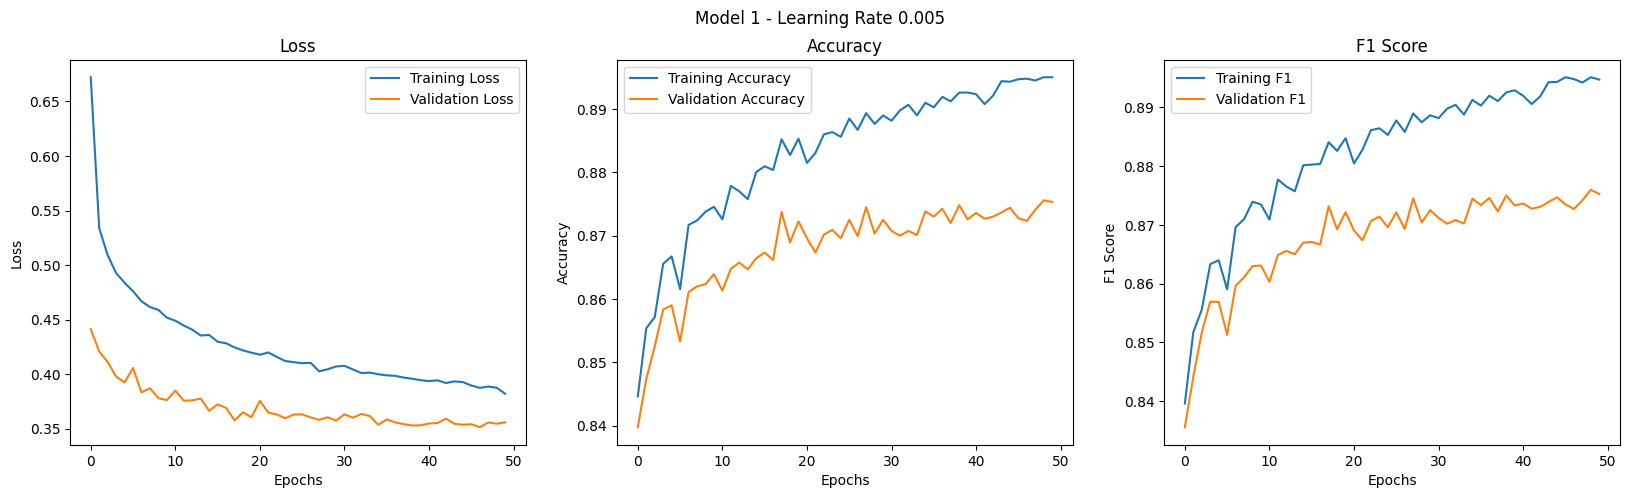

Epoch 1/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.34batch/s]


Epoch 1/50 - Training Loss: 0.3568 - Validation Loss: 0.3382 - Training Accuracy: 0.8997 - Validation Accuracy: 0.8801 - Training F1: 0.8999 - Validation F1: 0.8806


Epoch 2/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.75batch/s]


Epoch 2/50 - Training Loss: 0.3454 - Validation Loss: 0.3377 - Training Accuracy: 0.9005 - Validation Accuracy: 0.8808 - Training F1: 0.9009 - Validation F1: 0.8813


Epoch 3/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.32batch/s]


Epoch 3/50 - Training Loss: 0.3435 - Validation Loss: 0.3358 - Training Accuracy: 0.9006 - Validation Accuracy: 0.8791 - Training F1: 0.9009 - Validation F1: 0.8797


Epoch 4/50: 100%|██████████| 1500/1500 [00:26<00:00, 57.01batch/s]


Epoch 4/50 - Training Loss: 0.3436 - Validation Loss: 0.3368 - Training Accuracy: 0.9017 - Validation Accuracy: 0.8791 - Training F1: 0.9020 - Validation F1: 0.8797


Epoch 5/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.40batch/s]


Epoch 5/50 - Training Loss: 0.3434 - Validation Loss: 0.3344 - Training Accuracy: 0.9014 - Validation Accuracy: 0.8807 - Training F1: 0.9017 - Validation F1: 0.8811


Epoch 6/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.85batch/s]


Epoch 6/50 - Training Loss: 0.3404 - Validation Loss: 0.3353 - Training Accuracy: 0.9009 - Validation Accuracy: 0.8802 - Training F1: 0.9014 - Validation F1: 0.8809


Epoch 7/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.46batch/s]


Epoch 7/50 - Training Loss: 0.3418 - Validation Loss: 0.3364 - Training Accuracy: 0.9015 - Validation Accuracy: 0.8788 - Training F1: 0.9020 - Validation F1: 0.8797


Epoch 8/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.92batch/s]


Epoch 8/50 - Training Loss: 0.3363 - Validation Loss: 0.3347 - Training Accuracy: 0.9021 - Validation Accuracy: 0.8792 - Training F1: 0.9023 - Validation F1: 0.8797


Epoch 9/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.37batch/s]


Epoch 9/50 - Training Loss: 0.3353 - Validation Loss: 0.3369 - Training Accuracy: 0.9014 - Validation Accuracy: 0.8792 - Training F1: 0.9017 - Validation F1: 0.8796


Epoch 10/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.96batch/s]


Epoch 10/50 - Training Loss: 0.3405 - Validation Loss: 0.3345 - Training Accuracy: 0.9032 - Validation Accuracy: 0.8802 - Training F1: 0.9033 - Validation F1: 0.8805


Epoch 11/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.37batch/s]


Epoch 11/50 - Training Loss: 0.3353 - Validation Loss: 0.3357 - Training Accuracy: 0.9033 - Validation Accuracy: 0.8804 - Training F1: 0.9034 - Validation F1: 0.8808


Epoch 12/50: 100%|██████████| 1500/1500 [00:26<00:00, 57.00batch/s]


Epoch 12/50 - Training Loss: 0.3348 - Validation Loss: 0.3357 - Training Accuracy: 0.9031 - Validation Accuracy: 0.8803 - Training F1: 0.9034 - Validation F1: 0.8809


Epoch 13/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.48batch/s]


Epoch 13/50 - Training Loss: 0.3346 - Validation Loss: 0.3342 - Training Accuracy: 0.9039 - Validation Accuracy: 0.8812 - Training F1: 0.9040 - Validation F1: 0.8815


Epoch 14/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.96batch/s]


Epoch 14/50 - Training Loss: 0.3362 - Validation Loss: 0.3359 - Training Accuracy: 0.9030 - Validation Accuracy: 0.8791 - Training F1: 0.9035 - Validation F1: 0.8798


Epoch 15/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.54batch/s]


Epoch 15/50 - Training Loss: 0.3335 - Validation Loss: 0.3333 - Training Accuracy: 0.9036 - Validation Accuracy: 0.8795 - Training F1: 0.9040 - Validation F1: 0.8801


Epoch 16/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.86batch/s]


Epoch 16/50 - Training Loss: 0.3380 - Validation Loss: 0.3335 - Training Accuracy: 0.9040 - Validation Accuracy: 0.8799 - Training F1: 0.9045 - Validation F1: 0.8807


Epoch 17/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.59batch/s]


Epoch 17/50 - Training Loss: 0.3336 - Validation Loss: 0.3341 - Training Accuracy: 0.9042 - Validation Accuracy: 0.8804 - Training F1: 0.9045 - Validation F1: 0.8809


Epoch 18/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.89batch/s]


Epoch 18/50 - Training Loss: 0.3304 - Validation Loss: 0.3341 - Training Accuracy: 0.9044 - Validation Accuracy: 0.8813 - Training F1: 0.9047 - Validation F1: 0.8819


Epoch 19/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.16batch/s]


Epoch 19/50 - Training Loss: 0.3311 - Validation Loss: 0.3339 - Training Accuracy: 0.9054 - Validation Accuracy: 0.8816 - Training F1: 0.9054 - Validation F1: 0.8817


Epoch 20/50: 100%|██████████| 1500/1500 [00:26<00:00, 57.03batch/s]


Epoch 20/50 - Training Loss: 0.3336 - Validation Loss: 0.3339 - Training Accuracy: 0.9040 - Validation Accuracy: 0.8798 - Training F1: 0.9044 - Validation F1: 0.8805


Epoch 21/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.57batch/s]


Epoch 21/50 - Training Loss: 0.3332 - Validation Loss: 0.3346 - Training Accuracy: 0.9051 - Validation Accuracy: 0.8800 - Training F1: 0.9053 - Validation F1: 0.8805


Epoch 22/50: 100%|██████████| 1500/1500 [00:26<00:00, 57.02batch/s]


Epoch 22/50 - Training Loss: 0.3317 - Validation Loss: 0.3359 - Training Accuracy: 0.9040 - Validation Accuracy: 0.8796 - Training F1: 0.9046 - Validation F1: 0.8805


Epoch 23/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.49batch/s]


Epoch 23/50 - Training Loss: 0.3290 - Validation Loss: 0.3346 - Training Accuracy: 0.9051 - Validation Accuracy: 0.8800 - Training F1: 0.9056 - Validation F1: 0.8808


Epoch 24/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.96batch/s]


Epoch 24/50 - Training Loss: 0.3303 - Validation Loss: 0.3350 - Training Accuracy: 0.9049 - Validation Accuracy: 0.8792 - Training F1: 0.9053 - Validation F1: 0.8799


Epoch 25/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.66batch/s]


Epoch 25/50 - Training Loss: 0.3316 - Validation Loss: 0.3337 - Training Accuracy: 0.9056 - Validation Accuracy: 0.8789 - Training F1: 0.9062 - Validation F1: 0.8797


Epoch 26/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.92batch/s]


Epoch 26/50 - Training Loss: 0.3309 - Validation Loss: 0.3339 - Training Accuracy: 0.9060 - Validation Accuracy: 0.8788 - Training F1: 0.9064 - Validation F1: 0.8794


Epoch 27/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.54batch/s]


Epoch 27/50 - Training Loss: 0.3288 - Validation Loss: 0.3348 - Training Accuracy: 0.9059 - Validation Accuracy: 0.8809 - Training F1: 0.9060 - Validation F1: 0.8813


Epoch 28/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.91batch/s]


Epoch 28/50 - Training Loss: 0.3256 - Validation Loss: 0.3338 - Training Accuracy: 0.9063 - Validation Accuracy: 0.8804 - Training F1: 0.9065 - Validation F1: 0.8809


Epoch 29/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.53batch/s]


Epoch 29/50 - Training Loss: 0.3276 - Validation Loss: 0.3358 - Training Accuracy: 0.9054 - Validation Accuracy: 0.8800 - Training F1: 0.9059 - Validation F1: 0.8808


Epoch 30/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.76batch/s]


Epoch 30/50 - Training Loss: 0.3290 - Validation Loss: 0.3337 - Training Accuracy: 0.9055 - Validation Accuracy: 0.8798 - Training F1: 0.9058 - Validation F1: 0.8805


Epoch 31/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.59batch/s]


Epoch 31/50 - Training Loss: 0.3274 - Validation Loss: 0.3345 - Training Accuracy: 0.9048 - Validation Accuracy: 0.8798 - Training F1: 0.9053 - Validation F1: 0.8805


Epoch 32/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.95batch/s]


Epoch 32/50 - Training Loss: 0.3245 - Validation Loss: 0.3381 - Training Accuracy: 0.9053 - Validation Accuracy: 0.8792 - Training F1: 0.9058 - Validation F1: 0.8800


Epoch 33/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.55batch/s]


Epoch 33/50 - Training Loss: 0.3281 - Validation Loss: 0.3361 - Training Accuracy: 0.9065 - Validation Accuracy: 0.8796 - Training F1: 0.9068 - Validation F1: 0.8802


Epoch 34/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.90batch/s]


Epoch 34/50 - Training Loss: 0.3257 - Validation Loss: 0.3339 - Training Accuracy: 0.9065 - Validation Accuracy: 0.8804 - Training F1: 0.9066 - Validation F1: 0.8808


Epoch 35/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.60batch/s]


Epoch 35/50 - Training Loss: 0.3276 - Validation Loss: 0.3367 - Training Accuracy: 0.9052 - Validation Accuracy: 0.8801 - Training F1: 0.9057 - Validation F1: 0.8808


Epoch 36/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.92batch/s]


Epoch 36/50 - Training Loss: 0.3245 - Validation Loss: 0.3370 - Training Accuracy: 0.9056 - Validation Accuracy: 0.8794 - Training F1: 0.9059 - Validation F1: 0.8800


Epoch 37/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.59batch/s]


Epoch 37/50 - Training Loss: 0.3279 - Validation Loss: 0.3349 - Training Accuracy: 0.9076 - Validation Accuracy: 0.8812 - Training F1: 0.9076 - Validation F1: 0.8815


Epoch 38/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.93batch/s]


Epoch 38/50 - Training Loss: 0.3256 - Validation Loss: 0.3329 - Training Accuracy: 0.9077 - Validation Accuracy: 0.8810 - Training F1: 0.9080 - Validation F1: 0.8815


Epoch 39/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.65batch/s]


Epoch 39/50 - Training Loss: 0.3282 - Validation Loss: 0.3366 - Training Accuracy: 0.9064 - Validation Accuracy: 0.8806 - Training F1: 0.9067 - Validation F1: 0.8812


Epoch 40/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.80batch/s]


Epoch 40/50 - Training Loss: 0.3257 - Validation Loss: 0.3355 - Training Accuracy: 0.9070 - Validation Accuracy: 0.8808 - Training F1: 0.9072 - Validation F1: 0.8813


Epoch 41/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.50batch/s]


Epoch 41/50 - Training Loss: 0.3291 - Validation Loss: 0.3360 - Training Accuracy: 0.9066 - Validation Accuracy: 0.8788 - Training F1: 0.9071 - Validation F1: 0.8794


Epoch 42/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.83batch/s]


Epoch 42/50 - Training Loss: 0.3250 - Validation Loss: 0.3354 - Training Accuracy: 0.9066 - Validation Accuracy: 0.8793 - Training F1: 0.9070 - Validation F1: 0.8799


Epoch 43/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.68batch/s]


Epoch 43/50 - Training Loss: 0.3239 - Validation Loss: 0.3340 - Training Accuracy: 0.9069 - Validation Accuracy: 0.8797 - Training F1: 0.9072 - Validation F1: 0.8802


Epoch 44/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.77batch/s]


Epoch 44/50 - Training Loss: 0.3220 - Validation Loss: 0.3363 - Training Accuracy: 0.9067 - Validation Accuracy: 0.8792 - Training F1: 0.9073 - Validation F1: 0.8801


Epoch 45/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.53batch/s]


Epoch 45/50 - Training Loss: 0.3225 - Validation Loss: 0.3384 - Training Accuracy: 0.9066 - Validation Accuracy: 0.8791 - Training F1: 0.9069 - Validation F1: 0.8798


Epoch 46/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.89batch/s]


Epoch 46/50 - Training Loss: 0.3244 - Validation Loss: 0.3355 - Training Accuracy: 0.9083 - Validation Accuracy: 0.8794 - Training F1: 0.9086 - Validation F1: 0.8800


Epoch 47/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.75batch/s]


Epoch 47/50 - Training Loss: 0.3231 - Validation Loss: 0.3368 - Training Accuracy: 0.9075 - Validation Accuracy: 0.8806 - Training F1: 0.9077 - Validation F1: 0.8810


Epoch 48/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.83batch/s]


Epoch 48/50 - Training Loss: 0.3237 - Validation Loss: 0.3341 - Training Accuracy: 0.9075 - Validation Accuracy: 0.8806 - Training F1: 0.9079 - Validation F1: 0.8812


Epoch 49/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.63batch/s]


Epoch 49/50 - Training Loss: 0.3225 - Validation Loss: 0.3349 - Training Accuracy: 0.9085 - Validation Accuracy: 0.8812 - Training F1: 0.9084 - Validation F1: 0.8813


Epoch 50/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.67batch/s]


Epoch 50/50 - Training Loss: 0.3206 - Validation Loss: 0.3345 - Training Accuracy: 0.9082 - Validation Accuracy: 0.8802 - Training F1: 0.9084 - Validation F1: 0.8806


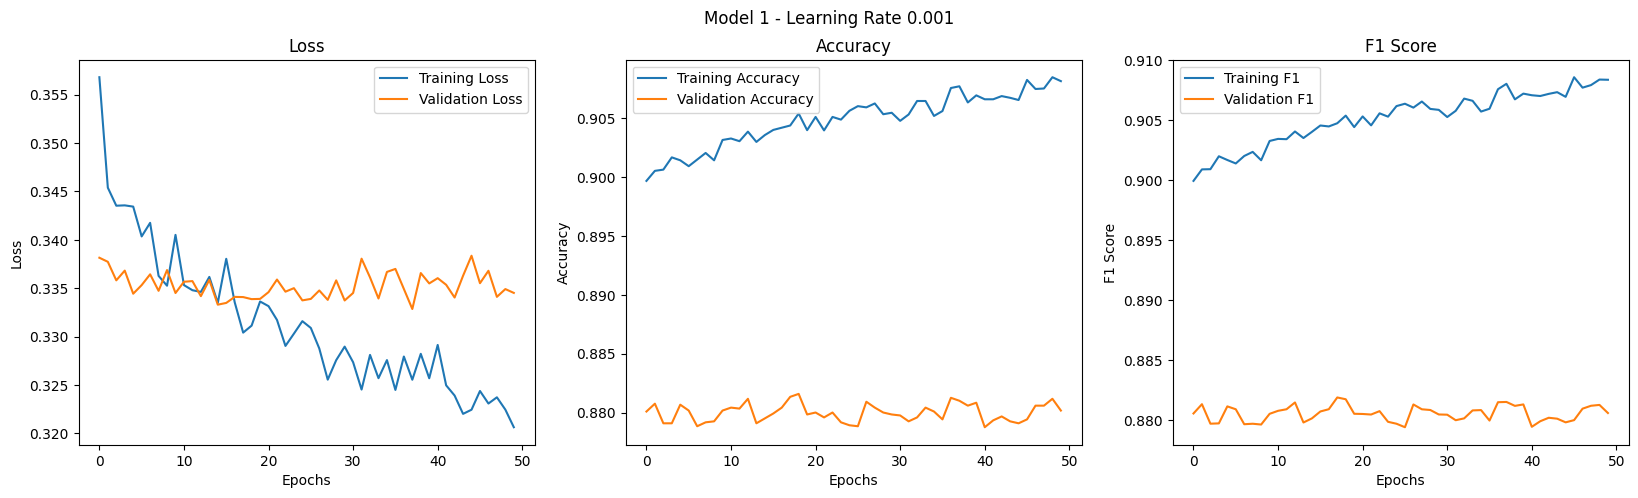

Epoch 1/50: 100%|██████████| 1500/1500 [00:26<00:00, 55.93batch/s]


Epoch 1/50 - Training Loss: 0.3153 - Validation Loss: 0.3338 - Training Accuracy: 0.9083 - Validation Accuracy: 0.8809 - Training F1: 0.9087 - Validation F1: 0.8816


Epoch 2/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.17batch/s]


Epoch 2/50 - Training Loss: 0.3194 - Validation Loss: 0.3335 - Training Accuracy: 0.9090 - Validation Accuracy: 0.8812 - Training F1: 0.9092 - Validation F1: 0.8817


Epoch 3/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.00batch/s]


Epoch 3/50 - Training Loss: 0.3173 - Validation Loss: 0.3330 - Training Accuracy: 0.9092 - Validation Accuracy: 0.8806 - Training F1: 0.9095 - Validation F1: 0.8811


Epoch 4/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.36batch/s]


Epoch 4/50 - Training Loss: 0.3132 - Validation Loss: 0.3334 - Training Accuracy: 0.9101 - Validation Accuracy: 0.8809 - Training F1: 0.9102 - Validation F1: 0.8813


Epoch 5/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.08batch/s]


Epoch 5/50 - Training Loss: 0.3137 - Validation Loss: 0.3337 - Training Accuracy: 0.9093 - Validation Accuracy: 0.8813 - Training F1: 0.9096 - Validation F1: 0.8819


Epoch 6/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.42batch/s]


Epoch 6/50 - Training Loss: 0.3156 - Validation Loss: 0.3342 - Training Accuracy: 0.9089 - Validation Accuracy: 0.8812 - Training F1: 0.9091 - Validation F1: 0.8817


Epoch 7/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.14batch/s]


Epoch 7/50 - Training Loss: 0.3154 - Validation Loss: 0.3327 - Training Accuracy: 0.9087 - Validation Accuracy: 0.8802 - Training F1: 0.9089 - Validation F1: 0.8807


Epoch 8/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.36batch/s]


Epoch 8/50 - Training Loss: 0.3126 - Validation Loss: 0.3343 - Training Accuracy: 0.9090 - Validation Accuracy: 0.8818 - Training F1: 0.9093 - Validation F1: 0.8823


Epoch 9/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.02batch/s]


Epoch 9/50 - Training Loss: 0.3157 - Validation Loss: 0.3330 - Training Accuracy: 0.9095 - Validation Accuracy: 0.8812 - Training F1: 0.9095 - Validation F1: 0.8815


Epoch 10/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.23batch/s]


Epoch 10/50 - Training Loss: 0.3134 - Validation Loss: 0.3341 - Training Accuracy: 0.9093 - Validation Accuracy: 0.8802 - Training F1: 0.9095 - Validation F1: 0.8808


Epoch 11/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.11batch/s]


Epoch 11/50 - Training Loss: 0.3146 - Validation Loss: 0.3334 - Training Accuracy: 0.9094 - Validation Accuracy: 0.8812 - Training F1: 0.9097 - Validation F1: 0.8818


Epoch 12/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.23batch/s]


Epoch 12/50 - Training Loss: 0.3125 - Validation Loss: 0.3349 - Training Accuracy: 0.9087 - Validation Accuracy: 0.8820 - Training F1: 0.9091 - Validation F1: 0.8826


Epoch 13/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.05batch/s]


Epoch 13/50 - Training Loss: 0.3142 - Validation Loss: 0.3363 - Training Accuracy: 0.9090 - Validation Accuracy: 0.8808 - Training F1: 0.9095 - Validation F1: 0.8815


Epoch 14/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.38batch/s]


Epoch 14/50 - Training Loss: 0.3138 - Validation Loss: 0.3331 - Training Accuracy: 0.9104 - Validation Accuracy: 0.8820 - Training F1: 0.9104 - Validation F1: 0.8823


Epoch 15/50: 100%|██████████| 1500/1500 [00:26<00:00, 55.62batch/s]


Epoch 15/50 - Training Loss: 0.3132 - Validation Loss: 0.3333 - Training Accuracy: 0.9089 - Validation Accuracy: 0.8797 - Training F1: 0.9093 - Validation F1: 0.8804


Epoch 16/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.43batch/s]


Epoch 16/50 - Training Loss: 0.3089 - Validation Loss: 0.3348 - Training Accuracy: 0.9103 - Validation Accuracy: 0.8813 - Training F1: 0.9105 - Validation F1: 0.8818


Epoch 17/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.05batch/s]


Epoch 17/50 - Training Loss: 0.3147 - Validation Loss: 0.3328 - Training Accuracy: 0.9096 - Validation Accuracy: 0.8813 - Training F1: 0.9099 - Validation F1: 0.8819


Epoch 18/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.53batch/s]


Epoch 18/50 - Training Loss: 0.3092 - Validation Loss: 0.3325 - Training Accuracy: 0.9097 - Validation Accuracy: 0.8818 - Training F1: 0.9100 - Validation F1: 0.8824


Epoch 19/50: 100%|██████████| 1500/1500 [00:26<00:00, 55.87batch/s]


Epoch 19/50 - Training Loss: 0.3115 - Validation Loss: 0.3343 - Training Accuracy: 0.9099 - Validation Accuracy: 0.8799 - Training F1: 0.9101 - Validation F1: 0.8804


Epoch 20/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.44batch/s]


Epoch 20/50 - Training Loss: 0.3118 - Validation Loss: 0.3324 - Training Accuracy: 0.9103 - Validation Accuracy: 0.8809 - Training F1: 0.9105 - Validation F1: 0.8813


Epoch 21/50: 100%|██████████| 1500/1500 [00:26<00:00, 55.99batch/s]


Epoch 21/50 - Training Loss: 0.3126 - Validation Loss: 0.3338 - Training Accuracy: 0.9101 - Validation Accuracy: 0.8814 - Training F1: 0.9104 - Validation F1: 0.8820


Epoch 22/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.43batch/s]


Epoch 22/50 - Training Loss: 0.3174 - Validation Loss: 0.3343 - Training Accuracy: 0.9098 - Validation Accuracy: 0.8804 - Training F1: 0.9101 - Validation F1: 0.8810


Epoch 23/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.04batch/s]


Epoch 23/50 - Training Loss: 0.3127 - Validation Loss: 0.3336 - Training Accuracy: 0.9096 - Validation Accuracy: 0.8806 - Training F1: 0.9100 - Validation F1: 0.8814


Epoch 24/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.42batch/s]


Epoch 24/50 - Training Loss: 0.3119 - Validation Loss: 0.3338 - Training Accuracy: 0.9097 - Validation Accuracy: 0.8812 - Training F1: 0.9100 - Validation F1: 0.8816


Epoch 25/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.00batch/s]


Epoch 25/50 - Training Loss: 0.3104 - Validation Loss: 0.3345 - Training Accuracy: 0.9104 - Validation Accuracy: 0.8807 - Training F1: 0.9106 - Validation F1: 0.8811


Epoch 26/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.56batch/s]


Epoch 26/50 - Training Loss: 0.3114 - Validation Loss: 0.3347 - Training Accuracy: 0.9092 - Validation Accuracy: 0.8810 - Training F1: 0.9097 - Validation F1: 0.8818


Epoch 27/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.11batch/s]


Epoch 27/50 - Training Loss: 0.3084 - Validation Loss: 0.3344 - Training Accuracy: 0.9102 - Validation Accuracy: 0.8809 - Training F1: 0.9105 - Validation F1: 0.8814


Epoch 28/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.61batch/s]


Epoch 28/50 - Training Loss: 0.3137 - Validation Loss: 0.3353 - Training Accuracy: 0.9104 - Validation Accuracy: 0.8819 - Training F1: 0.9106 - Validation F1: 0.8823


Epoch 29/50: 100%|██████████| 1500/1500 [00:26<00:00, 55.96batch/s]


Epoch 29/50 - Training Loss: 0.3093 - Validation Loss: 0.3346 - Training Accuracy: 0.9100 - Validation Accuracy: 0.8810 - Training F1: 0.9104 - Validation F1: 0.8817


Epoch 30/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.41batch/s]


Epoch 30/50 - Training Loss: 0.3109 - Validation Loss: 0.3345 - Training Accuracy: 0.9107 - Validation Accuracy: 0.8815 - Training F1: 0.9109 - Validation F1: 0.8820


Epoch 31/50: 100%|██████████| 1500/1500 [00:26<00:00, 55.99batch/s]


Epoch 31/50 - Training Loss: 0.3115 - Validation Loss: 0.3329 - Training Accuracy: 0.9106 - Validation Accuracy: 0.8818 - Training F1: 0.9109 - Validation F1: 0.8823


Epoch 32/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.59batch/s]


Epoch 32/50 - Training Loss: 0.3110 - Validation Loss: 0.3335 - Training Accuracy: 0.9109 - Validation Accuracy: 0.8807 - Training F1: 0.9112 - Validation F1: 0.8813


Epoch 33/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.11batch/s]


Epoch 33/50 - Training Loss: 0.3090 - Validation Loss: 0.3353 - Training Accuracy: 0.9101 - Validation Accuracy: 0.8812 - Training F1: 0.9106 - Validation F1: 0.8819


Epoch 34/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.04batch/s]


Epoch 34/50 - Training Loss: 0.3124 - Validation Loss: 0.3332 - Training Accuracy: 0.9110 - Validation Accuracy: 0.8822 - Training F1: 0.9110 - Validation F1: 0.8824


Epoch 35/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.24batch/s]


Epoch 35/50 - Training Loss: 0.3101 - Validation Loss: 0.3344 - Training Accuracy: 0.9109 - Validation Accuracy: 0.8821 - Training F1: 0.9110 - Validation F1: 0.8824


Epoch 36/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.32batch/s]


Epoch 36/50 - Training Loss: 0.3107 - Validation Loss: 0.3350 - Training Accuracy: 0.9108 - Validation Accuracy: 0.8819 - Training F1: 0.9111 - Validation F1: 0.8826


Epoch 37/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.22batch/s]


Epoch 37/50 - Training Loss: 0.3123 - Validation Loss: 0.3337 - Training Accuracy: 0.9103 - Validation Accuracy: 0.8821 - Training F1: 0.9106 - Validation F1: 0.8825


Epoch 38/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.54batch/s]


Epoch 38/50 - Training Loss: 0.3099 - Validation Loss: 0.3337 - Training Accuracy: 0.9114 - Validation Accuracy: 0.8818 - Training F1: 0.9117 - Validation F1: 0.8823


Epoch 39/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.22batch/s]


Epoch 39/50 - Training Loss: 0.3094 - Validation Loss: 0.3338 - Training Accuracy: 0.9115 - Validation Accuracy: 0.8818 - Training F1: 0.9118 - Validation F1: 0.8823


Epoch 40/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.61batch/s]


Epoch 40/50 - Training Loss: 0.3095 - Validation Loss: 0.3342 - Training Accuracy: 0.9108 - Validation Accuracy: 0.8817 - Training F1: 0.9110 - Validation F1: 0.8821


Epoch 41/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.10batch/s]


Epoch 41/50 - Training Loss: 0.3110 - Validation Loss: 0.3346 - Training Accuracy: 0.9110 - Validation Accuracy: 0.8802 - Training F1: 0.9112 - Validation F1: 0.8808


Epoch 42/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.53batch/s]


Epoch 42/50 - Training Loss: 0.3095 - Validation Loss: 0.3344 - Training Accuracy: 0.9118 - Validation Accuracy: 0.8812 - Training F1: 0.9119 - Validation F1: 0.8816


Epoch 43/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.26batch/s]


Epoch 43/50 - Training Loss: 0.3086 - Validation Loss: 0.3345 - Training Accuracy: 0.9120 - Validation Accuracy: 0.8815 - Training F1: 0.9121 - Validation F1: 0.8819


Epoch 44/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.31batch/s]


Epoch 44/50 - Training Loss: 0.3109 - Validation Loss: 0.3350 - Training Accuracy: 0.9111 - Validation Accuracy: 0.8821 - Training F1: 0.9114 - Validation F1: 0.8825


Epoch 45/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.11batch/s]


Epoch 45/50 - Training Loss: 0.3089 - Validation Loss: 0.3355 - Training Accuracy: 0.9107 - Validation Accuracy: 0.8818 - Training F1: 0.9111 - Validation F1: 0.8824


Epoch 46/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.54batch/s]


Epoch 46/50 - Training Loss: 0.3116 - Validation Loss: 0.3339 - Training Accuracy: 0.9111 - Validation Accuracy: 0.8816 - Training F1: 0.9114 - Validation F1: 0.8821


Epoch 47/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.09batch/s]


Epoch 47/50 - Training Loss: 0.3094 - Validation Loss: 0.3351 - Training Accuracy: 0.9108 - Validation Accuracy: 0.8800 - Training F1: 0.9112 - Validation F1: 0.8807


Epoch 48/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.50batch/s]


Epoch 48/50 - Training Loss: 0.3093 - Validation Loss: 0.3355 - Training Accuracy: 0.9111 - Validation Accuracy: 0.8803 - Training F1: 0.9114 - Validation F1: 0.8810


Epoch 49/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.17batch/s]


Epoch 49/50 - Training Loss: 0.3100 - Validation Loss: 0.3353 - Training Accuracy: 0.9114 - Validation Accuracy: 0.8819 - Training F1: 0.9117 - Validation F1: 0.8824


Epoch 50/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.49batch/s]


Epoch 50/50 - Training Loss: 0.3063 - Validation Loss: 0.3350 - Training Accuracy: 0.9116 - Validation Accuracy: 0.8807 - Training F1: 0.9120 - Validation F1: 0.8813


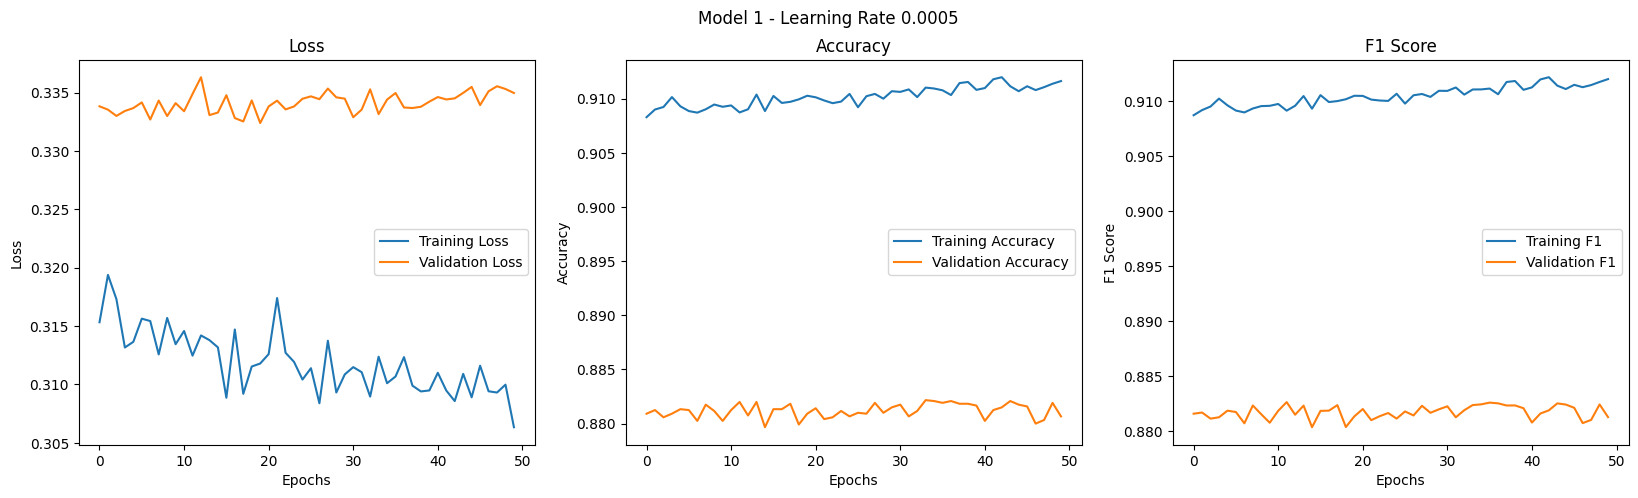

Epoch 1/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.42batch/s]


Epoch 1/50 - Training Loss: 0.3068 - Validation Loss: 0.3334 - Training Accuracy: 0.9125 - Validation Accuracy: 0.8810 - Training F1: 0.9125 - Validation F1: 0.8812


Epoch 2/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.62batch/s]


Epoch 2/50 - Training Loss: 0.3077 - Validation Loss: 0.3337 - Training Accuracy: 0.9128 - Validation Accuracy: 0.8815 - Training F1: 0.9128 - Validation F1: 0.8816


Epoch 3/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.44batch/s]


Epoch 3/50 - Training Loss: 0.3051 - Validation Loss: 0.3341 - Training Accuracy: 0.9119 - Validation Accuracy: 0.8821 - Training F1: 0.9119 - Validation F1: 0.8823


Epoch 4/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.46batch/s]


Epoch 4/50 - Training Loss: 0.3050 - Validation Loss: 0.3332 - Training Accuracy: 0.9125 - Validation Accuracy: 0.8822 - Training F1: 0.9125 - Validation F1: 0.8824


Epoch 5/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.43batch/s]


Epoch 5/50 - Training Loss: 0.3026 - Validation Loss: 0.3333 - Training Accuracy: 0.9122 - Validation Accuracy: 0.8814 - Training F1: 0.9123 - Validation F1: 0.8817


Epoch 6/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.69batch/s]


Epoch 6/50 - Training Loss: 0.3031 - Validation Loss: 0.3333 - Training Accuracy: 0.9117 - Validation Accuracy: 0.8822 - Training F1: 0.9117 - Validation F1: 0.8824


Epoch 7/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.38batch/s]


Epoch 7/50 - Training Loss: 0.3052 - Validation Loss: 0.3334 - Training Accuracy: 0.9122 - Validation Accuracy: 0.8814 - Training F1: 0.9122 - Validation F1: 0.8815


Epoch 8/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.59batch/s]


Epoch 8/50 - Training Loss: 0.3063 - Validation Loss: 0.3336 - Training Accuracy: 0.9123 - Validation Accuracy: 0.8828 - Training F1: 0.9123 - Validation F1: 0.8830


Epoch 9/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.53batch/s]


Epoch 9/50 - Training Loss: 0.3042 - Validation Loss: 0.3341 - Training Accuracy: 0.9120 - Validation Accuracy: 0.8812 - Training F1: 0.9120 - Validation F1: 0.8814


Epoch 10/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.05batch/s]


Epoch 10/50 - Training Loss: 0.3029 - Validation Loss: 0.3337 - Training Accuracy: 0.9123 - Validation Accuracy: 0.8811 - Training F1: 0.9124 - Validation F1: 0.8814


Epoch 11/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.55batch/s]


Epoch 11/50 - Training Loss: 0.3040 - Validation Loss: 0.3337 - Training Accuracy: 0.9123 - Validation Accuracy: 0.8816 - Training F1: 0.9125 - Validation F1: 0.8819


Epoch 12/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.60batch/s]


Epoch 12/50 - Training Loss: 0.3035 - Validation Loss: 0.3351 - Training Accuracy: 0.9123 - Validation Accuracy: 0.8810 - Training F1: 0.9123 - Validation F1: 0.8812


Epoch 13/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.33batch/s]


Epoch 13/50 - Training Loss: 0.3055 - Validation Loss: 0.3340 - Training Accuracy: 0.9117 - Validation Accuracy: 0.8818 - Training F1: 0.9117 - Validation F1: 0.8820


Epoch 14/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.48batch/s]


Epoch 14/50 - Training Loss: 0.3050 - Validation Loss: 0.3330 - Training Accuracy: 0.9131 - Validation Accuracy: 0.8812 - Training F1: 0.9131 - Validation F1: 0.8814


Epoch 15/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.46batch/s]


Epoch 15/50 - Training Loss: 0.3042 - Validation Loss: 0.3350 - Training Accuracy: 0.9125 - Validation Accuracy: 0.8815 - Training F1: 0.9125 - Validation F1: 0.8817


Epoch 16/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.23batch/s]


Epoch 16/50 - Training Loss: 0.3069 - Validation Loss: 0.3347 - Training Accuracy: 0.9121 - Validation Accuracy: 0.8818 - Training F1: 0.9122 - Validation F1: 0.8820


Epoch 17/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.44batch/s]


Epoch 17/50 - Training Loss: 0.3007 - Validation Loss: 0.3340 - Training Accuracy: 0.9129 - Validation Accuracy: 0.8814 - Training F1: 0.9130 - Validation F1: 0.8817


Epoch 18/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.43batch/s]


Epoch 18/50 - Training Loss: 0.3027 - Validation Loss: 0.3344 - Training Accuracy: 0.9126 - Validation Accuracy: 0.8819 - Training F1: 0.9127 - Validation F1: 0.8821


Epoch 19/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.60batch/s]


Epoch 19/50 - Training Loss: 0.3052 - Validation Loss: 0.3338 - Training Accuracy: 0.9126 - Validation Accuracy: 0.8813 - Training F1: 0.9127 - Validation F1: 0.8816


Epoch 20/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.53batch/s]


Epoch 20/50 - Training Loss: 0.3048 - Validation Loss: 0.3331 - Training Accuracy: 0.9125 - Validation Accuracy: 0.8814 - Training F1: 0.9127 - Validation F1: 0.8818


Epoch 21/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.38batch/s]


Epoch 21/50 - Training Loss: 0.3025 - Validation Loss: 0.3337 - Training Accuracy: 0.9125 - Validation Accuracy: 0.8809 - Training F1: 0.9126 - Validation F1: 0.8812


Epoch 22/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.52batch/s]


Epoch 22/50 - Training Loss: 0.3029 - Validation Loss: 0.3336 - Training Accuracy: 0.9127 - Validation Accuracy: 0.8812 - Training F1: 0.9128 - Validation F1: 0.8815


Epoch 23/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.39batch/s]


Epoch 23/50 - Training Loss: 0.3027 - Validation Loss: 0.3332 - Training Accuracy: 0.9125 - Validation Accuracy: 0.8818 - Training F1: 0.9125 - Validation F1: 0.8820


Epoch 24/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.45batch/s]


Epoch 24/50 - Training Loss: 0.3056 - Validation Loss: 0.3344 - Training Accuracy: 0.9124 - Validation Accuracy: 0.8817 - Training F1: 0.9125 - Validation F1: 0.8820


Epoch 25/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.49batch/s]


Epoch 25/50 - Training Loss: 0.3009 - Validation Loss: 0.3342 - Training Accuracy: 0.9125 - Validation Accuracy: 0.8816 - Training F1: 0.9124 - Validation F1: 0.8817


Epoch 26/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.48batch/s]


Epoch 26/50 - Training Loss: 0.3036 - Validation Loss: 0.3339 - Training Accuracy: 0.9123 - Validation Accuracy: 0.8822 - Training F1: 0.9124 - Validation F1: 0.8826


Epoch 27/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.25batch/s]


Epoch 27/50 - Training Loss: 0.3066 - Validation Loss: 0.3334 - Training Accuracy: 0.9123 - Validation Accuracy: 0.8825 - Training F1: 0.9122 - Validation F1: 0.8826


Epoch 28/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.50batch/s]


Epoch 28/50 - Training Loss: 0.3041 - Validation Loss: 0.3346 - Training Accuracy: 0.9120 - Validation Accuracy: 0.8818 - Training F1: 0.9121 - Validation F1: 0.8821


Epoch 29/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.48batch/s]


Epoch 29/50 - Training Loss: 0.3035 - Validation Loss: 0.3338 - Training Accuracy: 0.9125 - Validation Accuracy: 0.8821 - Training F1: 0.9126 - Validation F1: 0.8824


Epoch 30/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.56batch/s]


Epoch 30/50 - Training Loss: 0.3048 - Validation Loss: 0.3337 - Training Accuracy: 0.9127 - Validation Accuracy: 0.8821 - Training F1: 0.9127 - Validation F1: 0.8823


Epoch 31/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.38batch/s]


Epoch 31/50 - Training Loss: 0.3042 - Validation Loss: 0.3330 - Training Accuracy: 0.9123 - Validation Accuracy: 0.8814 - Training F1: 0.9123 - Validation F1: 0.8816


Epoch 32/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.42batch/s]


Epoch 32/50 - Training Loss: 0.3048 - Validation Loss: 0.3338 - Training Accuracy: 0.9130 - Validation Accuracy: 0.8822 - Training F1: 0.9130 - Validation F1: 0.8823


Epoch 33/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.45batch/s]


Epoch 33/50 - Training Loss: 0.3013 - Validation Loss: 0.3336 - Training Accuracy: 0.9127 - Validation Accuracy: 0.8813 - Training F1: 0.9129 - Validation F1: 0.8817


Epoch 34/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.48batch/s]


Epoch 34/50 - Training Loss: 0.3044 - Validation Loss: 0.3340 - Training Accuracy: 0.9129 - Validation Accuracy: 0.8819 - Training F1: 0.9130 - Validation F1: 0.8823


Epoch 35/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.54batch/s]


Epoch 35/50 - Training Loss: 0.2976 - Validation Loss: 0.3341 - Training Accuracy: 0.9130 - Validation Accuracy: 0.8819 - Training F1: 0.9130 - Validation F1: 0.8821


Epoch 36/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.54batch/s]


Epoch 36/50 - Training Loss: 0.3037 - Validation Loss: 0.3338 - Training Accuracy: 0.9127 - Validation Accuracy: 0.8818 - Training F1: 0.9128 - Validation F1: 0.8822


Epoch 37/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.44batch/s]


Epoch 37/50 - Training Loss: 0.3039 - Validation Loss: 0.3334 - Training Accuracy: 0.9128 - Validation Accuracy: 0.8816 - Training F1: 0.9129 - Validation F1: 0.8819


Epoch 38/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.45batch/s]


Epoch 38/50 - Training Loss: 0.3018 - Validation Loss: 0.3349 - Training Accuracy: 0.9127 - Validation Accuracy: 0.8823 - Training F1: 0.9128 - Validation F1: 0.8826


Epoch 39/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.47batch/s]


Epoch 39/50 - Training Loss: 0.3023 - Validation Loss: 0.3339 - Training Accuracy: 0.9135 - Validation Accuracy: 0.8821 - Training F1: 0.9134 - Validation F1: 0.8822


Epoch 40/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.46batch/s]


Epoch 40/50 - Training Loss: 0.2987 - Validation Loss: 0.3342 - Training Accuracy: 0.9124 - Validation Accuracy: 0.8812 - Training F1: 0.9125 - Validation F1: 0.8815


Epoch 41/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.51batch/s]


Epoch 41/50 - Training Loss: 0.3022 - Validation Loss: 0.3332 - Training Accuracy: 0.9133 - Validation Accuracy: 0.8810 - Training F1: 0.9133 - Validation F1: 0.8813


Epoch 42/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.51batch/s]


Epoch 42/50 - Training Loss: 0.3039 - Validation Loss: 0.3343 - Training Accuracy: 0.9124 - Validation Accuracy: 0.8812 - Training F1: 0.9126 - Validation F1: 0.8816


Epoch 43/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.57batch/s]


Epoch 43/50 - Training Loss: 0.3003 - Validation Loss: 0.3338 - Training Accuracy: 0.9127 - Validation Accuracy: 0.8820 - Training F1: 0.9128 - Validation F1: 0.8823


Epoch 44/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.51batch/s]


Epoch 44/50 - Training Loss: 0.3014 - Validation Loss: 0.3340 - Training Accuracy: 0.9125 - Validation Accuracy: 0.8817 - Training F1: 0.9125 - Validation F1: 0.8819


Epoch 45/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.46batch/s]


Epoch 45/50 - Training Loss: 0.3032 - Validation Loss: 0.3330 - Training Accuracy: 0.9125 - Validation Accuracy: 0.8818 - Training F1: 0.9126 - Validation F1: 0.8822


Epoch 46/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.43batch/s]


Epoch 46/50 - Training Loss: 0.3020 - Validation Loss: 0.3343 - Training Accuracy: 0.9124 - Validation Accuracy: 0.8819 - Training F1: 0.9126 - Validation F1: 0.8823


Epoch 47/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.41batch/s]


Epoch 47/50 - Training Loss: 0.3041 - Validation Loss: 0.3349 - Training Accuracy: 0.9122 - Validation Accuracy: 0.8817 - Training F1: 0.9123 - Validation F1: 0.8820


Epoch 48/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.05batch/s]


Epoch 48/50 - Training Loss: 0.3011 - Validation Loss: 0.3340 - Training Accuracy: 0.9129 - Validation Accuracy: 0.8818 - Training F1: 0.9130 - Validation F1: 0.8821


Epoch 49/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.52batch/s]


Epoch 49/50 - Training Loss: 0.3020 - Validation Loss: 0.3342 - Training Accuracy: 0.9130 - Validation Accuracy: 0.8822 - Training F1: 0.9131 - Validation F1: 0.8825


Epoch 50/50: 100%|██████████| 1500/1500 [00:26<00:00, 56.51batch/s]


Epoch 50/50 - Training Loss: 0.3019 - Validation Loss: 0.3335 - Training Accuracy: 0.9133 - Validation Accuracy: 0.8821 - Training F1: 0.9133 - Validation F1: 0.8823


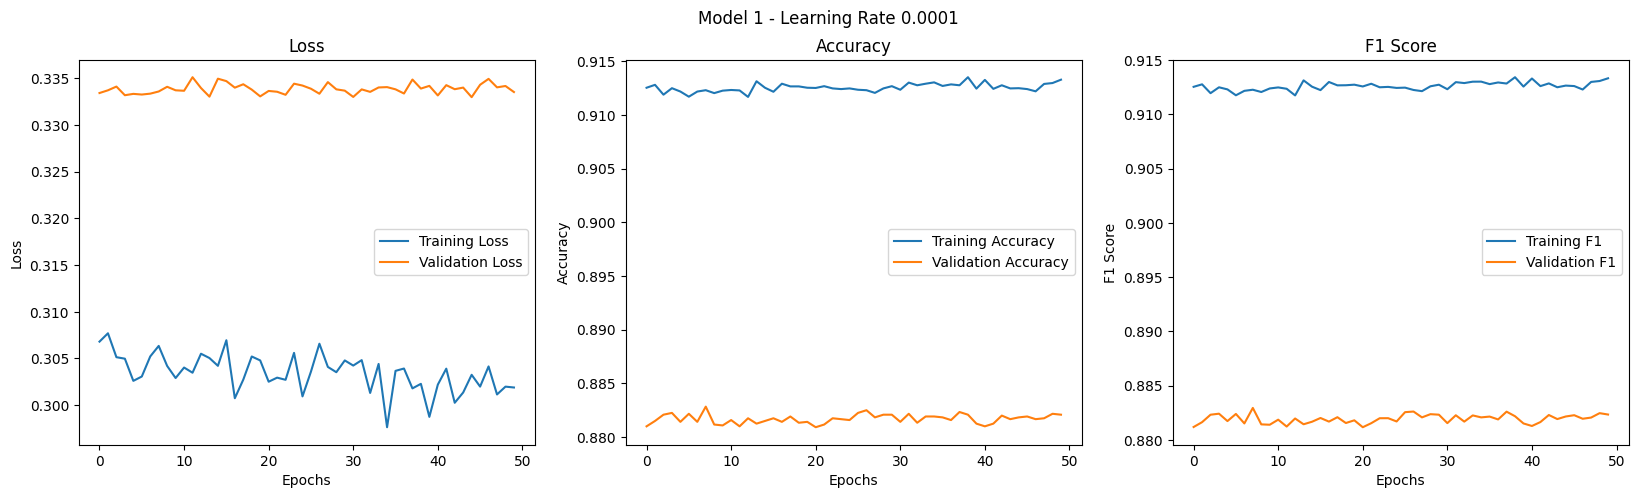

Epoch 1/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.82batch/s]


Epoch 1/50 - Training Loss: 0.7238 - Validation Loss: 0.4588 - Training Accuracy: 0.8379 - Validation Accuracy: 0.8335 - Training F1: 0.8330 - Validation F1: 0.8294


Epoch 2/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.42batch/s]


Epoch 2/50 - Training Loss: 0.5806 - Validation Loss: 0.4215 - Training Accuracy: 0.8522 - Validation Accuracy: 0.8427 - Training F1: 0.8495 - Validation F1: 0.8410


Epoch 3/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.95batch/s]


Epoch 3/50 - Training Loss: 0.5483 - Validation Loss: 0.4204 - Training Accuracy: 0.8559 - Validation Accuracy: 0.8448 - Training F1: 0.8517 - Validation F1: 0.8409


Epoch 4/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.48batch/s]


Epoch 4/50 - Training Loss: 0.5286 - Validation Loss: 0.4098 - Training Accuracy: 0.8590 - Validation Accuracy: 0.8495 - Training F1: 0.8573 - Validation F1: 0.8483


Epoch 5/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.59batch/s]


Epoch 5/50 - Training Loss: 0.5145 - Validation Loss: 0.4034 - Training Accuracy: 0.8636 - Validation Accuracy: 0.8547 - Training F1: 0.8619 - Validation F1: 0.8533


Epoch 6/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.37batch/s]


Epoch 6/50 - Training Loss: 0.5086 - Validation Loss: 0.3996 - Training Accuracy: 0.8636 - Validation Accuracy: 0.8531 - Training F1: 0.8628 - Validation F1: 0.8529


Epoch 7/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.39batch/s]


Epoch 7/50 - Training Loss: 0.4950 - Validation Loss: 0.3909 - Training Accuracy: 0.8690 - Validation Accuracy: 0.8572 - Training F1: 0.8683 - Validation F1: 0.8572


Epoch 8/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.63batch/s]


Epoch 8/50 - Training Loss: 0.4927 - Validation Loss: 0.3894 - Training Accuracy: 0.8692 - Validation Accuracy: 0.8564 - Training F1: 0.8689 - Validation F1: 0.8564


Epoch 9/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.21batch/s]


Epoch 9/50 - Training Loss: 0.4815 - Validation Loss: 0.3870 - Training Accuracy: 0.8681 - Validation Accuracy: 0.8609 - Training F1: 0.8690 - Validation F1: 0.8621


Epoch 10/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.78batch/s]


Epoch 10/50 - Training Loss: 0.4760 - Validation Loss: 0.3811 - Training Accuracy: 0.8714 - Validation Accuracy: 0.8588 - Training F1: 0.8711 - Validation F1: 0.8590


Epoch 11/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.38batch/s]


Epoch 11/50 - Training Loss: 0.4714 - Validation Loss: 0.3768 - Training Accuracy: 0.8753 - Validation Accuracy: 0.8625 - Training F1: 0.8746 - Validation F1: 0.8621


Epoch 12/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.32batch/s]


Epoch 12/50 - Training Loss: 0.4668 - Validation Loss: 0.3751 - Training Accuracy: 0.8756 - Validation Accuracy: 0.8624 - Training F1: 0.8747 - Validation F1: 0.8621


Epoch 13/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.53batch/s]


Epoch 13/50 - Training Loss: 0.4648 - Validation Loss: 0.3835 - Training Accuracy: 0.8722 - Validation Accuracy: 0.8602 - Training F1: 0.8713 - Validation F1: 0.8598


Epoch 14/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.33batch/s]


Epoch 14/50 - Training Loss: 0.4598 - Validation Loss: 0.3789 - Training Accuracy: 0.8758 - Validation Accuracy: 0.8628 - Training F1: 0.8752 - Validation F1: 0.8626


Epoch 15/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.69batch/s]


Epoch 15/50 - Training Loss: 0.4586 - Validation Loss: 0.3771 - Training Accuracy: 0.8759 - Validation Accuracy: 0.8626 - Training F1: 0.8755 - Validation F1: 0.8624


Epoch 16/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.13batch/s]


Epoch 16/50 - Training Loss: 0.4539 - Validation Loss: 0.3713 - Training Accuracy: 0.8781 - Validation Accuracy: 0.8644 - Training F1: 0.8780 - Validation F1: 0.8646


Epoch 17/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.60batch/s]


Epoch 17/50 - Training Loss: 0.4498 - Validation Loss: 0.3724 - Training Accuracy: 0.8774 - Validation Accuracy: 0.8648 - Training F1: 0.8777 - Validation F1: 0.8654


Epoch 18/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.41batch/s]


Epoch 18/50 - Training Loss: 0.4491 - Validation Loss: 0.3774 - Training Accuracy: 0.8746 - Validation Accuracy: 0.8610 - Training F1: 0.8749 - Validation F1: 0.8618


Epoch 19/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.39batch/s]


Epoch 19/50 - Training Loss: 0.4467 - Validation Loss: 0.3683 - Training Accuracy: 0.8786 - Validation Accuracy: 0.8648 - Training F1: 0.8787 - Validation F1: 0.8652


Epoch 20/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.53batch/s]


Epoch 20/50 - Training Loss: 0.4436 - Validation Loss: 0.3629 - Training Accuracy: 0.8828 - Validation Accuracy: 0.8682 - Training F1: 0.8826 - Validation F1: 0.8683


Epoch 21/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.31batch/s]


Epoch 21/50 - Training Loss: 0.4402 - Validation Loss: 0.3688 - Training Accuracy: 0.8812 - Validation Accuracy: 0.8658 - Training F1: 0.8810 - Validation F1: 0.8660


Epoch 22/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.66batch/s]


Epoch 22/50 - Training Loss: 0.4401 - Validation Loss: 0.3630 - Training Accuracy: 0.8819 - Validation Accuracy: 0.8682 - Training F1: 0.8824 - Validation F1: 0.8691


Epoch 23/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.35batch/s]


Epoch 23/50 - Training Loss: 0.4381 - Validation Loss: 0.3693 - Training Accuracy: 0.8813 - Validation Accuracy: 0.8679 - Training F1: 0.8815 - Validation F1: 0.8685


Epoch 24/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.43batch/s]


Epoch 24/50 - Training Loss: 0.4321 - Validation Loss: 0.3674 - Training Accuracy: 0.8818 - Validation Accuracy: 0.8668 - Training F1: 0.8807 - Validation F1: 0.8660


Epoch 25/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.59batch/s]


Epoch 25/50 - Training Loss: 0.4359 - Validation Loss: 0.3651 - Training Accuracy: 0.8823 - Validation Accuracy: 0.8658 - Training F1: 0.8827 - Validation F1: 0.8664


Epoch 26/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.31batch/s]


Epoch 26/50 - Training Loss: 0.4305 - Validation Loss: 0.3649 - Training Accuracy: 0.8821 - Validation Accuracy: 0.8645 - Training F1: 0.8825 - Validation F1: 0.8655


Epoch 27/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.67batch/s]


Epoch 27/50 - Training Loss: 0.4298 - Validation Loss: 0.3633 - Training Accuracy: 0.8846 - Validation Accuracy: 0.8672 - Training F1: 0.8846 - Validation F1: 0.8676


Epoch 28/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.16batch/s]


Epoch 28/50 - Training Loss: 0.4295 - Validation Loss: 0.3629 - Training Accuracy: 0.8864 - Validation Accuracy: 0.8698 - Training F1: 0.8860 - Validation F1: 0.8697


Epoch 29/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.15batch/s]


Epoch 29/50 - Training Loss: 0.4285 - Validation Loss: 0.3576 - Training Accuracy: 0.8871 - Validation Accuracy: 0.8692 - Training F1: 0.8868 - Validation F1: 0.8694


Epoch 30/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.47batch/s]


Epoch 30/50 - Training Loss: 0.4253 - Validation Loss: 0.3595 - Training Accuracy: 0.8866 - Validation Accuracy: 0.8673 - Training F1: 0.8867 - Validation F1: 0.8679


Epoch 31/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.38batch/s]


Epoch 31/50 - Training Loss: 0.4178 - Validation Loss: 0.3624 - Training Accuracy: 0.8860 - Validation Accuracy: 0.8699 - Training F1: 0.8863 - Validation F1: 0.8707


Epoch 32/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.71batch/s]


Epoch 32/50 - Training Loss: 0.4243 - Validation Loss: 0.3581 - Training Accuracy: 0.8866 - Validation Accuracy: 0.8677 - Training F1: 0.8874 - Validation F1: 0.8689


Epoch 33/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.28batch/s]


Epoch 33/50 - Training Loss: 0.4153 - Validation Loss: 0.3612 - Training Accuracy: 0.8885 - Validation Accuracy: 0.8692 - Training F1: 0.8885 - Validation F1: 0.8696


Epoch 34/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.69batch/s]


Epoch 34/50 - Training Loss: 0.4185 - Validation Loss: 0.3605 - Training Accuracy: 0.8882 - Validation Accuracy: 0.8707 - Training F1: 0.8887 - Validation F1: 0.8715


Epoch 35/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.43batch/s]


Epoch 35/50 - Training Loss: 0.4192 - Validation Loss: 0.3550 - Training Accuracy: 0.8891 - Validation Accuracy: 0.8707 - Training F1: 0.8893 - Validation F1: 0.8711


Epoch 36/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.46batch/s]


Epoch 36/50 - Training Loss: 0.4146 - Validation Loss: 0.3592 - Training Accuracy: 0.8906 - Validation Accuracy: 0.8708 - Training F1: 0.8902 - Validation F1: 0.8709


Epoch 37/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.63batch/s]


Epoch 37/50 - Training Loss: 0.4185 - Validation Loss: 0.3621 - Training Accuracy: 0.8904 - Validation Accuracy: 0.8711 - Training F1: 0.8895 - Validation F1: 0.8704


Epoch 38/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.25batch/s]


Epoch 38/50 - Training Loss: 0.4213 - Validation Loss: 0.3660 - Training Accuracy: 0.8891 - Validation Accuracy: 0.8709 - Training F1: 0.8897 - Validation F1: 0.8719


Epoch 39/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.67batch/s]


Epoch 39/50 - Training Loss: 0.4142 - Validation Loss: 0.3621 - Training Accuracy: 0.8919 - Validation Accuracy: 0.8718 - Training F1: 0.8921 - Validation F1: 0.8723


Epoch 40/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.30batch/s]


Epoch 40/50 - Training Loss: 0.4171 - Validation Loss: 0.3482 - Training Accuracy: 0.8920 - Validation Accuracy: 0.8732 - Training F1: 0.8920 - Validation F1: 0.8735


Epoch 41/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.64batch/s]


Epoch 41/50 - Training Loss: 0.4125 - Validation Loss: 0.3566 - Training Accuracy: 0.8911 - Validation Accuracy: 0.8716 - Training F1: 0.8910 - Validation F1: 0.8719


Epoch 42/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.04batch/s]


Epoch 42/50 - Training Loss: 0.4085 - Validation Loss: 0.3514 - Training Accuracy: 0.8929 - Validation Accuracy: 0.8721 - Training F1: 0.8932 - Validation F1: 0.8727


Epoch 43/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.26batch/s]


Epoch 43/50 - Training Loss: 0.4097 - Validation Loss: 0.3521 - Training Accuracy: 0.8921 - Validation Accuracy: 0.8725 - Training F1: 0.8921 - Validation F1: 0.8728


Epoch 44/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.35batch/s]


Epoch 44/50 - Training Loss: 0.4095 - Validation Loss: 0.3511 - Training Accuracy: 0.8934 - Validation Accuracy: 0.8741 - Training F1: 0.8931 - Validation F1: 0.8741


Epoch 45/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.25batch/s]


Epoch 45/50 - Training Loss: 0.4099 - Validation Loss: 0.3494 - Training Accuracy: 0.8936 - Validation Accuracy: 0.8739 - Training F1: 0.8937 - Validation F1: 0.8745


Epoch 46/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.59batch/s]


Epoch 46/50 - Training Loss: 0.4084 - Validation Loss: 0.3495 - Training Accuracy: 0.8926 - Validation Accuracy: 0.8732 - Training F1: 0.8928 - Validation F1: 0.8739


Epoch 47/50: 100%|██████████| 1500/1500 [00:27<00:00, 54.41batch/s]


Epoch 47/50 - Training Loss: 0.4096 - Validation Loss: 0.3497 - Training Accuracy: 0.8930 - Validation Accuracy: 0.8740 - Training F1: 0.8932 - Validation F1: 0.8745


Epoch 48/50: 100%|██████████| 1500/1500 [00:27<00:00, 54.57batch/s]


Epoch 48/50 - Training Loss: 0.4034 - Validation Loss: 0.3498 - Training Accuracy: 0.8933 - Validation Accuracy: 0.8752 - Training F1: 0.8933 - Validation F1: 0.8756


Epoch 49/50: 100%|██████████| 1500/1500 [00:27<00:00, 54.40batch/s]


Epoch 49/50 - Training Loss: 0.4010 - Validation Loss: 0.3514 - Training Accuracy: 0.8939 - Validation Accuracy: 0.8740 - Training F1: 0.8932 - Validation F1: 0.8736


Epoch 50/50: 100%|██████████| 1500/1500 [00:27<00:00, 54.59batch/s]


Epoch 50/50 - Training Loss: 0.4074 - Validation Loss: 0.3468 - Training Accuracy: 0.8938 - Validation Accuracy: 0.8751 - Training F1: 0.8933 - Validation F1: 0.8750


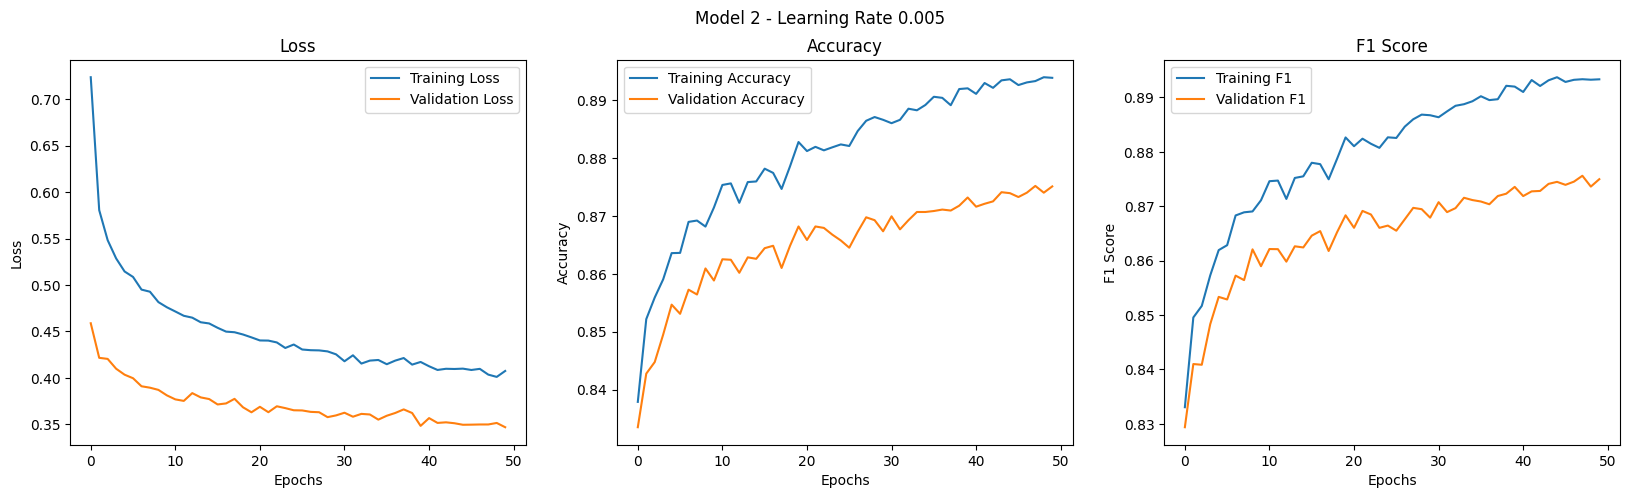

Epoch 1/50: 100%|██████████| 1500/1500 [00:27<00:00, 54.55batch/s]


Epoch 1/50 - Training Loss: 0.3799 - Validation Loss: 0.3416 - Training Accuracy: 0.8967 - Validation Accuracy: 0.8762 - Training F1: 0.8966 - Validation F1: 0.8764


Epoch 2/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.67batch/s]


Epoch 2/50 - Training Loss: 0.3728 - Validation Loss: 0.3419 - Training Accuracy: 0.8975 - Validation Accuracy: 0.8769 - Training F1: 0.8974 - Validation F1: 0.8770


Epoch 3/50: 100%|██████████| 1500/1500 [00:27<00:00, 54.01batch/s]


Epoch 3/50 - Training Loss: 0.3715 - Validation Loss: 0.3424 - Training Accuracy: 0.8970 - Validation Accuracy: 0.8777 - Training F1: 0.8969 - Validation F1: 0.8778


Epoch 4/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.37batch/s]


Epoch 4/50 - Training Loss: 0.3664 - Validation Loss: 0.3421 - Training Accuracy: 0.8975 - Validation Accuracy: 0.8770 - Training F1: 0.8975 - Validation F1: 0.8774


Epoch 5/50: 100%|██████████| 1500/1500 [00:29<00:00, 51.29batch/s]


Epoch 5/50 - Training Loss: 0.3674 - Validation Loss: 0.3423 - Training Accuracy: 0.8974 - Validation Accuracy: 0.8766 - Training F1: 0.8975 - Validation F1: 0.8770


Epoch 6/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.59batch/s]


Epoch 6/50 - Training Loss: 0.3644 - Validation Loss: 0.3404 - Training Accuracy: 0.8982 - Validation Accuracy: 0.8775 - Training F1: 0.8982 - Validation F1: 0.8779


Epoch 7/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.21batch/s]


Epoch 7/50 - Training Loss: 0.3639 - Validation Loss: 0.3408 - Training Accuracy: 0.8991 - Validation Accuracy: 0.8788 - Training F1: 0.8989 - Validation F1: 0.8788


Epoch 8/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.13batch/s]


Epoch 8/50 - Training Loss: 0.3653 - Validation Loss: 0.3384 - Training Accuracy: 0.8997 - Validation Accuracy: 0.8790 - Training F1: 0.8995 - Validation F1: 0.8791


Epoch 9/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.26batch/s]


Epoch 9/50 - Training Loss: 0.3646 - Validation Loss: 0.3396 - Training Accuracy: 0.8989 - Validation Accuracy: 0.8789 - Training F1: 0.8988 - Validation F1: 0.8792


Epoch 10/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.00batch/s]


Epoch 10/50 - Training Loss: 0.3643 - Validation Loss: 0.3398 - Training Accuracy: 0.8992 - Validation Accuracy: 0.8777 - Training F1: 0.8991 - Validation F1: 0.8779


Epoch 11/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.64batch/s]


Epoch 11/50 - Training Loss: 0.3602 - Validation Loss: 0.3407 - Training Accuracy: 0.8991 - Validation Accuracy: 0.8773 - Training F1: 0.8992 - Validation F1: 0.8778


Epoch 12/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.04batch/s]


Epoch 12/50 - Training Loss: 0.3616 - Validation Loss: 0.3380 - Training Accuracy: 0.8994 - Validation Accuracy: 0.8780 - Training F1: 0.8993 - Validation F1: 0.8782


Epoch 13/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.46batch/s]


Epoch 13/50 - Training Loss: 0.3616 - Validation Loss: 0.3372 - Training Accuracy: 0.8999 - Validation Accuracy: 0.8774 - Training F1: 0.8999 - Validation F1: 0.8776


Epoch 14/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.48batch/s]


Epoch 14/50 - Training Loss: 0.3614 - Validation Loss: 0.3363 - Training Accuracy: 0.9004 - Validation Accuracy: 0.8788 - Training F1: 0.9003 - Validation F1: 0.8790


Epoch 15/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.00batch/s]


Epoch 15/50 - Training Loss: 0.3574 - Validation Loss: 0.3372 - Training Accuracy: 0.9006 - Validation Accuracy: 0.8792 - Training F1: 0.9004 - Validation F1: 0.8793


Epoch 16/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.52batch/s]


Epoch 16/50 - Training Loss: 0.3576 - Validation Loss: 0.3406 - Training Accuracy: 0.9003 - Validation Accuracy: 0.8788 - Training F1: 0.9003 - Validation F1: 0.8791


Epoch 17/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.79batch/s]


Epoch 17/50 - Training Loss: 0.3585 - Validation Loss: 0.3368 - Training Accuracy: 0.9013 - Validation Accuracy: 0.8798 - Training F1: 0.9012 - Validation F1: 0.8798


Epoch 18/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.51batch/s]


Epoch 18/50 - Training Loss: 0.3599 - Validation Loss: 0.3366 - Training Accuracy: 0.9009 - Validation Accuracy: 0.8800 - Training F1: 0.9007 - Validation F1: 0.8801


Epoch 19/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.23batch/s]


Epoch 19/50 - Training Loss: 0.3585 - Validation Loss: 0.3379 - Training Accuracy: 0.9012 - Validation Accuracy: 0.8791 - Training F1: 0.9012 - Validation F1: 0.8794


Epoch 20/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.24batch/s]


Epoch 20/50 - Training Loss: 0.3545 - Validation Loss: 0.3363 - Training Accuracy: 0.9009 - Validation Accuracy: 0.8790 - Training F1: 0.9010 - Validation F1: 0.8794


Epoch 21/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.37batch/s]


Epoch 21/50 - Training Loss: 0.3546 - Validation Loss: 0.3376 - Training Accuracy: 0.9013 - Validation Accuracy: 0.8792 - Training F1: 0.9012 - Validation F1: 0.8794


Epoch 22/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.12batch/s]


Epoch 22/50 - Training Loss: 0.3611 - Validation Loss: 0.3380 - Training Accuracy: 0.9009 - Validation Accuracy: 0.8784 - Training F1: 0.9009 - Validation F1: 0.8786


Epoch 23/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.59batch/s]


Epoch 23/50 - Training Loss: 0.3586 - Validation Loss: 0.3376 - Training Accuracy: 0.9000 - Validation Accuracy: 0.8778 - Training F1: 0.9002 - Validation F1: 0.8783


Epoch 24/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.18batch/s]


Epoch 24/50 - Training Loss: 0.3554 - Validation Loss: 0.3390 - Training Accuracy: 0.9016 - Validation Accuracy: 0.8791 - Training F1: 0.9016 - Validation F1: 0.8794


Epoch 25/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.34batch/s]


Epoch 25/50 - Training Loss: 0.3566 - Validation Loss: 0.3364 - Training Accuracy: 0.9019 - Validation Accuracy: 0.8804 - Training F1: 0.9019 - Validation F1: 0.8806


Epoch 26/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.57batch/s]


Epoch 26/50 - Training Loss: 0.3551 - Validation Loss: 0.3374 - Training Accuracy: 0.9016 - Validation Accuracy: 0.8793 - Training F1: 0.9016 - Validation F1: 0.8796


Epoch 27/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.20batch/s]


Epoch 27/50 - Training Loss: 0.3549 - Validation Loss: 0.3365 - Training Accuracy: 0.9027 - Validation Accuracy: 0.8798 - Training F1: 0.9026 - Validation F1: 0.8799


Epoch 28/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.59batch/s]


Epoch 28/50 - Training Loss: 0.3560 - Validation Loss: 0.3388 - Training Accuracy: 0.9024 - Validation Accuracy: 0.8786 - Training F1: 0.9023 - Validation F1: 0.8788


Epoch 29/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.06batch/s]


Epoch 29/50 - Training Loss: 0.3550 - Validation Loss: 0.3341 - Training Accuracy: 0.9025 - Validation Accuracy: 0.8798 - Training F1: 0.9023 - Validation F1: 0.8800


Epoch 30/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.35batch/s]


Epoch 30/50 - Training Loss: 0.3525 - Validation Loss: 0.3363 - Training Accuracy: 0.9017 - Validation Accuracy: 0.8792 - Training F1: 0.9018 - Validation F1: 0.8796


Epoch 31/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.98batch/s]


Epoch 31/50 - Training Loss: 0.3533 - Validation Loss: 0.3383 - Training Accuracy: 0.9021 - Validation Accuracy: 0.8784 - Training F1: 0.9022 - Validation F1: 0.8789


Epoch 32/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.06batch/s]


Epoch 32/50 - Training Loss: 0.3547 - Validation Loss: 0.3375 - Training Accuracy: 0.9018 - Validation Accuracy: 0.8782 - Training F1: 0.9018 - Validation F1: 0.8785


Epoch 33/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.82batch/s]


Epoch 33/50 - Training Loss: 0.3523 - Validation Loss: 0.3362 - Training Accuracy: 0.9021 - Validation Accuracy: 0.8799 - Training F1: 0.9021 - Validation F1: 0.8802


Epoch 34/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.79batch/s]


Epoch 34/50 - Training Loss: 0.3494 - Validation Loss: 0.3362 - Training Accuracy: 0.9028 - Validation Accuracy: 0.8802 - Training F1: 0.9026 - Validation F1: 0.8804


Epoch 35/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.98batch/s]


Epoch 35/50 - Training Loss: 0.3518 - Validation Loss: 0.3376 - Training Accuracy: 0.9021 - Validation Accuracy: 0.8787 - Training F1: 0.9023 - Validation F1: 0.8790


Epoch 36/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.01batch/s]


Epoch 36/50 - Training Loss: 0.3525 - Validation Loss: 0.3351 - Training Accuracy: 0.9030 - Validation Accuracy: 0.8803 - Training F1: 0.9030 - Validation F1: 0.8805


Epoch 37/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.91batch/s]


Epoch 37/50 - Training Loss: 0.3499 - Validation Loss: 0.3380 - Training Accuracy: 0.9022 - Validation Accuracy: 0.8794 - Training F1: 0.9024 - Validation F1: 0.8799


Epoch 38/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.53batch/s]


Epoch 38/50 - Training Loss: 0.3491 - Validation Loss: 0.3351 - Training Accuracy: 0.9033 - Validation Accuracy: 0.8804 - Training F1: 0.9032 - Validation F1: 0.8806


Epoch 39/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.99batch/s]


Epoch 39/50 - Training Loss: 0.3507 - Validation Loss: 0.3363 - Training Accuracy: 0.9023 - Validation Accuracy: 0.8792 - Training F1: 0.9025 - Validation F1: 0.8796


Epoch 40/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.43batch/s]


Epoch 40/50 - Training Loss: 0.3563 - Validation Loss: 0.3375 - Training Accuracy: 0.9018 - Validation Accuracy: 0.8787 - Training F1: 0.9021 - Validation F1: 0.8792


Epoch 41/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.29batch/s]


Epoch 41/50 - Training Loss: 0.3523 - Validation Loss: 0.3386 - Training Accuracy: 0.9033 - Validation Accuracy: 0.8797 - Training F1: 0.9032 - Validation F1: 0.8798


Epoch 42/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.27batch/s]


Epoch 42/50 - Training Loss: 0.3510 - Validation Loss: 0.3372 - Training Accuracy: 0.9035 - Validation Accuracy: 0.8812 - Training F1: 0.9033 - Validation F1: 0.8813


Epoch 43/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.43batch/s]


Epoch 43/50 - Training Loss: 0.3489 - Validation Loss: 0.3367 - Training Accuracy: 0.9033 - Validation Accuracy: 0.8804 - Training F1: 0.9034 - Validation F1: 0.8807


Epoch 44/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.03batch/s]


Epoch 44/50 - Training Loss: 0.3496 - Validation Loss: 0.3361 - Training Accuracy: 0.9035 - Validation Accuracy: 0.8802 - Training F1: 0.9033 - Validation F1: 0.8802


Epoch 45/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.46batch/s]


Epoch 45/50 - Training Loss: 0.3507 - Validation Loss: 0.3357 - Training Accuracy: 0.9032 - Validation Accuracy: 0.8792 - Training F1: 0.9031 - Validation F1: 0.8793


Epoch 46/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.11batch/s]


Epoch 46/50 - Training Loss: 0.3478 - Validation Loss: 0.3376 - Training Accuracy: 0.9034 - Validation Accuracy: 0.8785 - Training F1: 0.9032 - Validation F1: 0.8786


Epoch 47/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.07batch/s]


Epoch 47/50 - Training Loss: 0.3513 - Validation Loss: 0.3344 - Training Accuracy: 0.9034 - Validation Accuracy: 0.8794 - Training F1: 0.9034 - Validation F1: 0.8797


Epoch 48/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.46batch/s]


Epoch 48/50 - Training Loss: 0.3491 - Validation Loss: 0.3373 - Training Accuracy: 0.9036 - Validation Accuracy: 0.8798 - Training F1: 0.9037 - Validation F1: 0.8802


Epoch 49/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.88batch/s]


Epoch 49/50 - Training Loss: 0.3478 - Validation Loss: 0.3343 - Training Accuracy: 0.9042 - Validation Accuracy: 0.8805 - Training F1: 0.9038 - Validation F1: 0.8803


Epoch 50/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.68batch/s]


Epoch 50/50 - Training Loss: 0.3452 - Validation Loss: 0.3353 - Training Accuracy: 0.9042 - Validation Accuracy: 0.8806 - Training F1: 0.9042 - Validation F1: 0.8808


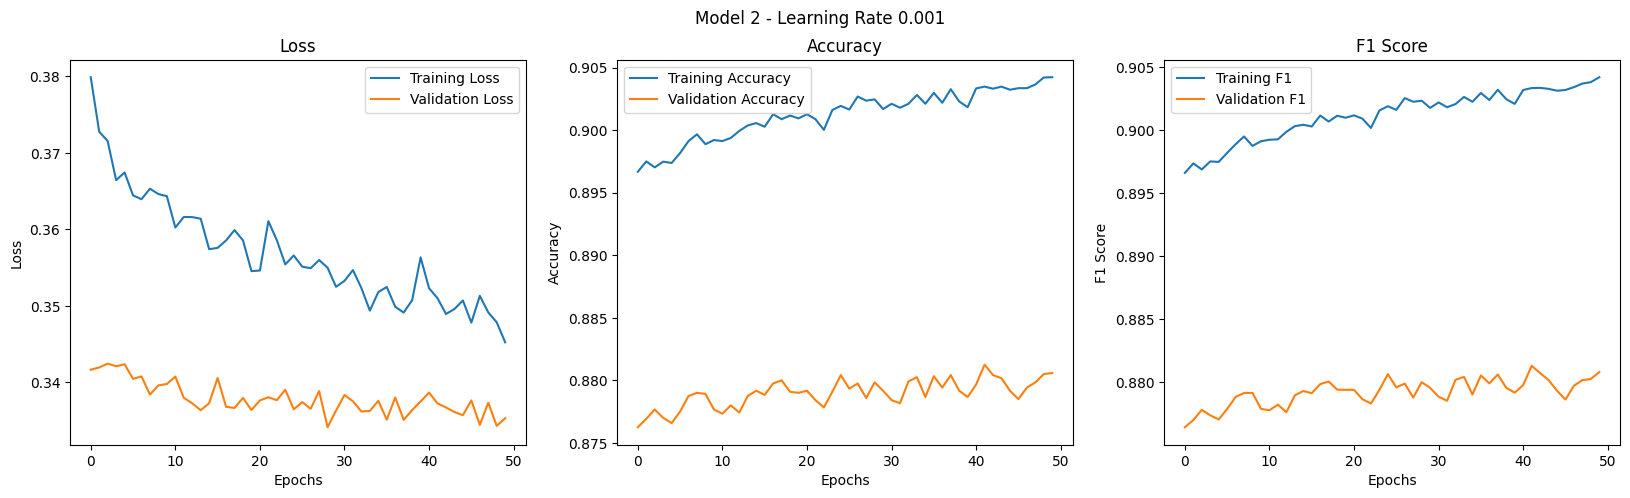

Epoch 1/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.21batch/s]


Epoch 1/50 - Training Loss: 0.3426 - Validation Loss: 0.3341 - Training Accuracy: 0.9048 - Validation Accuracy: 0.8814 - Training F1: 0.9046 - Validation F1: 0.8814


Epoch 2/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.34batch/s]


Epoch 2/50 - Training Loss: 0.3431 - Validation Loss: 0.3344 - Training Accuracy: 0.9044 - Validation Accuracy: 0.8813 - Training F1: 0.9044 - Validation F1: 0.8816


Epoch 3/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.40batch/s]


Epoch 3/50 - Training Loss: 0.3427 - Validation Loss: 0.3353 - Training Accuracy: 0.9045 - Validation Accuracy: 0.8810 - Training F1: 0.9044 - Validation F1: 0.8812


Epoch 4/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.19batch/s]


Epoch 4/50 - Training Loss: 0.3427 - Validation Loss: 0.3348 - Training Accuracy: 0.9046 - Validation Accuracy: 0.8822 - Training F1: 0.9043 - Validation F1: 0.8821


Epoch 5/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.50batch/s]


Epoch 5/50 - Training Loss: 0.3413 - Validation Loss: 0.3343 - Training Accuracy: 0.9050 - Validation Accuracy: 0.8812 - Training F1: 0.9048 - Validation F1: 0.8812


Epoch 6/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.00batch/s]


Epoch 6/50 - Training Loss: 0.3410 - Validation Loss: 0.3353 - Training Accuracy: 0.9046 - Validation Accuracy: 0.8805 - Training F1: 0.9045 - Validation F1: 0.8806


Epoch 7/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.53batch/s]


Epoch 7/50 - Training Loss: 0.3432 - Validation Loss: 0.3354 - Training Accuracy: 0.9045 - Validation Accuracy: 0.8798 - Training F1: 0.9046 - Validation F1: 0.8802


Epoch 8/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.26batch/s]


Epoch 8/50 - Training Loss: 0.3411 - Validation Loss: 0.3353 - Training Accuracy: 0.9045 - Validation Accuracy: 0.8802 - Training F1: 0.9045 - Validation F1: 0.8804


Epoch 9/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.17batch/s]


Epoch 9/50 - Training Loss: 0.3415 - Validation Loss: 0.3342 - Training Accuracy: 0.9045 - Validation Accuracy: 0.8802 - Training F1: 0.9046 - Validation F1: 0.8805


Epoch 10/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.97batch/s]


Epoch 10/50 - Training Loss: 0.3386 - Validation Loss: 0.3344 - Training Accuracy: 0.9053 - Validation Accuracy: 0.8818 - Training F1: 0.9053 - Validation F1: 0.8821


Epoch 11/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.08batch/s]


Epoch 11/50 - Training Loss: 0.3397 - Validation Loss: 0.3342 - Training Accuracy: 0.9051 - Validation Accuracy: 0.8805 - Training F1: 0.9052 - Validation F1: 0.8808


Epoch 12/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.54batch/s]


Epoch 12/50 - Training Loss: 0.3407 - Validation Loss: 0.3343 - Training Accuracy: 0.9048 - Validation Accuracy: 0.8807 - Training F1: 0.9047 - Validation F1: 0.8809


Epoch 13/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.32batch/s]


Epoch 13/50 - Training Loss: 0.3401 - Validation Loss: 0.3344 - Training Accuracy: 0.9050 - Validation Accuracy: 0.8812 - Training F1: 0.9049 - Validation F1: 0.8813


Epoch 14/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.25batch/s]


Epoch 14/50 - Training Loss: 0.3415 - Validation Loss: 0.3348 - Training Accuracy: 0.9051 - Validation Accuracy: 0.8811 - Training F1: 0.9052 - Validation F1: 0.8813


Epoch 15/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.54batch/s]


Epoch 15/50 - Training Loss: 0.3402 - Validation Loss: 0.3339 - Training Accuracy: 0.9055 - Validation Accuracy: 0.8811 - Training F1: 0.9052 - Validation F1: 0.8810


Epoch 16/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.90batch/s]


Epoch 16/50 - Training Loss: 0.3423 - Validation Loss: 0.3319 - Training Accuracy: 0.9051 - Validation Accuracy: 0.8820 - Training F1: 0.9049 - Validation F1: 0.8821


Epoch 17/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.55batch/s]


Epoch 17/50 - Training Loss: 0.3407 - Validation Loss: 0.3341 - Training Accuracy: 0.9064 - Validation Accuracy: 0.8811 - Training F1: 0.9062 - Validation F1: 0.8812


Epoch 18/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.15batch/s]


Epoch 18/50 - Training Loss: 0.3407 - Validation Loss: 0.3339 - Training Accuracy: 0.9058 - Validation Accuracy: 0.8816 - Training F1: 0.9057 - Validation F1: 0.8817


Epoch 19/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.30batch/s]


Epoch 19/50 - Training Loss: 0.3431 - Validation Loss: 0.3340 - Training Accuracy: 0.9056 - Validation Accuracy: 0.8813 - Training F1: 0.9056 - Validation F1: 0.8816


Epoch 20/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.38batch/s]


Epoch 20/50 - Training Loss: 0.3371 - Validation Loss: 0.3348 - Training Accuracy: 0.9057 - Validation Accuracy: 0.8820 - Training F1: 0.9056 - Validation F1: 0.8822


Epoch 21/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.12batch/s]


Epoch 21/50 - Training Loss: 0.3404 - Validation Loss: 0.3365 - Training Accuracy: 0.9052 - Validation Accuracy: 0.8801 - Training F1: 0.9053 - Validation F1: 0.8804


Epoch 22/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.49batch/s]


Epoch 22/50 - Training Loss: 0.3377 - Validation Loss: 0.3350 - Training Accuracy: 0.9054 - Validation Accuracy: 0.8816 - Training F1: 0.9052 - Validation F1: 0.8816


Epoch 23/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.01batch/s]


Epoch 23/50 - Training Loss: 0.3412 - Validation Loss: 0.3345 - Training Accuracy: 0.9056 - Validation Accuracy: 0.8816 - Training F1: 0.9054 - Validation F1: 0.8817


Epoch 24/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.34batch/s]


Epoch 24/50 - Training Loss: 0.3371 - Validation Loss: 0.3339 - Training Accuracy: 0.9050 - Validation Accuracy: 0.8802 - Training F1: 0.9051 - Validation F1: 0.8804


Epoch 25/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.25batch/s]


Epoch 25/50 - Training Loss: 0.3401 - Validation Loss: 0.3337 - Training Accuracy: 0.9059 - Validation Accuracy: 0.8808 - Training F1: 0.9058 - Validation F1: 0.8809


Epoch 26/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.21batch/s]


Epoch 26/50 - Training Loss: 0.3402 - Validation Loss: 0.3361 - Training Accuracy: 0.9058 - Validation Accuracy: 0.8812 - Training F1: 0.9057 - Validation F1: 0.8813


Epoch 27/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.48batch/s]


Epoch 27/50 - Training Loss: 0.3364 - Validation Loss: 0.3337 - Training Accuracy: 0.9059 - Validation Accuracy: 0.8811 - Training F1: 0.9058 - Validation F1: 0.8812


Epoch 28/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.81batch/s]


Epoch 28/50 - Training Loss: 0.3388 - Validation Loss: 0.3336 - Training Accuracy: 0.9057 - Validation Accuracy: 0.8807 - Training F1: 0.9057 - Validation F1: 0.8809


Epoch 29/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.44batch/s]


Epoch 29/50 - Training Loss: 0.3402 - Validation Loss: 0.3339 - Training Accuracy: 0.9059 - Validation Accuracy: 0.8802 - Training F1: 0.9059 - Validation F1: 0.8805


Epoch 30/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.19batch/s]


Epoch 30/50 - Training Loss: 0.3386 - Validation Loss: 0.3337 - Training Accuracy: 0.9066 - Validation Accuracy: 0.8810 - Training F1: 0.9066 - Validation F1: 0.8812


Epoch 31/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.10batch/s]


Epoch 31/50 - Training Loss: 0.3355 - Validation Loss: 0.3358 - Training Accuracy: 0.9055 - Validation Accuracy: 0.8802 - Training F1: 0.9055 - Validation F1: 0.8805


Epoch 32/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.62batch/s]


Epoch 32/50 - Training Loss: 0.3374 - Validation Loss: 0.3344 - Training Accuracy: 0.9060 - Validation Accuracy: 0.8814 - Training F1: 0.9060 - Validation F1: 0.8816


Epoch 33/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.24batch/s]


Epoch 33/50 - Training Loss: 0.3357 - Validation Loss: 0.3335 - Training Accuracy: 0.9061 - Validation Accuracy: 0.8816 - Training F1: 0.9061 - Validation F1: 0.8818


Epoch 34/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.70batch/s]


Epoch 34/50 - Training Loss: 0.3380 - Validation Loss: 0.3350 - Training Accuracy: 0.9055 - Validation Accuracy: 0.8804 - Training F1: 0.9056 - Validation F1: 0.8807


Epoch 35/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.19batch/s]


Epoch 35/50 - Training Loss: 0.3365 - Validation Loss: 0.3344 - Training Accuracy: 0.9061 - Validation Accuracy: 0.8816 - Training F1: 0.9061 - Validation F1: 0.8818


Epoch 36/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.33batch/s]


Epoch 36/50 - Training Loss: 0.3350 - Validation Loss: 0.3337 - Training Accuracy: 0.9061 - Validation Accuracy: 0.8807 - Training F1: 0.9061 - Validation F1: 0.8809


Epoch 37/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.46batch/s]


Epoch 37/50 - Training Loss: 0.3374 - Validation Loss: 0.3340 - Training Accuracy: 0.9063 - Validation Accuracy: 0.8811 - Training F1: 0.9063 - Validation F1: 0.8812


Epoch 38/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.23batch/s]


Epoch 38/50 - Training Loss: 0.3412 - Validation Loss: 0.3333 - Training Accuracy: 0.9055 - Validation Accuracy: 0.8801 - Training F1: 0.9057 - Validation F1: 0.8805


Epoch 39/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.50batch/s]


Epoch 39/50 - Training Loss: 0.3378 - Validation Loss: 0.3341 - Training Accuracy: 0.9063 - Validation Accuracy: 0.8819 - Training F1: 0.9063 - Validation F1: 0.8821


Epoch 40/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.99batch/s]


Epoch 40/50 - Training Loss: 0.3357 - Validation Loss: 0.3332 - Training Accuracy: 0.9074 - Validation Accuracy: 0.8817 - Training F1: 0.9072 - Validation F1: 0.8817


Epoch 41/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.39batch/s]


Epoch 41/50 - Training Loss: 0.3382 - Validation Loss: 0.3332 - Training Accuracy: 0.9061 - Validation Accuracy: 0.8805 - Training F1: 0.9062 - Validation F1: 0.8808


Epoch 42/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.34batch/s]


Epoch 42/50 - Training Loss: 0.3340 - Validation Loss: 0.3355 - Training Accuracy: 0.9067 - Validation Accuracy: 0.8815 - Training F1: 0.9066 - Validation F1: 0.8817


Epoch 43/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.24batch/s]


Epoch 43/50 - Training Loss: 0.3338 - Validation Loss: 0.3338 - Training Accuracy: 0.9064 - Validation Accuracy: 0.8817 - Training F1: 0.9062 - Validation F1: 0.8816


Epoch 44/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.48batch/s]


Epoch 44/50 - Training Loss: 0.3372 - Validation Loss: 0.3332 - Training Accuracy: 0.9066 - Validation Accuracy: 0.8806 - Training F1: 0.9068 - Validation F1: 0.8811


Epoch 45/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.10batch/s]


Epoch 45/50 - Training Loss: 0.3357 - Validation Loss: 0.3359 - Training Accuracy: 0.9066 - Validation Accuracy: 0.8802 - Training F1: 0.9066 - Validation F1: 0.8804


Epoch 46/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.39batch/s]


Epoch 46/50 - Training Loss: 0.3374 - Validation Loss: 0.3362 - Training Accuracy: 0.9067 - Validation Accuracy: 0.8802 - Training F1: 0.9067 - Validation F1: 0.8804


Epoch 47/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.18batch/s]


Epoch 47/50 - Training Loss: 0.3352 - Validation Loss: 0.3353 - Training Accuracy: 0.9068 - Validation Accuracy: 0.8792 - Training F1: 0.9069 - Validation F1: 0.8796


Epoch 48/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.21batch/s]


Epoch 48/50 - Training Loss: 0.3354 - Validation Loss: 0.3346 - Training Accuracy: 0.9068 - Validation Accuracy: 0.8808 - Training F1: 0.9068 - Validation F1: 0.8810


Epoch 49/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.33batch/s]


Epoch 49/50 - Training Loss: 0.3352 - Validation Loss: 0.3350 - Training Accuracy: 0.9069 - Validation Accuracy: 0.8821 - Training F1: 0.9069 - Validation F1: 0.8823


Epoch 50/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.93batch/s]


Epoch 50/50 - Training Loss: 0.3361 - Validation Loss: 0.3344 - Training Accuracy: 0.9070 - Validation Accuracy: 0.8812 - Training F1: 0.9071 - Validation F1: 0.8814


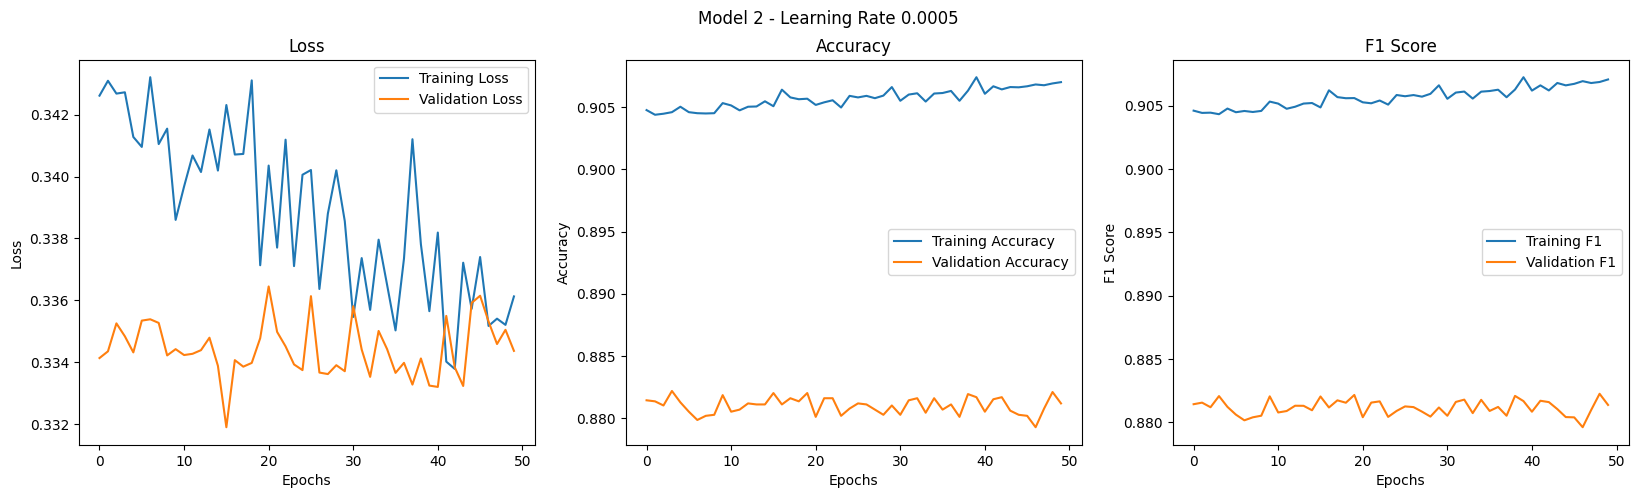

Epoch 1/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.38batch/s]


Epoch 1/50 - Training Loss: 0.3343 - Validation Loss: 0.3329 - Training Accuracy: 0.9075 - Validation Accuracy: 0.8812 - Training F1: 0.9075 - Validation F1: 0.8813


Epoch 2/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.15batch/s]


Epoch 2/50 - Training Loss: 0.3325 - Validation Loss: 0.3332 - Training Accuracy: 0.9073 - Validation Accuracy: 0.8821 - Training F1: 0.9071 - Validation F1: 0.8820


Epoch 3/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.38batch/s]


Epoch 3/50 - Training Loss: 0.3331 - Validation Loss: 0.3338 - Training Accuracy: 0.9070 - Validation Accuracy: 0.8817 - Training F1: 0.9069 - Validation F1: 0.8816


Epoch 4/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.44batch/s]


Epoch 4/50 - Training Loss: 0.3330 - Validation Loss: 0.3332 - Training Accuracy: 0.9075 - Validation Accuracy: 0.8817 - Training F1: 0.9073 - Validation F1: 0.8817


Epoch 5/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.13batch/s]


Epoch 5/50 - Training Loss: 0.3337 - Validation Loss: 0.3323 - Training Accuracy: 0.9077 - Validation Accuracy: 0.8818 - Training F1: 0.9074 - Validation F1: 0.8816


Epoch 6/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.42batch/s]


Epoch 6/50 - Training Loss: 0.3333 - Validation Loss: 0.3320 - Training Accuracy: 0.9075 - Validation Accuracy: 0.8817 - Training F1: 0.9074 - Validation F1: 0.8817


Epoch 7/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.72batch/s]


Epoch 7/50 - Training Loss: 0.3316 - Validation Loss: 0.3317 - Training Accuracy: 0.9073 - Validation Accuracy: 0.8813 - Training F1: 0.9072 - Validation F1: 0.8814


Epoch 8/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.16batch/s]


Epoch 8/50 - Training Loss: 0.3276 - Validation Loss: 0.3327 - Training Accuracy: 0.9075 - Validation Accuracy: 0.8811 - Training F1: 0.9073 - Validation F1: 0.8811


Epoch 9/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.63batch/s]


Epoch 9/50 - Training Loss: 0.3325 - Validation Loss: 0.3335 - Training Accuracy: 0.9073 - Validation Accuracy: 0.8814 - Training F1: 0.9071 - Validation F1: 0.8813


Epoch 10/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.85batch/s]


Epoch 10/50 - Training Loss: 0.3307 - Validation Loss: 0.3332 - Training Accuracy: 0.9074 - Validation Accuracy: 0.8818 - Training F1: 0.9072 - Validation F1: 0.8817


Epoch 11/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.66batch/s]


Epoch 11/50 - Training Loss: 0.3298 - Validation Loss: 0.3333 - Training Accuracy: 0.9073 - Validation Accuracy: 0.8814 - Training F1: 0.9071 - Validation F1: 0.8813


Epoch 12/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.11batch/s]


Epoch 12/50 - Training Loss: 0.3290 - Validation Loss: 0.3326 - Training Accuracy: 0.9079 - Validation Accuracy: 0.8814 - Training F1: 0.9077 - Validation F1: 0.8814


Epoch 13/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.33batch/s]


Epoch 13/50 - Training Loss: 0.3316 - Validation Loss: 0.3325 - Training Accuracy: 0.9076 - Validation Accuracy: 0.8824 - Training F1: 0.9074 - Validation F1: 0.8824


Epoch 14/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.16batch/s]


Epoch 14/50 - Training Loss: 0.3324 - Validation Loss: 0.3331 - Training Accuracy: 0.9079 - Validation Accuracy: 0.8817 - Training F1: 0.9076 - Validation F1: 0.8816


Epoch 15/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.11batch/s]


Epoch 15/50 - Training Loss: 0.3310 - Validation Loss: 0.3330 - Training Accuracy: 0.9078 - Validation Accuracy: 0.8820 - Training F1: 0.9076 - Validation F1: 0.8819


Epoch 16/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.61batch/s]


Epoch 16/50 - Training Loss: 0.3321 - Validation Loss: 0.3325 - Training Accuracy: 0.9078 - Validation Accuracy: 0.8819 - Training F1: 0.9075 - Validation F1: 0.8818


Epoch 17/50: 100%|██████████| 1500/1500 [00:29<00:00, 51.36batch/s]


Epoch 17/50 - Training Loss: 0.3304 - Validation Loss: 0.3346 - Training Accuracy: 0.9080 - Validation Accuracy: 0.8818 - Training F1: 0.9078 - Validation F1: 0.8817


Epoch 18/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.78batch/s]


Epoch 18/50 - Training Loss: 0.3305 - Validation Loss: 0.3328 - Training Accuracy: 0.9079 - Validation Accuracy: 0.8812 - Training F1: 0.9078 - Validation F1: 0.8813


Epoch 19/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.90batch/s]


Epoch 19/50 - Training Loss: 0.3327 - Validation Loss: 0.3322 - Training Accuracy: 0.9078 - Validation Accuracy: 0.8811 - Training F1: 0.9078 - Validation F1: 0.8813


Epoch 20/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.83batch/s]


Epoch 20/50 - Training Loss: 0.3307 - Validation Loss: 0.3331 - Training Accuracy: 0.9081 - Validation Accuracy: 0.8822 - Training F1: 0.9079 - Validation F1: 0.8821


Epoch 21/50: 100%|██████████| 1500/1500 [00:28<00:00, 51.94batch/s]


Epoch 21/50 - Training Loss: 0.3291 - Validation Loss: 0.3331 - Training Accuracy: 0.9076 - Validation Accuracy: 0.8820 - Training F1: 0.9075 - Validation F1: 0.8820


Epoch 22/50: 100%|██████████| 1500/1500 [00:29<00:00, 51.57batch/s]


Epoch 22/50 - Training Loss: 0.3318 - Validation Loss: 0.3318 - Training Accuracy: 0.9081 - Validation Accuracy: 0.8820 - Training F1: 0.9079 - Validation F1: 0.8818


Epoch 23/50: 100%|██████████| 1500/1500 [00:27<00:00, 54.34batch/s]


Epoch 23/50 - Training Loss: 0.3324 - Validation Loss: 0.3329 - Training Accuracy: 0.9081 - Validation Accuracy: 0.8818 - Training F1: 0.9079 - Validation F1: 0.8818


Epoch 24/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.86batch/s]


Epoch 24/50 - Training Loss: 0.3334 - Validation Loss: 0.3325 - Training Accuracy: 0.9083 - Validation Accuracy: 0.8818 - Training F1: 0.9082 - Validation F1: 0.8818


Epoch 25/50: 100%|██████████| 1500/1500 [00:29<00:00, 51.49batch/s]


Epoch 25/50 - Training Loss: 0.3334 - Validation Loss: 0.3331 - Training Accuracy: 0.9076 - Validation Accuracy: 0.8818 - Training F1: 0.9074 - Validation F1: 0.8818


Epoch 26/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.63batch/s]


Epoch 26/50 - Training Loss: 0.3321 - Validation Loss: 0.3333 - Training Accuracy: 0.9077 - Validation Accuracy: 0.8820 - Training F1: 0.9074 - Validation F1: 0.8819


Epoch 27/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.23batch/s]


Epoch 27/50 - Training Loss: 0.3303 - Validation Loss: 0.3338 - Training Accuracy: 0.9079 - Validation Accuracy: 0.8812 - Training F1: 0.9077 - Validation F1: 0.8812


Epoch 28/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.48batch/s]


Epoch 28/50 - Training Loss: 0.3279 - Validation Loss: 0.3322 - Training Accuracy: 0.9078 - Validation Accuracy: 0.8820 - Training F1: 0.9075 - Validation F1: 0.8819


Epoch 29/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.37batch/s]


Epoch 29/50 - Training Loss: 0.3301 - Validation Loss: 0.3315 - Training Accuracy: 0.9078 - Validation Accuracy: 0.8812 - Training F1: 0.9077 - Validation F1: 0.8812


Epoch 30/50: 100%|██████████| 1500/1500 [00:29<00:00, 51.60batch/s]


Epoch 30/50 - Training Loss: 0.3319 - Validation Loss: 0.3321 - Training Accuracy: 0.9076 - Validation Accuracy: 0.8812 - Training F1: 0.9075 - Validation F1: 0.8812


Epoch 31/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.12batch/s]


Epoch 31/50 - Training Loss: 0.3291 - Validation Loss: 0.3323 - Training Accuracy: 0.9077 - Validation Accuracy: 0.8819 - Training F1: 0.9074 - Validation F1: 0.8817


Epoch 32/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.15batch/s]


Epoch 32/50 - Training Loss: 0.3286 - Validation Loss: 0.3327 - Training Accuracy: 0.9081 - Validation Accuracy: 0.8820 - Training F1: 0.9080 - Validation F1: 0.8821


Epoch 33/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.24batch/s]


Epoch 33/50 - Training Loss: 0.3288 - Validation Loss: 0.3332 - Training Accuracy: 0.9083 - Validation Accuracy: 0.8815 - Training F1: 0.9081 - Validation F1: 0.8815


Epoch 34/50: 100%|██████████| 1500/1500 [00:29<00:00, 50.87batch/s]


Epoch 34/50 - Training Loss: 0.3339 - Validation Loss: 0.3317 - Training Accuracy: 0.9083 - Validation Accuracy: 0.8819 - Training F1: 0.9081 - Validation F1: 0.8818


Epoch 35/50: 100%|██████████| 1500/1500 [00:30<00:00, 49.70batch/s]


Epoch 35/50 - Training Loss: 0.3338 - Validation Loss: 0.3330 - Training Accuracy: 0.9076 - Validation Accuracy: 0.8821 - Training F1: 0.9075 - Validation F1: 0.8821


Epoch 36/50: 100%|██████████| 1500/1500 [00:28<00:00, 51.77batch/s]


Epoch 36/50 - Training Loss: 0.3295 - Validation Loss: 0.3324 - Training Accuracy: 0.9078 - Validation Accuracy: 0.8823 - Training F1: 0.9076 - Validation F1: 0.8823


Epoch 37/50: 100%|██████████| 1500/1500 [00:29<00:00, 51.07batch/s]


Epoch 37/50 - Training Loss: 0.3281 - Validation Loss: 0.3327 - Training Accuracy: 0.9084 - Validation Accuracy: 0.8819 - Training F1: 0.9082 - Validation F1: 0.8819


Epoch 38/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.85batch/s]


Epoch 38/50 - Training Loss: 0.3309 - Validation Loss: 0.3336 - Training Accuracy: 0.9080 - Validation Accuracy: 0.8822 - Training F1: 0.9078 - Validation F1: 0.8822


Epoch 39/50: 100%|██████████| 1500/1500 [00:29<00:00, 51.64batch/s]


Epoch 39/50 - Training Loss: 0.3300 - Validation Loss: 0.3329 - Training Accuracy: 0.9081 - Validation Accuracy: 0.8822 - Training F1: 0.9079 - Validation F1: 0.8821


Epoch 40/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.28batch/s]


Epoch 40/50 - Training Loss: 0.3303 - Validation Loss: 0.3320 - Training Accuracy: 0.9083 - Validation Accuracy: 0.8818 - Training F1: 0.9082 - Validation F1: 0.8818


Epoch 41/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.70batch/s]


Epoch 41/50 - Training Loss: 0.3289 - Validation Loss: 0.3307 - Training Accuracy: 0.9083 - Validation Accuracy: 0.8818 - Training F1: 0.9080 - Validation F1: 0.8817


Epoch 42/50: 100%|██████████| 1500/1500 [00:28<00:00, 51.75batch/s]


Epoch 42/50 - Training Loss: 0.3302 - Validation Loss: 0.3325 - Training Accuracy: 0.9085 - Validation Accuracy: 0.8828 - Training F1: 0.9083 - Validation F1: 0.8828


Epoch 43/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.62batch/s]


Epoch 43/50 - Training Loss: 0.3309 - Validation Loss: 0.3322 - Training Accuracy: 0.9085 - Validation Accuracy: 0.8822 - Training F1: 0.9083 - Validation F1: 0.8821


Epoch 44/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.24batch/s]


Epoch 44/50 - Training Loss: 0.3288 - Validation Loss: 0.3320 - Training Accuracy: 0.9084 - Validation Accuracy: 0.8825 - Training F1: 0.9082 - Validation F1: 0.8824


Epoch 45/50: 100%|██████████| 1500/1500 [00:27<00:00, 53.95batch/s]


Epoch 45/50 - Training Loss: 0.3299 - Validation Loss: 0.3316 - Training Accuracy: 0.9085 - Validation Accuracy: 0.8826 - Training F1: 0.9082 - Validation F1: 0.8823


Epoch 46/50: 100%|██████████| 1500/1500 [00:28<00:00, 53.51batch/s]


Epoch 46/50 - Training Loss: 0.3280 - Validation Loss: 0.3322 - Training Accuracy: 0.9089 - Validation Accuracy: 0.8822 - Training F1: 0.9087 - Validation F1: 0.8821


Epoch 47/50: 100%|██████████| 1500/1500 [00:29<00:00, 51.19batch/s]


Epoch 47/50 - Training Loss: 0.3341 - Validation Loss: 0.3319 - Training Accuracy: 0.9084 - Validation Accuracy: 0.8815 - Training F1: 0.9082 - Validation F1: 0.8813


Epoch 48/50: 100%|██████████| 1500/1500 [00:28<00:00, 52.26batch/s]


Epoch 48/50 - Training Loss: 0.3323 - Validation Loss: 0.3324 - Training Accuracy: 0.9084 - Validation Accuracy: 0.8818 - Training F1: 0.9081 - Validation F1: 0.8816


Epoch 49/50: 100%|██████████| 1500/1500 [00:29<00:00, 51.41batch/s]


Epoch 49/50 - Training Loss: 0.3328 - Validation Loss: 0.3323 - Training Accuracy: 0.9085 - Validation Accuracy: 0.8814 - Training F1: 0.9084 - Validation F1: 0.8814


Epoch 50/50: 100%|██████████| 1500/1500 [00:29<00:00, 51.33batch/s]


Epoch 50/50 - Training Loss: 0.3299 - Validation Loss: 0.3322 - Training Accuracy: 0.9084 - Validation Accuracy: 0.8819 - Training F1: 0.9082 - Validation F1: 0.8819


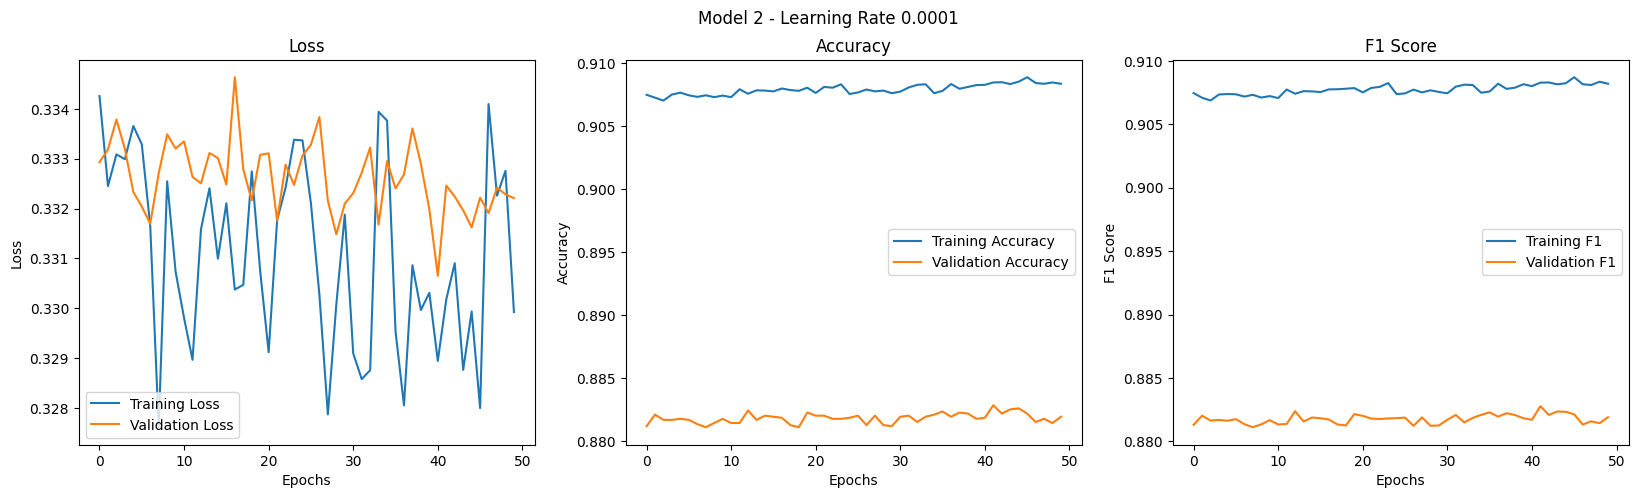

In [64]:

ds = Dataset()
X_train, y_train, X_val, y_val, X_test, y_test = ds.get_data()
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

layers =[[
    DenseLayer(784, 256),
    ReLULayer(),
    BatchNormLayer(256),
    DropoutLayer(0.5),
    DenseLayer(256, 128),
    ReLULayer(),
    BatchNormLayer(128),
    DropoutLayer(0.5),
    DenseLayer(128, 64),
    ReLULayer(),
    BatchNormLayer(64),
    DropoutLayer(0.5),
    DenseLayer(64, 10),
    SoftmaxLayer()
], [
    DenseLayer(784, 512),
    ReLULayer(),
    BatchNormLayer(512),
    DropoutLayer(0.5),
    DenseLayer(512, 256),
    ReLULayer(),
    BatchNormLayer(256),
    DropoutLayer(0.5),
    DenseLayer(256, 10),
    SoftmaxLayer()
], [
    DenseLayer(784, 512),
    ReLULayer(),
    BatchNormLayer(512),
    DropoutLayer(0.5),
    DenseLayer(512, 256),
    ReLULayer(),
    BatchNormLayer(256),
    DropoutLayer(0.5),
    DenseLayer(256, 128),
    ReLULayer(),
    BatchNormLayer(128),
    DropoutLayer(0.5),
    DenseLayer(128, 10),
    SoftmaxLayer()
]
]

learning_rates = [5e-3, 1e-3, 5e-4, 1e-4]

# nn = NeuralNetwork(layers[1])
# nn.compile()
# train_loss, val_loss, train_acc, val_acc, train_f1, val_f1 = nn.fit(
#     X_train, y_train, X_val, y_val, epochs=5, learning_rate=0.001, batch_size=32)
# plot_metrics(train_loss, val_loss, train_acc, val_acc, train_f1, val_f1, 'Neural Network')
# nn.save_weights('nn_model_weights.pkl')

# test_accuracy, test_f1, cm = nn.performance_metrics(X_test, y_test)

# print(f'Test Accuracy: {test_accuracy:.4f}')
# print(f'Test F1: {test_f1:.4f}')

# plot_confusion_matrix(cm)

# with open('nn_model.pkl', 'wb') as f:
#     pickle.dump(nn, f)

#print(len(layers))


clean_file_dir()

report_models(layers, learning_rates, X_train, y_train, X_val, y_val)


In [65]:
# save the model weights

nn2 = NeuralNetwork(layers[1])
nn2.load_weights('nn_model_weights.pkl')

test_accuracy, test_f1, cm = nn2.performance_metrics(X_test, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1: {test_f1:.4f}')

FileNotFoundError: [Errno 2] No such file or directory: 'nn_model_weights.pkl'

In [ ]:
# save the model weights

nn2 = NeuralNetwork(layers[1])
nn2.load_weights('model_weights/model_1_1_weights.pkl')

test_accuracy, test_f1, cm = nn2.performance_metrics(X_test, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1: {test_f1:.4f}')

In [ ]:
nn3 = NeuralNetwork(layers[2])
nn3.load_weights('model_weights/model_2_1_weights.pkl')

test_accuracy, test_f1, cm = nn3.performance_metrics(X_test, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1: {test_f1:.4f}')

In [ ]:
nn4 = NeuralNetwork(layers[0])
nn4.load_weights('model_weights/model_0_1_weights.pkl') 

test_accuracy, test_f1, cm = nn4.performance_metrics(X_test, y_test)

print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1: {test_f1:.4f}')